# liberaries init


In [1]:
import mne
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple
import shutil

import os
import math
import pandas as pd
from pandas import DataFrame
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import mne
import torch
from torch.utils.data import DataLoader ,  Dataset
from torch import Tensor
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR ,    MultiStepLR
import torch.nn.functional as F


import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF



In [2]:
#global use

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
MODELS_AND_CHECKPOINTS_PATH = r"C:\disque d\ai_stuff\projects\pytorchtraining\eeg_competition\models_and_checkpoints"

make it deterministic

In [4]:
def make_deterministic(seed: int = 42):
    import os, random, numpy as np, torch
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # CUDA determinism
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

make_deterministic(42)
g = torch.Generator().manual_seed(42)


# ccd Data preproccessing


## preparing the data


In [3]:
def load_participant_files_from_dir(dir_path: Path) -> dict[str ,  List[Path] ]:
    """
    from participants directory returns files path orginized in relation to task and run 
    exemple 
    dic = {
    "contrastchangeDetection_run-1" : [path1,path2,path3],
    ...   
    }

    """
    dir_path = os.path.join(dir_path , "eeg")
    participant_files = {}
    for file in os.listdir(dir_path):
        elements = file.split("_")
        if len(elements ) < 3 :
            print(elements)
            continue
        if len(elements ) == 3 :
            elements.insert(2 , "run-1")
        elements[1] += "_"+ elements[2]
        del elements[2]
        if elements[1] not in participant_files:
            participant_files[elements[1]] = [Path(os.path.join(dir_path , file))]
        else:
            participant_files[elements[1]].append(Path(os.path.join(dir_path , file)))
    # aka each task has the events , channels , eeg json and eeg raw
    for key in participant_files  :
        assert len(participant_files[key]) == 4 
    return participant_files
def prepare_ccd_events(events_fp : Path) -> DataFrame:
    """
    from events file returns a dataframe with trial start , trial end , stimulas start , action onset , RT AND SUCCESS

    """
    assert os.path.splitext(events_fp)[1] == ".tsv"
    events = pd.read_csv(events_fp , sep = "\t")
    events["onset"] = pd.to_numeric(events["onset"],errors="raise")   
    events = events.reset_index(drop=True)
    events = events.sort_values(by="onset" , ascending=True)
    trials = events[ events["value"] == "contrastTrial_start"].copy()
    trials["trial_start"] = trials["onset"]

    trials["trial_end"] = trials["onset"].shift(-1) 
    stimulas = events [ events["value"].isin(["right_target" ,"left_target"])].copy()
    action = events [ events["value"].isin(["right_buttonPress" ,"left_buttonPress"])].copy()
    results = []
    for i in range(0 ,len(trials)-1 ):
        #get the stimulas onset in the trial i duration
        stimulas_row = stimulas[ (stimulas["onset"] >= trials["trial_start"].iloc[i]) & (stimulas["onset"] < trials["trial_end"].iloc[i]) ]
        if stimulas_row.empty:
            continue
        stimulas_start = float(stimulas_row["onset"].iloc[0])

        action_rows = action[ (action["onset"] >= stimulas_start) & (action["onset"] < trials["trial_end"].iloc[i]) ]
        # if theres no action , theres no rt , theres no success
        if action_rows.empty:
            
            continue
        action_row = action_rows.iloc[0]
        action_onset = float(action_row["onset"])
        rt = action_onset - stimulas_start
        success = 1 if action_row["feedback"] == "smiley_face" else 0
        result ={
        "trial_start" : float(trials["trial_start"].iloc[i]) ,
        "trial_end" :float(trials["trial_end"].iloc[i]) ,
        "stimulas_start" : stimulas_start,
        "action_onset" :action_onset  ,
        "rt" : rt ,
        "success" : success
        }
        results.append(result)
    return pd.DataFrame(results)


    

def prepare_participants_ccd_data(data_dir: Path) -> Dict[str , Dict[str , Tuple[DataFrame , Path]]]:

    #dictionary that will have for each  participant (path as key) a dictionary with the ccd-run (key) and values as the df , and path to raw eeg file 
    results = {}
    for release in os.listdir(data_dir):
        release_dir_path = os.path.join(data_dir , release)
        #go throught the participants directory
        for file in os.listdir(release_dir_path):
            
            if not  file.split("-")[0] == "sub" :
                continue

            participant_id = file
            participant_dir_path = os.path.join(release_dir_path , file)

            results[participant_dir_path] = {}
            participant_files = load_participant_files_from_dir(participant_dir_path)
            filtered_participant_files = {}
            # filter for ccd and sus data
            for key in participant_files:
                if key.split("_")[0].lower() == "task-contrastchangedetection" :
                    filtered_participant_files[key] = participant_files[key]
            
            for task , files in filtered_participant_files.items():
                events_path = [path for path in files if "events" in str(path)]  
                assert len(events_path) == 1
                events_path = events_path[0]
                eeg_path = [path for path in files if ".bdf" in str(path)]

                assert len(eeg_path) == 1
                df = prepare_ccd_events(events_path)
                results[participant_dir_path][task] = (df , eeg_path[0])
    return results

def participants_ccd_data_to_list(data : dict) -> List[Tuple[DataFrame , Path]]:
    results = []
    for participant in data:
        for task in data[participant]:
            results.append(data[participant][task])
    return results
            
def participants_ccd_list_to_trial_rt_pair(data : List[Tuple[DataFrame , Path]]) -> List[Tuple[Path ,Tuple[float,float] , float]]:
    results = []
    for participant in data:
        df , eeg_path = participant
        for i in range(0 , len(df)):
            results.append((eeg_path , (df["stimulas_start"].iloc[i]+0.5 , df["stimulas_start"].iloc[i]+2.5 ) , df["rt"].iloc[i]))
    return results

def train_val_test_split_by_subject(data : List[Tuple[Path ,Tuple[float,float] , float]] , test_size : float = 0.1 , val_size : float = 0.1) -> Tuple[List[Tuple[Path ,Tuple[float,float] , float]] , List[Tuple[Path ,Tuple[float,float] , float]] , List[Tuple[Path ,Tuple[float,float] , float]]]:
    subjects = []
    for element in data:
        path = element[0]
        subject = str(path).split('\\')[-3]
        if subject not in subjects:
            subjects.append(subject)
    train_subjects , test_subjects = train_test_split(subjects , test_size=test_size +val_size)
    test_subjects , val_subjects = train_test_split(test_subjects , test_size=val_size/(test_size +val_size))
    train_data = []
    test_data = []
    val_data = []
    for element in data:
        path = element[0]
        subject = str(path).split('\\')[-3]
        if subject in train_subjects:
            train_data.append(element)
        elif subject in test_subjects:
            test_data.append(element)
        elif subject in val_subjects:
            val_data.append(element)
    return train_data , val_data , test_data



In [4]:
data_path= r"D:\projects\pytorch_training\data_1"
data = prepare_participants_ccd_data(data_path)

data = participants_ccd_data_to_list(data)
data = participants_ccd_list_to_trial_rt_pair(data)
train , val , test = train_val_test_split_by_subject(data)
print(len(data))

['sedQjjK1A']
84341


## extracting the raw eeg windows data and setting them up for fast import


In [4]:
def pairs_to_fast_loading_shards(data : List[Tuple[Path ,Tuple[float,float] , float]] , split = "train" , shard_size : int = 1000 ,shards_path= "ccd_shards_dir"):
    split_path = os.path.join(shards_path , split)

    if not os.path.exists(shards_path):
        os.makedirs(shards_path)

    if not os.path.exists(split_path):
        os.makedirs(split_path)
    else:
        return split_path


    shard_index=0
    window_shard_path = os.path.join(split_path , f"window_shard_{shard_index}.npy")
    rt_shard_path = os.path.join(split_path , f"rt_shard_{shard_index}.npy")
    windows =[]
    rts =[]
    print(f"proccessing {split} data , length = {len(data)}")
    for index , element in tqdm(enumerate(data)):
        if index!=0 and index % shard_size == 0:
            window_array = np.array(windows)
            rt_array = np.array(rts)
            X = np.lib.format.open_memmap(window_shard_path , dtype='float32' , mode='w+' , shape=(window_array.shape[0] , window_array.shape[1] , window_array.shape[2]))
            X[:] = window_array
            del X
            Y = np.lib.format.open_memmap(rt_shard_path , dtype='float32' , mode='w+' , shape=(rt_array.shape[0] ,))
            Y[:] = rt_array
            del Y

            print("saved_file")
            shard_index+=1
            window_shard_path = os.path.join(split_path , f"window_shard_{shard_index}.npy")
            rt_shard_path = os.path.join(split_path , f"rt_shard_{shard_index}.npy")
            windows =[]
            rts =[]
        eeg_path , (start , end) , rt = element
        eeg = mne.io.read_raw_bdf(eeg_path, preload=True, verbose=False)
        eeg = eeg.crop(start , end)
        raw = eeg.get_data()[: ,:200]
        windows.append(raw)
        rts.append(rt)
    window_array = np.array(windows)
    rt_array = np.array(rts)
    if len(window_array) > 0:
        X = np.lib.format.open_memmap(window_shard_path , dtype='float32' , mode='w+' , shape=(window_array.shape[0] , window_array.shape[1] , window_array.shape[2]))
        X[:] = window_array
        del X
        Y = np.lib.format.open_memmap(rt_shard_path , dtype='float32' , mode='w+' , shape=(rt_array.shape[0] ,))
        Y[:] = rt_array
        del Y
    return split_path
    


In [26]:
shard_size = 1000
pairs_to_fast_loading_shards(train , "train" ,shard_size )
pairs_to_fast_loading_shards(test , "test",shard_size )
pairs_to_fast_loading_shards(val , "val",shard_size )

NameError: name 'train' is not defined

In [4]:
class EEGDataset(Dataset):
    def __init__(self , shards_path , shard_size  =1000 , device = "cuda"  , split = "train"):
        self.shards_path = os.path.join(shards_path , split)
        self.numbers_of_shards = int( len(os.listdir(self.shards_path)) / 2)
        self.shard_size = shard_size
        
        
    def __len__(self):
        length = 0
        for shard_path in os.listdir(self.shards_path):
            if "window" in shard_path:
                window_shard_path = os.path.join(self.shards_path , shard_path)
                shard = np.lib.format.open_memmap(window_shard_path , mode="r")
                size = shard.shape[0]
                length += size
        return length
    
    def __getitem__(self , index):
        shard_pos = index // self.shard_size 
        window_shard_path = os.path.join(self.shards_path , f"window_shard_{shard_pos}.npy")
        X = np.lib.format.open_memmap(window_shard_path , mode="r")
        rt_shard_path = os.path.join(self.shards_path , f"rt_shard_{shard_pos}.npy")
        Y = np.lib.format.open_memmap(rt_shard_path , mode="r")
        raw = X[index % self.shard_size]
        rt = Y[index % self.shard_size]
        tensor_raw = torch.tensor(raw , dtype=torch.float32).to(device)
        tensor_rt = torch.tensor(rt , dtype=torch.float32).to(device)
        return tensor_raw , tensor_rt

        


In [5]:

shard_size = 1000
shards_path= r"C:\disque d\ai_stuff\projects\pytorchtraining\eeg_competition\ccd_shards_dir_full"
"""train_pairs_shards_path = pairs_to_fast_loading_shards([] , "train" , shard_size)
test_pairs_shards_path = pairs_to_fast_loading_shards([] , "test" ,  shard_size)
val_pairs_shards_path =pairs_to_fast_loading_shards([] , "val" , shard_size)"""
train_ccd_data = EEGDataset(shards_path ,  shard_size ,device , split="train")
test_ccd_data = EEGDataset(shards_path , shard_size , device , split="test")
val_ccd_data = EEGDataset(shards_path ,shard_size , device  , split="val")
eeg , rt=train_ccd_data[0]
print(eeg.shape)
print(rt)


torch.Size([129, 200])
tensor(2.1300, device='cuda:0')


# Baseline model training


In [6]:

def nrmse_over_data(model, dataloader, device):
    model.eval()
    se_sum = 0.0     # sum of squared errors
    sum_y = 0.0      # sum of y
    sum_y2 = 0.0     # sum of y^2
    n = 0

    with torch.inference_mode():
        with torch.autocast(device_type="cuda", enabled=False):
            index = 0 

            for x, y in tqdm(dataloader):

                x = x.to(device, dtype=torch.float32)
                y = y.to(device, dtype=torch.float32)

                y_pred = model(x).view_as(y)
                diff = y_pred - y

                se_sum += diff.pow(2).sum().item()
                sum_y  += y.sum().item()
                sum_y2 += y.pow(2).sum().item()
                n += y.numel()

    rmse = (se_sum / n) ** 0.5
    var  = (sum_y2 / n) - (sum_y / n) ** 2
    std  = var ** 0.5
    return rmse / std


In [7]:

batch_size = 64

train_ccd_dataloader = DataLoader(train_ccd_data , batch_size=batch_size , shuffle=True )#, generator=g )
test_ccd_dataloader = DataLoader(test_ccd_data , batch_size=batch_size , shuffle=False )
val_ccd_dataloader = DataLoader(val_ccd_data , batch_size=batch_size , shuffle=False )

In [15]:
class BaseLineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = nn.LayerNorm(200)

        self.channel_pooling = nn.Sequential(
            nn.Linear(129 , 64),
            nn.SiLU(),
            nn.Linear(64,32)

        )
        self.pooling = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=5),
            nn.SiLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(64, 32, kernel_size=5),
            nn.SiLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 *47 , 512),
            nn.SiLU(),
            nn.Linear(512 , 1)
        )
    def forward(self , x):
        x = self.norm(x)
        x = x.permute(0,2,1)
        x = self.channel_pooling(x)
        x = x.permute(0,2,1)
        x = self.pooling(x)
        x = self.regressor(x)
        return x

In [28]:

blmodel = BaseLineModel().to(device)

lr = 5e-4

optimizer = torch.optim.AdamW(blmodel.parameters() , lr=lr   )
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer , patience=1 )

loss_f = nn.MSELoss()


In [29]:



#print("before training")
#print(f"train nRMSE : {nrmse_over_data(blmodel , train_ccd_dataloader ,device)}")
#print(f"test nRMSE : {nrmse_over_data(blmodel , test_ccd_dataloader ,device)}")

epochs = 30
with torch.autocast(device_type="cuda", enabled=False):

    for epoch in range(epochs):
        blmodel.train()
        cumulative_loss = 0
        for  batch in tqdm(train_ccd_dataloader):
            x , y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred = blmodel(x)
            loss = loss_f(y_pred.squeeze(-1) , y)
            cumulative_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #nrmse_train = nrmse_over_data(blmodel , train_ccd_dataloader ,device)
        #if lr!= optimizer.param_groups[0]['lr']:
        #    print(f"new lr : {optimizer.param_groups[0]['lr']}")
        #    lr = optimizer.param_groups[0]['lr']

        print(f"train epoch : {epoch +1} , loss : {cumulative_loss/len(train_ccd_dataloader)}")# , nRMSE : {nrmse_train}")
        blmodel.eval()
        with torch.inference_mode():
            cumulative_loss = 0
            for batch in tqdm(val_ccd_dataloader):
                x , y = batch
                x = x.to(device)
                y = y.to(device)
                y_pred = blmodel(x)
                loss = loss_f(y_pred.squeeze(-1) , y)
                cumulative_loss += loss.item()
            nrmse_over_val = nrmse_over_data(blmodel , val_ccd_dataloader ,device)
            scheduler1.step(nrmse_over_val)
            print(f"test epoch : {epoch +1} , loss : {cumulative_loss/len(val_ccd_dataloader)} , nRMSE : {nrmse_over_val}")
        






  0%|          | 0/1051 [00:00<?, ?it/s]

100%|██████████| 1051/1051 [01:25<00:00, 12.30it/s]


train epoch : 1 , loss : 0.19554375654545486


100%|██████████| 134/134 [00:06<00:00, 19.43it/s]


test epoch : 1 , loss : 0.16729712636390728 , nRMSE : 1.0018320363860007


100%|██████████| 1051/1051 [01:42<00:00, 10.29it/s]


train epoch : 2 , loss : 0.17730106859265


100%|██████████| 134/134 [00:06<00:00, 19.58it/s]


test epoch : 2 , loss : 0.1683270329637314 , nRMSE : 1.0048415389932366


100%|██████████| 1051/1051 [01:26<00:00, 12.09it/s]


train epoch : 3 , loss : 0.17403457830567


100%|██████████| 134/134 [00:06<00:00, 19.39it/s]


test epoch : 3 , loss : 0.16762836488770017 , nRMSE : 1.002736276817248


100%|██████████| 1051/1051 [01:37<00:00, 10.76it/s]


train epoch : 4 , loss : 0.17082426015404606


100%|██████████| 134/134 [00:06<00:00, 20.12it/s]


test epoch : 4 , loss : 0.1695336680025307 , nRMSE : 1.0085948037244818


100%|██████████| 1051/1051 [01:38<00:00, 10.63it/s]


train epoch : 5 , loss : 0.1708341516256616


100%|██████████| 134/134 [00:09<00:00, 14.20it/s]


test epoch : 5 , loss : 0.1695660641277904 , nRMSE : 1.0085880018699778


 46%|████▌     | 486/1051 [00:48<00:56,  9.92it/s]


KeyboardInterrupt: 

In [31]:
nrmse_test=nrmse_over_data(blmodel , test_ccd_dataloader ,device)
print(f"test nRMSE : {nrmse_test}")


100%|██████████| 134/134 [00:07<00:00, 18.78it/s]

test nRMSE : 1.000476755054369


In [32]:
print(f"test nRMSE : {nrmse_test}")


test nRMSE : 1.000476755054369


## final test on r5


In [122]:
path_to_r5 = r"D:\projects\pytorch_training\test_data"
data = prepare_participants_ccd_data(path_to_r5)

data = participants_ccd_data_to_list(data)
data = participants_ccd_list_to_trial_rt_pair(data)

final_r5_test =pairs_to_fast_loading_shards(data ,"final_r5_test" , shard_size)
r5_test_data = EEGDataset(final_r5_test ,  shard_size)


In [134]:

r5_test_dataloader = DataLoader(r5_test_data , batch_size=batch_size , shuffle=False )
print(f"r5 test nRMSE : {nrmse_over_data(blmodel , r5_test_dataloader,device)}")

r5 test nRMSE : 1.0011487058935713


In [136]:
def calculate_rmse(blmodel , dataloader , device):
    blmodel.eval()
    se_sum = 0.0   # sum of squared errors
    n = 0          # total number of elements
    
    with torch.inference_mode():
        for x, y in tqdm(dataloader):
            x = x.to(device)
            y = y.to(device)

            y_pred = blmodel(x).squeeze(-1)
            diff = y_pred - y

            se_sum += (diff ** 2).sum().item()
            n += y.numel()

    rmse = np.sqrt(se_sum / n)
    return rmse

print(f"r5 test RMSE : {calculate_rmse(blmodel , r5_test_dataloader,device)}")

100%|██████████| 38/38 [00:01<00:00, 32.17it/s]

r5 test RMSE : 0.3627938385318386


# full data preproccessing for encoder training


In [15]:
def load_participant_eeg_files_from_dir(dir_path: Path) -> dict[str ,  List[Path] ]:
    """
    from participants directory returns files path orginized in relation to task and run 
    exemple 
    dic = {
    "contrastchangeDetection_run-1" : [path1,path2,path3],
    ...   
    }

    """
    dir_path = os.path.join(dir_path , "eeg")
    participant_files = {}
    for file in os.listdir(dir_path):
        if os.path.splitext(file)[1] != ".bdf":
            continue
        elements = file.split("_")
        if len(elements ) == 3 :
            elements.insert(2 , "run-1")
        elements[1] += "_"+ elements[2]
        del elements[2]
        participant_files[elements[1]] = Path(os.path.join(dir_path , file))


    return participant_files


    

def prepare_participants_eeg_data(data_dir: Path) -> Dict[str , Dict[str , Tuple[DataFrame , Path]]]:

    #dictionary that will have for each  participant (path as key) a dictionary with the ccd-run (key) and values as the df , and path to raw eeg file 
    results = {}
    for release in os.listdir(data_dir):
        release_dir_path = os.path.join(data_dir , release)
        #go throught the participants directory
        for file in os.listdir(release_dir_path):
            
            if not  file.split("-")[0] == "sub" :
                continue

            participant_id = file
            participant_dir_path = os.path.join(release_dir_path , file)

            participant_files = load_participant_eeg_files_from_dir(participant_dir_path)
            results[participant_dir_path] = [list(participant_files.values())]
        

    return results



def get_subject_metadata_from_path(data_path: Path):
    """
    Given a path to an EEG .bdf file, locate the participants.tsv file
    in the release folder (e.g. R7_L100_bdf) and return the metadata
    for that subject ID.

    Example:
        path = Path(r"D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARTY010EYP\eeg\sub-NDARTY010EYP_task-contrastChangeDetection_run-2_eeg.bdf")
        meta = get_subject_metadata_from_path(path)
    """
    # Extract release folder (e.g. "R7_L100_bdf")
    release_dir = data_path.parents[2]  # two levels up: /R7_L100_bdf/sub-XXX/eeg/file.bdf
    tsv_path = release_dir / "participants.tsv"

    if not tsv_path.exists():
        raise FileNotFoundError(f"participants.tsv not found in {release_dir}")

    # Extract subject ID
    subject_id = data_path.name.split("_")[0]  # e.g. "sub-NDARTY010EYP"

    # Read and locate row
    df = pd.read_csv(tsv_path, sep="\t")
    row = df.loc[df["participant_id"] == subject_id]
    if row.empty:
        raise ValueError(f"Subject {subject_id} not found in {tsv_path}")

    # Convert row to dictionary
    meta = row.iloc[0].to_dict()
    meta["release_dir"] = str(release_dir)
    return meta




def train_val_test_split_by_subject_full_data(data : Dict[str , List[Path]], test_size = 0.1 , val_size = 0.1) -> Tuple[List[Path] , List[Path] , List[Path]]:
    subjects = list(data.keys())
    train , test = train_test_split(subjects , test_size=test_size + val_size  )
    test , val = train_test_split(test , test_size = val_size/(test_size + val_size) )
    train_data_paths =[]
    for subject in train:
        for element in data[subject]:
            train_data_paths.extend(element)
    test_data_paths = []
    for subject in test:
        for element in data[subject]:
            test_data_paths.extend(element)
    val_data_paths = []
    for subject in val:
        for element in data[subject]:
            val_data_paths.extend(element)
    return train_data_paths , test_data_paths , val_data_paths  

import gc


def load_and_shard_eeg_data(data_paths: List[Path], split_type="train", shard_size=1000,
                            window_size=200, stride=20, output_dir="full_eeg_data_shards") -> Tuple[Path, int]:
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    shard_path = os.path.join(output_dir, split_type)
    if not os.path.exists(shard_path):
        os.mkdir(shard_path)

    eeg_arrays = []
    current_size = 0
    index = 0
    full_number_of_windows = 0
    full_dict = {}

    print(f"processing {len(data_paths)} files")
    for i, data_path in tqdm(enumerate(data_paths)):
        file_meta_data = get_subject_metadata_from_path(Path(data_path))
        participant_id = file_meta_data["participant_id"]

        file_name = Path(data_path).name
        task_name = file_name.split("_task-")[1].split("_")[0]

        if participant_id not in full_dict:
            full_dict[participant_id] = {}
            full_dict[participant_id]["meta"] = file_meta_data
            full_dict[participant_id]["limits"] = {"Start": full_number_of_windows, "End": None}
            full_dict[participant_id]["tasks"] = {}

        if task_name not in full_dict[participant_id]["tasks"]:
            full_dict[participant_id]["tasks"][task_name] = {"Start": full_number_of_windows, "End": None}
        raw = mne.io.read_raw_bdf(data_path, preload=False, verbose=False)
        n_samples = raw.n_times
        chunk_len = window_size * 100
        for start in range(0, n_samples, chunk_len):
            stop = min(start + chunk_len, n_samples)
            data_chunk = raw.get_data(start=start, stop=stop).astype(np.float32)
            n_windows = data_chunk.shape[1] // window_size
            if n_windows == 0:
                continue
            data_chunk = data_chunk[:, : n_windows * window_size]
            data_chunk = data_chunk.reshape(data_chunk.shape[0], n_windows, window_size).transpose(1, 0, 2)
            if data_chunk.shape[1] != 129:
                print(f"Skipping {data_path}, wrong channel count {data_chunk.shape[1]}")
                continue

            eeg_arrays.append(data_chunk)
            current_size += data_chunk.shape[0]
            full_number_of_windows += data_chunk.shape[0]
            full_dict[participant_id]["limits"]["End"] = full_number_of_windows
            full_dict[participant_id]["tasks"][task_name]["End"] = full_number_of_windows

            if current_size >= shard_size:
                new_eeg_data_windows = np.concatenate(eeg_arrays, axis=0)
                to_be_added = new_eeg_data_windows[:shard_size]
                X = np.lib.format.open_memmap(
                    os.path.join(shard_path, f"window_shard_{index}.npy"),
                    mode="w+", dtype=np.float32,
                    shape=(to_be_added.shape[0], to_be_added.shape[1], to_be_added.shape[2])
                )
                X[:] = to_be_added
                X.flush()
                del X, new_eeg_data_windows, to_be_added
                eeg_arrays = []
                gc.collect()
                current_size = 0
                index += 1

        del raw
        gc.collect()

    if eeg_arrays:
        new_eeg_data_windows = np.concatenate(eeg_arrays, axis=0)
        to_be_added = new_eeg_data_windows[:shard_size]
        X = np.lib.format.open_memmap(
            os.path.join(shard_path, f"window_shard_{index}.npy"),
            mode="w+", dtype=np.float32,
            shape=(to_be_added.shape[0], to_be_added.shape[1], to_be_added.shape[2])
        )
        X[:] = to_be_added
        X.flush()
        index += 1
        full_number_of_windows += to_be_added.shape[0]
        del X, new_eeg_data_windows, to_be_added
        gc.collect()
        

    torch.save(full_dict, os.path.join(shard_path, "full_dict.pt"))
    return shard_path, full_number_of_windows

        


<>:53: SyntaxWarning: invalid escape sequence '\p'
<>:53: SyntaxWarning: invalid escape sequence '\p'
C:\Users\mahdi\AppData\Local\Temp\ipykernel_15092\4045812165.py:53: SyntaxWarning: invalid escape sequence '\p'
  """


In [7]:
path = r"D:\projects\pytorch_training\data_1"
output_dir = r"D:\projects\pytorch_training\full_eeg_data_shards"
detailed_data = prepare_participants_eeg_data(path)
train_data_paths , test_data_paths , val_data_paths = train_val_test_split_by_subject_full_data(detailed_data)

train_data_paths = sorted(train_data_paths, key=lambda p: p.name.split("_")[0])
test_data_paths = sorted(test_data_paths, key=lambda p: p.name.split("_")[0])
val_data_paths = sorted(val_data_paths, key=lambda p: p.name.split("_")[0])

In [8]:
test_path = Path("D:\projects\pytorch_training\data_1\R1_L100_bdf\sub-NDARCZ947WU5\eeg\sub-NDARCZ947WU5_task-surroundSupp_run-1_eeg.bdf")
get_subject_metadata_from_path(test_path)

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\mahdi\AppData\Local\Temp\ipykernel_15092\361888402.py:1: SyntaxWarning: invalid escape sequence '\p'
  test_path = Path("D:\projects\pytorch_training\data_1\R1_L100_bdf\sub-NDARCZ947WU5\eeg\sub-NDARCZ947WU5_task-surroundSupp_run-1_eeg.bdf")


{'participant_id': 'sub-NDARCZ947WU5',
 'release_number': 'R1',
 'sex': 'F',
 'age': 9.3646,
 'ehq_total': 80.04,
 'commercial_use': 'Yes',
 'full_pheno': 'Yes',
 'p_factor': -0.355,
 'attention': 0.7170000000000001,
 'internalizing': -1.45,
 'externalizing': -0.448,
 'RestingState': 'available',
 'DespicableMe': 'available',
 'FunwithFractals': 'available',
 'ThePresent': 'available',
 'DiaryOfAWimpyKid': 'available',
 'contrastChangeDetection_1': 'available',
 'contrastChangeDetection_2': 'available',
 'contrastChangeDetection_3': 'available',
 'surroundSupp_1': 'available',
 'surroundSupp_2': 'available',
 'seqLearning6target': 'unavailable',
 'seqLearning8target': 'available',
 'symbolSearch': 'available',
 'release_dir': 'D:\\projects\\pytorch_training\\data_1\\R1_L100_bdf'}

In [9]:
len(detailed_data)

986

In [16]:

train_dir_path  , train_windows_number = load_and_shard_eeg_data(train_data_paths , split_type="train" , shard_size=1000 , window_size=200 , stride=20 , output_dir=output_dir)
print(f"train data path  { train_dir_path} with {train_windows_number} windows")


processing 7159 files


0it [00:00, ?it/s]

330it [05:28,  1.90it/s]

Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARBA381JGH\eeg\sub-NDARBA381JGH_task-DespicableMe_eeg.bdf, wrong channel count 6
Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARBA381JGH\eeg\sub-NDARBA381JGH_task-DiaryOfAWimpyKid_eeg.bdf, wrong channel count 6


332it [05:28,  2.82it/s]

Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARBA381JGH\eeg\sub-NDARBA381JGH_task-FunwithFractals_eeg.bdf, wrong channel count 6
Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARBA381JGH\eeg\sub-NDARBA381JGH_task-FunwithFractals_eeg.bdf, wrong channel count 6
Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARBA381JGH\eeg\sub-NDARBA381JGH_task-RestingState_eeg.bdf, wrong channel count 6
Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARBA381JGH\eeg\sub-NDARBA381JGH_task-RestingState_eeg.bdf, wrong channel count 6
Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARBA381JGH\eeg\sub-NDARBA381JGH_task-RestingState_eeg.bdf, wrong channel count 6


334it [05:28,  3.72it/s]

Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARBA381JGH\eeg\sub-NDARBA381JGH_task-seqLearning8target_eeg.bdf, wrong channel count 6
Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARBA381JGH\eeg\sub-NDARBA381JGH_task-seqLearning8target_eeg.bdf, wrong channel count 6
Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARBA381JGH\eeg\sub-NDARBA381JGH_task-symbolSearch_eeg.bdf, wrong channel count 6
Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARBA381JGH\eeg\sub-NDARBA381JGH_task-symbolSearch_eeg.bdf, wrong channel count 6


5380it [1:21:12,  1.16it/s]

Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARUJ292JXV\eeg\sub-NDARUJ292JXV_task-RestingState_eeg.bdf, wrong channel count 6
Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARUJ292JXV\eeg\sub-NDARUJ292JXV_task-RestingState_eeg.bdf, wrong channel count 6
Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARUJ292JXV\eeg\sub-NDARUJ292JXV_task-seqLearning8target_eeg.bdf, wrong channel count 6
Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARUJ292JXV\eeg\sub-NDARUJ292JXV_task-seqLearning8target_eeg.bdf, wrong channel count 6
Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARUJ292JXV\eeg\sub-NDARUJ292JXV_task-seqLearning8target_eeg.bdf, wrong channel count 6


5382it [1:21:12,  1.96it/s]

Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARUJ292JXV\eeg\sub-NDARUJ292JXV_task-surroundSupp_run-1_eeg.bdf, wrong channel count 6
Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARUJ292JXV\eeg\sub-NDARUJ292JXV_task-surroundSupp_run-1_eeg.bdf, wrong channel count 6
Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARUJ292JXV\eeg\sub-NDARUJ292JXV_task-surroundSupp_run-1_eeg.bdf, wrong channel count 6
Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARUJ292JXV\eeg\sub-NDARUJ292JXV_task-symbolSearch_eeg.bdf, wrong channel count 6
Skipping D:\projects\pytorch_training\data_1\R7_L100_bdf\sub-NDARUJ292JXV\eeg\sub-NDARUJ292JXV_task-symbolSearch_eeg.bdf, wrong channel count 6


7159it [1:46:21,  1.12it/s]


train data path  D:\projects\pytorch_training\full_eeg_data_shards\train with 1140130 windows


In [17]:
val_dir_path , val_windows_number = load_and_shard_eeg_data(val_data_paths , split_type="val" , shard_size=1000 , window_size=200 , stride=20 , output_dir=output_dir)
test_dir_path , test_windows_number = load_and_shard_eeg_data(test_data_paths , split_type="test" , shard_size=1000 , window_size=200 , stride=20 , output_dir=output_dir)


processing 881 files


0it [00:00, ?it/s]

881it [12:57,  1.13it/s]


processing 846 files


846it [13:25,  1.05it/s]


In [ ]:
meta_dict = torch.load(os.path.join(train_dir_path, "full_dict.pt"))


In [25]:
meta_dict["sub-NDARAB055BPR"]

{'meta': {'participant_id': 'sub-NDARAB055BPR',
  'release_number': 'R6',
  'sex': 'F',
  'age': 10.7939,
  'ehq_total': 60.03,
  'commercial_use': 'Yes',
  'full_pheno': 'Yes',
  'p_factor': 0.366,
  'attention': 1.029,
  'internalizing': -0.461,
  'externalizing': 0.144,
  'RestingState': 'available',
  'DespicableMe': 'available',
  'FunwithFractals': 'available',
  'ThePresent': 'available',
  'DiaryOfAWimpyKid': 'available',
  'contrastChangeDetection_1': 'available',
  'contrastChangeDetection_2': 'available',
  'contrastChangeDetection_3': 'available',
  'surroundSupp_1': 'available',
  'surroundSupp_2': 'available',
  'seqLearning6target': 'unavailable',
  'seqLearning8target': 'available',
  'symbolSearch': 'caution',
  'release_dir': 'D:\\projects\\pytorch_training\\data_1\\R6_L100_bdf'},
 'limits': {'Start': 0, 'End': 1298},
 'tasks': {'contrastChangeDetection': {'Start': 0, 'End': 361},
  'DespicableMe': {'Start': 361, 'End': 447},
  'DiaryOfAWimpyKid': {'Start': 447, 'End'

In [23]:
ordered_subjects = []
ordered_starts = []

valid_subjects = [
    (subj, meta_dict[subj]["limits"]["Start"])
    for subj in meta_dict
    if meta_dict[subj]["limits"]["Start"] != meta_dict[subj]["limits"]["End"]
]

valid_subjects.sort(key=lambda x: x[1])

for subj, start in valid_subjects:
    ordered_subjects.append(subj)
    ordered_starts.append(start)




In [26]:
subject_task = {}

for subj, subj_data in meta_dict.items():
    tasks = subj_data.get("tasks", {})
    if not tasks:
        continue

    task_items = [
        (t_name, t_info["Start"])
        for t_name, t_info in tasks.items()
        if t_info["End"] is not None and t_info["Start"] != t_info["End"]
    ]

    task_items.sort(key=lambda x: x[1])

    subject_task[subj] = {
        "tasks": [t for t, _ in task_items],
        "starts": [s for _, s in task_items]
    }


In [27]:
subject_task

{'sub-NDARAB055BPR': {'tasks': ['contrastChangeDetection',
   'DespicableMe',
   'DiaryOfAWimpyKid',
   'FunwithFractals',
   'RestingState',
   'seqLearning8target',
   'surroundSupp',
   'ThePresent'],
  'starts': [0, 361, 447, 506, 589, 769, 923, 1196]},
 'sub-NDARAB348EWR': {'tasks': ['contrastChangeDetection',
   'DespicableMe',
   'DiaryOfAWimpyKid',
   'FunwithFractals',
   'RestingState',
   'surroundSupp',
   'symbolSearch',
   'ThePresent'],
  'starts': [1298, 1752, 1838, 1898, 1981, 2198, 2470, 2656]},
 'sub-NDARAB458VK9': {'tasks': ['contrastChangeDetection',
   'DespicableMe',
   'DiaryOfAWimpyKid',
   'FunwithFractals',
   'RestingState',
   'seqLearning8target',
   'surroundSupp',
   'symbolSearch',
   'ThePresent'],
  'starts': [2758, 3231, 3319, 3380, 3465, 3684, 3836, 4289, 4512]},
 'sub-NDARAB708LM5': {'tasks': ['RestingState'], 'starts': [4615]},
 'sub-NDARAB756JDJ': {'tasks': ['contrastChangeDetection',
   'DiaryOfAWimpyKid',
   'FunwithFractals',
   'RestingState'

In [35]:
import os
from pathlib import Path
import bisect
import numpy as np
import torch
from torch.utils.data import Dataset
from collections import OrderedDict

class Encoder_Dataset(Dataset):
    def __init__(self, data_dir, window_size=200, stride=20,
                 split="train", shard_size=1000):
        self.data_dir = Path(data_dir)
        self.window_size = int(window_size)
        self.stride = int(stride)
        self.split = split
        self.shard_size = int(shard_size)

        split_dir = self.data_dir / split
        if not split_dir.exists():
            raise FileNotFoundError(split_dir)

        self.shard_paths = sorted(
            (p for p in split_dir.glob("window_shard_*.npy")),
            key=lambda p: int(p.stem.split("_")[-1])
        )
        if not self.shard_paths:
            raise RuntimeError("No shard files matching window_shard_*.npy")

        self.shard_meta = []
        self.prefix_virtual = [0]
        total_virtual = 0
        for path in self.shard_paths:
            arr = np.load(path, mmap_mode="r")
            n_base, C, W = arr.shape
            if W != self.window_size:
                raise ValueError(f"{path.name}: W={W} != window_size={self.window_size}")
            total_samples = n_base * self.window_size
            n_virtual = ((total_samples - self.window_size) // self.stride) + 1 if total_samples >= self.window_size else 0
            self.shard_meta.append({
                "path": path,
                "n_base": int(n_base),
                "C": int(C),
                "W": int(W),
                "n_virtual": int(n_virtual),
            })
            total_virtual += n_virtual
            self.prefix_virtual.append(total_virtual)
        self.total_virtual = total_virtual
        if self.total_virtual == 0:
            raise RuntimeError("No virtual windows possible.")

        # Load meta
        self.full_dict = torch.load(os.path.join(split_dir, "full_dict.pt"))
        self.ordered_subjects = []
        self.ordered_starts = []

        valid_subjects = [
            (subj, self.full_dict[subj]["limits"]["Start"])
            for subj in self.full_dict
            if self.full_dict[subj]["limits"]["Start"] is not None
            and self.full_dict[subj]["limits"]["End"] is not None
            and self.full_dict[subj]["limits"]["Start"] != self.full_dict[subj]["limits"]["End"]
        ]
        valid_subjects.sort(key=lambda x: x[1])

        for subj, start in valid_subjects:
            self.ordered_subjects.append(subj)
            self.ordered_starts.append(start)

        self.subject_task = {}
        for subj, subj_data in self.full_dict.items():
            tasks = subj_data.get("tasks", {})
            if not tasks:
                continue
            task_items = [
                (t_name, t_info["Start"])
                for t_name, t_info in tasks.items()
                if t_info["End"] is not None and t_info["Start"] != t_info["End"]
            ]
            task_items.sort(key=lambda x: x[1])
            self.subject_task[subj] = {
                "tasks": [t for t, _ in task_items],
                "starts": [s for _, s in task_items]
            }

    def __len__(self):
        return self.total_virtual

    def _load_shard(self, shard_idx: int):
        path = self.shard_meta[shard_idx]["path"]
        return np.load(path, mmap_mode="r")

    def _locate(self, global_index: int):
        s = bisect.bisect_right(self.prefix_virtual, global_index) - 1
        local_idx = global_index - self.prefix_virtual[s]
        return s, local_idx

    def _get_metadata(self, window_index: int):
        subj_idx = bisect.bisect_right(self.ordered_starts, window_index) - 1
        subject = self.ordered_subjects[subj_idx]
        task_idx = bisect.bisect_right(self.subject_task[subject]["starts"], window_index) - 1
        task = self.subject_task[subject]["tasks"][task_idx]
        meta_data = self.full_dict[subject]
        return subject, task, meta_data

    def __getitem__(self, index: int):
        if index < 0 or index >= self.total_virtual:
            raise IndexError

        shard_idx, local_idx = self._locate(index)
        meta = self.shard_meta[shard_idx]
        shard = self._load_shard(shard_idx)

        W = self.window_size
        start = local_idx * self.stride
        base_idx = start // W
        offset = start % W

        if offset == 0:
            x = shard[base_idx]
        else:
            first = shard[base_idx, :, offset:]
            need = W - first.shape[1]
            second = shard[base_idx + 1, :, :need]
            x = np.concatenate([first, second], axis=1)

        global_window_index = self.prefix_virtual[shard_idx] + local_idx
        subject_id, task, meta_data = self._get_metadata(global_window_index)
        return torch.from_numpy(np.asarray(x, dtype=np.float32)), subject_id, task, meta_data


In [37]:
output_dir = r"D:\projects\pytorch_training\full_eeg_data_shards"
train_dataset = Encoder_Dataset(output_dir ,stride=10, split="train")
test_dataset = Encoder_Dataset(output_dir ,stride=10, split="test")
val_dataset = Encoder_Dataset(output_dir ,stride=10, split="val")

In [38]:
len(train_dataset)

21798931

In [39]:
batch_size = 1
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset,batch_size=batch_size, shuffle=False)

In [40]:
for batch in train_loader:
    x , subject_id, task, meta_data = batch
    print(x.shape)
    print(subject_id)
    print(task)
    print(meta_data)
    break

torch.Size([1, 129, 200])
('sub-NDARZZ830JM7',)
('ThePresent',)
{'meta': {'participant_id': ['sub-NDARZZ830JM7'], 'release_number': ['R7'], 'sex': ['M'], 'age': tensor([13.1215], dtype=torch.float64), 'ehq_total': tensor([-13.3400], dtype=torch.float64), 'commercial_use': ['Yes'], 'full_pheno': ['Yes'], 'p_factor': tensor([1.3690], dtype=torch.float64), 'attention': tensor([-1.1980], dtype=torch.float64), 'internalizing': tensor([-0.1100], dtype=torch.float64), 'externalizing': tensor([0.6360], dtype=torch.float64), 'RestingState': ['available'], 'DespicableMe': ['available'], 'FunwithFractals': ['available'], 'ThePresent': ['available'], 'DiaryOfAWimpyKid': ['available'], 'contrastChangeDetection_1': ['unavailable'], 'contrastChangeDetection_2': ['available'], 'contrastChangeDetection_3': ['available'], 'surroundSupp_1': ['available'], 'surroundSupp_2': ['available'], 'seqLearning6target': ['unavailable'], 'seqLearning8target': ['available'], 'symbolSearch': ['available'], 'release_di

In [10]:
class Vit_EEG_Embedding(nn.Module):
    def __init__(self,nb_tokens , c_dim = 129   ,  t_dim = 200 , slice_size = 10 ,target_c_dim = 64 , target_t_dim = 6  , emb_dim = 512     ):
        super().__init__()
        self.time_projection = nn.Linear(slice_size  ,target_t_dim)
        self.channel_projection = nn.Linear(c_dim , target_c_dim)
        self.time_positional_emb = nn.Parameter(torch.zeros(1 , 1 , 1 , target_t_dim))
        self.channel_positional_emb = nn.Parameter(torch.zeros(1 , 1 , target_c_dim , 1))
        self.token_projection = nn.Linear(target_c_dim*target_t_dim , emb_dim)
        self.token_positional_emb = nn.Parameter(torch.zeros(  nb_tokens , emb_dim))
        self.mask_paramater = nn.Parameter(torch.zeros( c_dim , slice_size))
        nn.init.xavier_uniform_(self.time_positional_emb)
        nn.init.xavier_uniform_(self.channel_positional_emb)
        nn.init.xavier_uniform_(self.token_positional_emb)

        nn.init.xavier_uniform_(self.mask_paramater)

        self.slice_size = slice_size

    def zscore_bct(self ,x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
        """
        Per-window, per-channel z-score along time: (B, C, T) -> (B, C, T).
        """
        if not x.is_floating_point():
            x = x.float()
        mu = x.mean(dim=2, keepdim=True)
        sigma = x.std(dim=2, keepdim=True, unbiased=False).clamp_min(eps)
        return (x - mu) / sigma

    def patching (self,x : Tensor):
        # x starting shape (B , C , T)
        x = x.reshape(x.shape[0] , x.shape[1] ,   x.shape[2] // self.slice_size , self.slice_size)
        x = x.permute(0 , 2 , 1 , 3)
        return x
    def forward(self,x ,mask_index =  None):
        
        # x starting shape (B , C , T)
        # normilizing
        x = self.zscore_bct(x)
        x = self.patching(x)
        # x (B , N , C , slice)  N = T // slice
        if mask_index is not None:
            origin = x.clone()
            r = mask_index.shape[1]
            batch_index = torch.arange(x.shape[0],device=x.device).unsqueeze(1).expand(x.shape[0] , r)
            x[batch_index , mask_index ] = self.mask_paramater


        # x (B ,N , C , slice)  N = T // slice
        x = self.time_projection(x)
        # x (B , N , C , Target_t_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_t_dim , C)
        x = self.channel_projection(x)
        # x (B , N , Target_t_dim , Target_c_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_c_dim , Target_t_dim)
        x = x + self.time_positional_emb
        x = x + self.channel_positional_emb
        # Flatten 
        x= x.reshape(x.shape[0] , x.shape[1] , x.shape[2] * x.shape[3])
        # x (B , N , Target_c_dim * Target_t_dim)
        x = self.token_projection(x)
        # x (B , N , emb_dim)
        x = x + self.token_positional_emb
        if mask_index is not None:
            return x , origin
        return x , None
class Vit_EEG_Encoder(nn.Module):
    def __init__(self,c_dim = 129  ,  t_dim = 200   , slice_size = 10 , emb_dim = 512 , nhead = 8 ,  nb_layers = 6 ):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.emb_dim = emb_dim
        self.slice_size = slice_size
        assert self.t_dim % self.slice_size == 0
        self.nb_tokens = self.t_dim // self.slice_size

        self.nhead = nhead
        self.nb_layers = nb_layers
        self.embedding = Vit_EEG_Embedding(nb_tokens=self.nb_tokens , c_dim = self.c_dim , t_dim = self.t_dim , slice_size = self.slice_size , target_c_dim = self.c_dim , target_t_dim = self.slice_size , emb_dim = self.emb_dim )
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=self.emb_dim , nhead=self.nhead , dim_feedforward=emb_dim*4 , batch_first=True , norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer , num_layers=self.nb_layers ,enable_nested_tensor=False)
        self.decoder = nn.Sequential(
        nn.LayerNorm(emb_dim),
        nn.Linear(emb_dim, emb_dim * 4),
        nn.GELU(),
        nn.Linear(emb_dim * 4, self.c_dim * self.slice_size))
    def _make_mask(self, x , mask_ratio=0.2):
        # x: (B, C, T)
        masked_index = torch.randint(low=0 , high=self.nb_tokens , size=(x.shape[0],int(self.nb_tokens * mask_ratio),))
        return   masked_index

    def extract_features(self,x):   
        x ,_= self.embedding(x)
        x = self.transformer_encoder(x)
        return x
    def forward(self,x  , mask_index =None):
        emb_x , targets=  self.embedding(x ,   mask_index)
        transformed = self.transformer_encoder(emb_x)
        result = self.decoder(transformed)
        if targets is not None:
            return result , targets
        return result
        

In [22]:
import os
import math
import torch

model = Vit_EEG_Encoder().to(device)

# optimizer
lr = 1e-4
weight_decay = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_f = nn.MSELoss()

# epochs
epochs = 20
print_after = 1000
save_after = 10000
save_path = "last_checkpoint.pt"

# scheduler (epoch-based warmup + cosine)
warmup_epochs = 1
cosine_epochs = epochs - warmup_epochs

warmup = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=1e-8, end_factor=1.0, total_iters=warmup_epochs
)
cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=cosine_epochs
)
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer, schedulers=[warmup, cosine], milestones=[warmup_epochs]
)

# loss tracking
train_losses = []
val_losses = []

# resume
start_epoch = 0
start_it = 0
global_steps = 0
if os.path.isfile(save_path):
    ckpt = torch.load(save_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    start_epoch = ckpt.get("epoch", 0)
    start_it = ckpt.get("it_in_epoch", 0)
    global_steps = ckpt.get("steps", 0)
    train_losses = ckpt.get("train_losses", [])
    val_losses = ckpt.get("val_losses", [])
    print(f"Resumed: epoch={start_epoch}, it_in_epoch={start_it}, steps={global_steps}")

for epoch in range(start_epoch, epochs):
    # ===================== train =====================
    model.train()
    curr_loss = 0
    curr_nb_batches = 0

    for it, x in enumerate(tqdm(train_loader)):
        x = x.to(device)
        optimizer.zero_grad()
        
        mask_indexes = model._make_mask(x).to(device)
        batch_index = torch.arange(mask_indexes.shape[0], device=device).unsqueeze(1).expand(mask_indexes.shape[0], mask_indexes.shape[1])

        out, target = model(x, mask_indexes)
        out = out.reshape(out.shape[0], out.shape[1], model.c_dim, model.slice_size)
        out = out[batch_index, mask_indexes]
        target = target[batch_index, mask_indexes]

        loss = loss_f(out, target)
        loss.backward()
        optimizer.step()

        val = loss.item()
        curr_loss += val
        curr_nb_batches += 1
        global_steps += 1

        if curr_nb_batches >= print_after:
            avg_chunk = curr_loss / curr_nb_batches
            print(f"Epoch {epoch} , loss {avg_chunk}")
            train_losses.append(avg_chunk)
            curr_loss = 0
            curr_nb_batches = 0

        if global_steps % save_after == 0:
            torch.save(
                {"epoch": epoch,
                 "it_in_epoch": it + 1,
                 "steps": global_steps,
                 "model": model.state_dict(),
                 "train_losses": train_losses,
                 "val_losses": val_losses},
                save_path
            )
            print(f"Saved checkpoint at step {global_steps} -> {save_path}")

    # ===================== test =====================
    model.eval()
    val_loss = 0
    val_batches = 0
    val_curr_loss = 0
    val_curr_nb_batches = 0
    with torch.inference_mode():
        for x in tqdm(val_loader):
            x = x.to(device)
            mask_indexes = model._make_mask(x).to(device)
            batch_index = torch.arange(mask_indexes.shape[0], device=device).unsqueeze(1).expand(mask_indexes.shape[0], mask_indexes.shape[1])

            out, target = model(x, mask_indexes)
            out = out.reshape(out.shape[0], out.shape[1], model.c_dim, model.slice_size)
            out = out[batch_index, mask_indexes]
            target = target[batch_index, mask_indexes]

            loss = loss_f(out, target)
            v = loss.item()
            val_loss += v
            val_batches += 1

            val_curr_loss += v
            val_curr_nb_batches += 1
            if val_curr_nb_batches >= print_after:
                print(f"Epoch {epoch} , val_loss {val_curr_loss / val_curr_nb_batches}")
                val_curr_loss = 0
                val_curr_nb_batches = 0

    if val_batches > 0:
        avg_val = val_loss / val_batches
        print(f"Epoch {epoch} , val_loss {avg_val}")
        val_losses.append(avg_val)

    # step scheduler ONCE per epoch (not per batch)
    scheduler.step()

    # save checkpoint at end of epoch
    torch.save(
        {"epoch": epoch + 1,
         "it_in_epoch": 0,
         "steps": global_steps,
         "model": model.state_dict(),
         "train_losses": train_losses,
         "val_losses": val_losses},
        save_path
    )


  0%|          | 0/306584 [00:00<?, ?it/s]C:\Users\mahdi\AppData\Local\Temp\ipykernel_16572\2161087430.py:97: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  return torch.from_numpy(np.asarray(x, dtype=np.float32))
  0%|          | 1001/306584 [03:40<13:11:24,  6.44it/s]

Epoch 0 , loss 1.005246112704277


  1%|          | 2000/306584 [06:31<17:14:00,  4.91it/s]

Epoch 0 , loss 1.0073635778427124


  1%|          | 2304/306584 [07:23<16:15:26,  5.20it/s]


KeyboardInterrupt: 

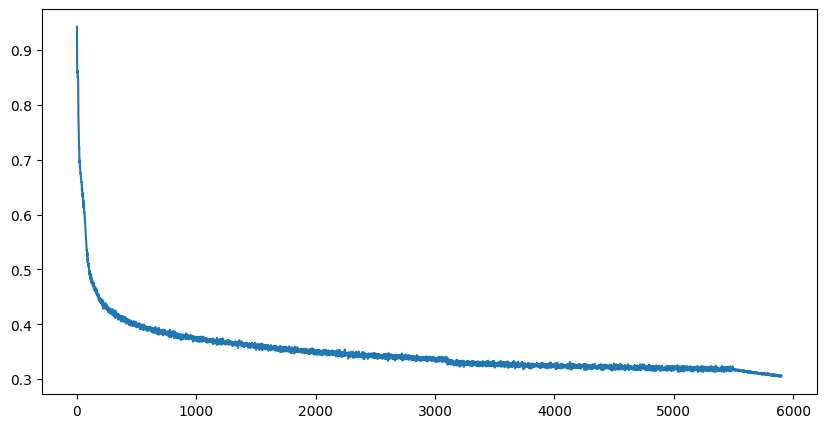

In [25]:
import  matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))

plt.plot(train_losses[:] , label="train")



c:\disque d\ai_stuff\projects\pytorchtraining\pytorch_training\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\disque d\ai_stuff\projects\pytorchtraining\pytorch_training\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


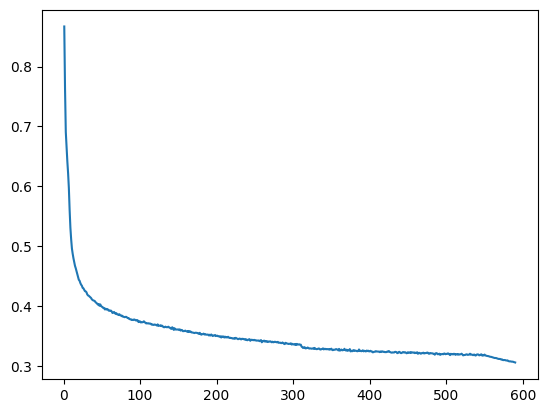

In [26]:
loss_window_size = 10
smoother_train_losses = [np.mean(train_losses[max(0, i - loss_window_size):i]) for i in range(len(train_losses)-2500 , len(train_losses ) , loss_window_size )]
plt.plot(smoother_train_losses , label="train smoothed")

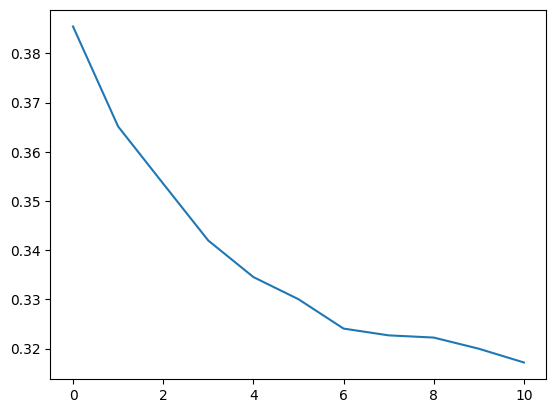

In [27]:
plt.plot(val_losses[-5000:] , label="val")

In [ ]:
with torch.inference_mode():

    x = next(iter(train_loader)).to(device)
    mask_indexes = model._make_mask(x)
    out , target = model(x , mask_indexes)

    out = out.reshape(out.shape[0] , out.shape[1] , model.c_dim , model.slice_size)
    batch_index = torch.arange(x.shape[0],device=x.device).unsqueeze(1).expand(x.shape[0] , mask_indexes.shape[1])
    out = out[batch_index , mask_indexes]
    target = target[batch_index , mask_indexes]
    loss =  loss_f(out , target).item()


0.3605722486972809


In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

# -------------------- EMBEDDING --------------------
class Vit_EEG_Embedding(nn.Module):
    def __init__(self, nb_tokens, c_dim=129, t_dim=200, slice_size=10,
                 target_c_dim=129, target_t_dim=10, emb_dim=512):
        super().__init__()
        self.slice_size = slice_size
        self.c_dim = c_dim
        self.nb_tokens = nb_tokens

        # axis-wise projections
        self.time_projection    = nn.Linear(slice_size,  target_t_dim)  # (..., slice) -> (..., Dt)
        self.channel_projection = nn.Linear(c_dim,       target_c_dim)  # (..., C)     -> (..., Dc)

        # axis embeddings (added before flatten)
        self.time_positional_emb    = nn.Parameter(torch.zeros(1, 1, 1, target_t_dim))
        self.channel_positional_emb = nn.Parameter(torch.zeros(1, 1, target_c_dim, 1))

        # token projection (Dc*Dt -> D)
        self.token_projection = nn.Linear(target_c_dim * target_t_dim, emb_dim)

        # token positional embedding (added in D space)
        self.token_positional_emb = nn.Parameter(torch.zeros(1, nb_tokens, emb_dim))

    def _targets_from_raw(self, x: Tensor) -> Tensor:
        # x: (B, C, T) -> targets per token: (B, N, C*slice)
        B, C, T = x.shape
        N = T // self.slice_size
        return x.view(B, C, N, self.slice_size).permute(0, 2, 1, 3).reshape(B, N, C * self.slice_size)

    def forward(self, x: Tensor, add_token_pos: bool = True, return_targets: bool = False):
        """
        Returns token features before/after adding token positional embeddings.
        x: (B, C, T) with T % slice_size == 0
        """
        B, C, T = x.shape
        assert T % self.slice_size == 0, "T must be divisible by slice_size"
        N = T // self.slice_size

        # (B, C, T) -> (B, N, C, slice)
        x_slices = x.view(B, C, N, self.slice_size).permute(0, 2, 1, 3)

        # project time then channels -> (B, N, Dc, Dt)
        xt = self.time_projection(x_slices)                 # (B, N, C, Dt)
        xt = xt.permute(0, 1, 3, 2)                         # (B, N, Dt, C)
        xt = self.channel_projection(xt)                    # (B, N, Dt, Dc)
        xt = xt.permute(0, 1, 3, 2)                         # (B, N, Dc, Dt)

        # add axis embeddings before flatten
        xt = xt + self.time_positional_emb + self.channel_positional_emb

        # flatten and map to D
        tokens = self.token_projection(xt.reshape(B, N, -1))  # (B, N, D)

        # token positional (in D space)
        if add_token_pos:
            tokens = tokens + self.token_positional_emb[:, :N, :]

        if return_targets:
            targets = self._targets_from_raw(x)  # (B, N, C*slice)
            return tokens, targets
        return tokens


# -------------------- ENCODER + MAE --------------------
class Vit_EEG_Encoder(nn.Module):
    def __init__(self, c_dim=129, t_dim=200, slice_size=10, emb_dim=512, nhead=8,
                 num_layers=6, ff_mult=4, dropout=0.1):
        super().__init__()
        assert t_dim % slice_size == 0
        assert emb_dim % nhead == 0, "emb_dim must be divisible by nhead"

        self.c_dim = c_dim
        self.t_dim = t_dim
        self.slice_size = slice_size
        self.nb_tokens = t_dim // slice_size
        self.emb_dim = emb_dim

        self.embedding = Vit_EEG_Embedding(
            nb_tokens=self.nb_tokens, c_dim=c_dim, t_dim=t_dim,
            slice_size=slice_size, target_c_dim=c_dim, target_t_dim=slice_size,
            emb_dim=emb_dim
        )

        layer = nn.TransformerEncoderLayer(
            d_model=emb_dim, nhead=nhead,
            dim_feedforward=ff_mult * emb_dim,
            dropout=dropout, activation="gelu",
            batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers, enable_nested_tensor=False)

        # MAE bits
        self.mask_token = nn.Parameter(torch.zeros(emb_dim))
        nn.init.normal_(self.mask_token, std=0.02)

        # decoder: predict raw slice (C*slice) per token
        self.decoder = nn.Sequential(
            nn.Linear(emb_dim, 2 * emb_dim),
            nn.GELU(),
            nn.Linear(2 * emb_dim, c_dim * slice_size)
        )

    @torch.no_grad()
    def _make_mask(self, B: int, ratio: float, device=None) -> torch.BoolTensor:
        N = self.nb_tokens
        k = max(1, int(ratio * N))
        mask = torch.zeros(B, N, dtype=torch.bool, device=device)
        for b in range(B):
            idx = torch.randperm(N, device=device)[:k]
            mask[b, idx] = True
        return mask

    def forward(self, x: Tensor, mask: torch.BoolTensor | None = None, return_pred: bool = False):
        """
        x: (B, C, T)
        mask: (B, N) True -> masked; if None, no masking (e.g., finetune/inference)
        returns:
          - if return_pred: (enc_out, pred, targets, mask)
          - else: enc_out
        """
        # tokens BEFORE adding token positional, plus raw targets for MAE
        tokens_prepos, targets = self.embedding(x, add_token_pos=False, return_targets=True)  # (B, N, D), (B, N, C*slice)
        pos = self.embedding.token_positional_emb[:, :tokens_prepos.size(1), :]               # (1, N, D)

        z = tokens_prepos
        if mask is not None:
            z = z.clone()
            z[mask] = self.mask_token  # replace content with learnable mask vector

        z = z + pos                          # add token positions (masked + unmasked)
        enc_out = self.encoder(z)            # (B, N, D)

        if not return_pred:
            return enc_out

        pred = self.decoder(enc_out)         # (B, N, C*slice)
        return enc_out, pred, targets, mask
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

def save_checkpoint(model, optimizer, epoch, step, path="checkpoint.pt"):
    torch.save({
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "epoch": epoch,
        "step": step,
    }, path)
    print(f"💾 Saved checkpoint at step {step:,} (epoch {epoch}) -> {path}")

def load_checkpoint(model, optimizer, path="checkpoint.pt", device="cpu"):
    if not os.path.exists(path):
        print("⚠️ No checkpoint found, starting fresh")
        return 0, 0
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    print(f"✅ Resumed from {path} at step {ckpt['step']:,} (epoch {ckpt['epoch']})")
    return ckpt["epoch"], ckpt["step"]

def _masked_nrmse_loss(pred, targets, mask, eps=1e-6):
    pred_m = pred[mask]
    targ_m = targets[mask]
    var = targ_m.var(dim=1, keepdim=True, unbiased=False).clamp_min(eps)
    return ((pred_m - targ_m) ** 2 / var).mean()

# -------------------- TRAIN LOOP --------------------
def pretrain_epoch(model, train_loader, optimizer, device,
                   epoch, start_step=0, mask_ratio=0.7,
                   grad_clip=None, log_interval=1000, save_interval=10_000,
                   ckpt_path="checkpoint.pt"):
    model.train()
    loss_sum, n_batches = 0.0, 0
    curr_loss , curr_n_batches = 0.0, 0
    global_step = start_step

    for batch_idx, x in enumerate(tqdm(train_loader, desc=f"train e{epoch}")):
        if isinstance(x, (tuple, list)):
            x = x[0]
            
        x = x.to(device, dtype=torch.float32)

        B = x.size(0)
        mask = model._make_mask(B, mask_ratio, device=x.device)

        optimizer.zero_grad(set_to_none=True)
        _, pred, targets, m = model(x, mask=mask, return_pred=True)

        loss = _masked_nrmse_loss(pred, targets, m)
        loss.backward()
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        # update meters
        loss_val = float(loss.detach().cpu().item())
        loss_sum += loss_val
        n_batches += 1
        curr_loss += loss_val
        curr_n_batches += 1
        global_step += 1

        if (batch_idx + 1) % log_interval == 0:
            avg = curr_loss / curr_n_batches
            curr_loss = 0.0
            curr_n_batches = 0
            raw_mse = float(F.mse_loss(pred[m], targets[m]).detach().cpu().item())
            print(f"[train] step {global_step:,} | loss {loss_val:.6f} | avg {avg:.6f} | raw_mse {raw_mse:.2e}")

        if global_step % save_interval == 0:
            save_checkpoint(model, optimizer, epoch, global_step, path=ckpt_path)

    return loss_sum / max(1, n_batches), global_step

# -------------------- EVAL LOOP --------------------
@torch.no_grad()
def eval_epoch(model, loader, device, mask_ratio=0.7, log_interval=1000, tag="val", fixed_mask=True):
    model.eval()
    loss_sum, n_batches = 0.0, 0
    curr_loss , curr_n_batches = 0.0, 0
    for batch_idx, x in enumerate(tqdm(loader, desc=tag)):
        if isinstance(x, (tuple, list)):
            x = x[0]
        x = x.to(device, dtype=torch.float32)

        B = x.size(0)
        if fixed_mask:
            N = model.nb_tokens
            k = max(1, int(mask_ratio * N))
            mask = torch.zeros(B, N, dtype=torch.bool, device=x.device)
            mask[:, :k] = True
        else:
            mask = model._make_mask(B, mask_ratio, device=x.device)

        _, pred, targets, m = model(x, mask=mask, return_pred=True)
        loss = _masked_nrmse_loss(pred, targets, m)

        loss_val = float(loss.detach().cpu().item())
        loss_sum += loss_val
        n_batches += 1
        curr_loss += loss_val
        curr_n_batches += 1

        if (batch_idx + 1) % log_interval == 0:
            avg = curr_loss / curr_n_batches
            curr_loss = 0.0
            curr_n_batches = 0
            raw_mse = float(F.mse_loss(pred[m], targets[m]).detach().cpu().item())
            print(f"[{tag}] batch {batch_idx+1} | loss {loss_val:.6f} | avg {avg:.6f} | raw_mse {raw_mse:.2e}")

    return loss_sum / max(1, n_batches)

# -------------------- FULL TRAIN DRIVER --------------------
def pretrain(model, train_loader, val_loader, test_loader, optimizer, device,
             epochs=10, mask_ratio=0.7, grad_clip=1.0, log_interval=100,
             save_interval=10_000, ckpt_path="checkpoint.pt"):
    best_val = float("inf")

    # resume if checkpoint exists
    start_epoch, global_step = load_checkpoint(model, optimizer, ckpt_path, device=device)

    for epoch in range(start_epoch+1, epochs + 1):
        print(f"\n=== Epoch {epoch}/{epochs} ===")
        tr, global_step = pretrain_epoch(model, train_loader, optimizer, device,
                                         epoch, start_step=global_step,
                                         mask_ratio=mask_ratio,
                                         grad_clip=grad_clip,
                                         log_interval=log_interval,
                                         save_interval=save_interval,
                                         ckpt_path=ckpt_path)
        va = eval_epoch(model, val_loader, device, mask_ratio=mask_ratio,
                        log_interval=log_interval, tag="val")
        print(f"epoch {epoch:02d} | train {tr:.4f} | val {va:.4f}")

        if va < best_val:
            best_val = va
            print(f"  ↳ new best val: {best_val:.4f}")
            # also save best model
            save_checkpoint(model, optimizer, epoch, global_step, path="best_"+ckpt_path)

    te = eval_epoch(model, test_loader, device, mask_ratio=mask_ratio,
                    log_interval=log_interval, tag="test")
    print(f"\n==> test loss: {te:.4f}")
    return best_val, te




In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Vit_EEG_Encoder(
    c_dim=129,
    t_dim=200,
    slice_size=10,
    emb_dim=512,
    nhead=8,
    num_layers=8
).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=0.05
)

# run training with checkpointing
best_val, test_loss = pretrain(
    model,
    train_loader,
    val_loader,
    test_loader,
    optimizer,
    device,
    epochs=20,
    mask_ratio=0.3,
    grad_clip=1.0,
    log_interval=1000,
    save_interval=10_000,          # save every 10k steps
    ckpt_path="checkpoint.pt"      # checkpoint file
)


✅ Resumed from checkpoint.pt at step 70,000 (epoch 2)

=== Epoch 3/20 ===


train e3:   1%|▏         | 1001/68061 [02:26<2:40:23,  6.97it/s]

[train] step 71,000 | loss 0.177026 | avg 0.145068 | raw_mse 1.83e-06


train e3:   3%|▎         | 2001/68061 [04:57<2:55:02,  6.29it/s]

[train] step 72,000 | loss 0.104785 | avg 0.147324 | raw_mse 2.22e-06


train e3:   4%|▍         | 3001/68061 [07:34<2:48:56,  6.42it/s]

[train] step 73,000 | loss 0.125967 | avg 0.145808 | raw_mse 8.11e-06


train e3:   6%|▌         | 4001/68061 [10:11<2:57:46,  6.01it/s]

[train] step 74,000 | loss 0.152168 | avg 0.147062 | raw_mse 8.19e-06


train e3:   7%|▋         | 5001/68061 [12:48<2:44:45,  6.38it/s]

[train] step 75,000 | loss 0.110713 | avg 0.143594 | raw_mse 7.97e-06


train e3:   9%|▉         | 6001/68061 [15:26<2:39:10,  6.50it/s]

[train] step 76,000 | loss 0.119568 | avg 0.144321 | raw_mse 3.22e-06


train e3:  10%|█         | 7000/68061 [18:10<3:18:26,  5.13it/s]

[train] step 77,000 | loss 0.149486 | avg 0.145632 | raw_mse 9.58e-06


train e3:  12%|█▏        | 8000/68061 [21:26<3:02:58,  5.47it/s]

[train] step 78,000 | loss 0.104593 | avg 0.145571 | raw_mse 1.52e-06


train e3:  13%|█▎        | 9000/68061 [24:45<3:12:52,  5.10it/s]

[train] step 79,000 | loss 0.127671 | avg 0.143587 | raw_mse 4.85e-06


train e3:  15%|█▍        | 9999/68061 [27:59<3:10:02,  5.09it/s]

[train] step 80,000 | loss 0.162697 | avg 0.146029 | raw_mse 5.58e-06


train e3:  15%|█▍        | 10000/68061 [28:00<5:03:01,  3.19it/s]

💾 Saved checkpoint at step 80,000 (epoch 3) -> checkpoint.pt


train e3:  16%|█▌        | 11000/68061 [31:13<3:37:03,  4.38it/s]

[train] step 81,000 | loss 0.145672 | avg 0.143305 | raw_mse 5.92e-06


train e3:  18%|█▊        | 12000/68061 [34:29<2:54:12,  5.36it/s]

[train] step 82,000 | loss 0.211408 | avg 0.143768 | raw_mse 6.39e-06


train e3:  19%|█▉        | 13001/68061 [37:30<2:39:54,  5.74it/s]

[train] step 83,000 | loss 0.211233 | avg 0.145149 | raw_mse 7.06e-06


train e3:  21%|██        | 14001/68061 [40:26<2:30:25,  5.99it/s]

[train] step 84,000 | loss 0.134917 | avg 0.143524 | raw_mse 5.58e-06


train e3:  22%|██▏       | 15001/68061 [43:19<2:31:43,  5.83it/s]

[train] step 85,000 | loss 0.198306 | avg 0.146326 | raw_mse 1.20e-05


train e3:  24%|██▎       | 16000/68061 [46:15<2:30:14,  5.78it/s]

[train] step 86,000 | loss 0.149110 | avg 0.144572 | raw_mse 7.94e-06


train e3:  25%|██▍       | 17001/68061 [49:07<2:10:55,  6.50it/s]

[train] step 87,000 | loss 0.174316 | avg 0.145796 | raw_mse 3.64e-06


train e3:  25%|██▍       | 17012/68061 [49:09<2:27:31,  5.77it/s]


KeyboardInterrupt: 

In [21]:
torch.save(model.state_dict(), "vit_eeg_encoder.pt")

<All keys matched successfully>

# Merging Encoder and Decoder


## version 1

In [33]:
class Vit_EEG_Embedding(nn.Module):
    def __init__(self, nb_tokens, c_dim=129, t_dim=200, slice_size=10,
                target_c_dim=64, target_t_dim=6, emb_dim=512):
        super().__init__()

        self.nb_tokens = nb_tokens
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.slice_size = slice_size
        self.target_c_dim = target_c_dim
        self.target_t_dim = target_t_dim
        self.emb_dim = emb_dim

        self.time_projection = nn.Linear(self.slice_size, self.target_t_dim)
        self.channel_projection = nn.Linear(self.c_dim, self.target_c_dim)

        self.time_positional_emb = nn.Parameter(
            torch.zeros(1, 1, 1, self.target_t_dim)
        )
        self.channel_positional_emb = nn.Parameter(
            torch.zeros(1, 1, self.target_c_dim, 1)
        )

        self.token_projection = nn.Linear(
            self.target_c_dim * self.target_t_dim, self.emb_dim
        )
        self.token_positional_emb = nn.Parameter(
            torch.zeros(self.nb_tokens, self.emb_dim)
        )

        self.mask_token = nn.Parameter(
            torch.zeros(1, 1, self.emb_dim)
        )

        self.pre_norm = nn.LayerNorm(self.emb_dim)
        nn.init.xavier_uniform_(self.token_positional_emb)



    def zscore_bct(self ,x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
        """
        Per-window, per-channel z-score along time: (B, C, T) -> (B, C, T).
        """
        if not x.is_floating_point():
            x = x.float()
        mu = x.mean(dim=2, keepdim=True)
        sigma = x.std(dim=2, keepdim=True, unbiased=False).clamp_min(eps)
        return (x - mu) / sigma

    def patching (self,x : Tensor):
        # x starting shape (B , C , T)
        x = x.reshape(x.shape[0] , x.shape[1] ,   x.shape[2] // self.slice_size , self.slice_size)
        x = x.permute(0 , 2 , 1 , 3)
        return x
    def forward(self,x ,mask_index =  None):
        
        # x starting shape (B , C , T)
        # normilizing
        x = self.zscore_bct(x)
        x = self.patching(x)
        if mask_index is not None:
            origin = x.clone()
        # x (B ,N , C , slice)  N = T // slice
        x = self.time_projection(x)
        # x (B , N , C , Target_t_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_t_dim , C)
        x = self.channel_projection(x)
        # x (B , N , Target_t_dim , Target_c_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_c_dim , Target_t_dim)
        x = x + self.time_positional_emb
        x = x + self.channel_positional_emb
        # Flatten 
        x= x.reshape(x.shape[0] , x.shape[1] , x.shape[2] * x.shape[3])
        # x (B , N , Target_c_dim * Target_t_dim)
        x = self.token_projection(x)
        if mask_index is not None:
            r = mask_index.shape[1]
            batch_index = torch.arange(x.shape[0],device=x.device).unsqueeze(1).expand(x.shape[0] , r)
            x[batch_index , mask_index ] = self.mask_token.expand(x.shape[0] , r , x.shape[2])
        # x (B , N , emb_dim)
        x = x + self.token_positional_emb
        x = self.pre_norm(x)
        if mask_index is not None:
            return x , origin
        return x , None
class Vit_EEG_Encoder(nn.Module):
    def __init__(self,c_dim = 129  ,  t_dim = 200   , slice_size = 10 , emb_dim = 512 , nhead = 8 ,  nb_layers = 12  , target_c_dim = 64 , target_t_dim = 6 ):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.emb_dim = emb_dim
        self.slice_size = slice_size
        assert self.t_dim % self.slice_size == 0
        self.nb_tokens = self.t_dim // self.slice_size
        self.target_c_dim = target_c_dim
        self.target_t_dim = target_t_dim
        self.nhead = nhead
        self.nb_layers = nb_layers
        self.embedding = Vit_EEG_Embedding(nb_tokens=self.nb_tokens , c_dim = self.c_dim , t_dim = self.t_dim , slice_size = self.slice_size,target_c_dim=self.target_c_dim ,target_t_dim=self.target_t_dim  , emb_dim = self.emb_dim )
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=self.emb_dim , nhead=self.nhead , dim_feedforward=emb_dim*4 , batch_first=True , norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer , num_layers=self.nb_layers ,enable_nested_tensor=False)
        self.decoder = nn.Sequential(
        nn.LayerNorm(emb_dim),
        nn.Linear(emb_dim, emb_dim * 4),
        nn.GELU(),
        nn.Linear(emb_dim * 4, self.c_dim * self.slice_size))
    def add_gaussian_noise(self,x, sigma=0.1):
        """
        Additive Gaussian noise.
        """
        return x + sigma * torch.randn_like(x)

    def _make_mask(self, x , mask_ratio=0.2):
        # x: (B, C, T)
        k = max(1, int(self.nb_tokens * mask_ratio))

        scores = torch.rand(x.shape[0] , self.nb_tokens , device=x.device)
        _ , masked_indexs = torch.topk(scores , k=k , dim=1)

        return   masked_indexs

    def extract_features(self,x):   
        x ,_= self.embedding(x)
        x = self.transformer_encoder(x)
        return x
    def forward(self,x  , mask_index =None):
        emb_x , targets=  self.embedding(x ,   mask_index)
        transformed = self.transformer_encoder(emb_x)
        result = self.decoder(transformed)
        if targets is not None:
            return result , targets
        return result
        

In [34]:

model = Vit_EEG_Encoder().to(device)

save_path = "last_checkpoint.pt"
if os.path.isfile(save_path):
    ckpt = torch.load(save_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    start_epoch = ckpt.get("epoch", 0)
    start_it = ckpt.get("it_in_epoch", 0)
    global_steps = ckpt.get("steps", 0)
    train_losses = ckpt.get("train_losses", [])
    val_losses = ckpt.get("val_losses", [])


In [116]:
class Vit_EEG_RT_Decoder(nn.Module):
    def __init__(self, encoder  ,c_dim=129, t_dim=200  ):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.encoder =encoder
        self.regressor = nn.Sequential(
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
        )


    def forward(self, x):
        x = self.encoder.extract_features(x)
        x= x.mean(dim=1)
        x = self.regressor(x)
        return x
    

In [117]:
rt_regressor_model = Vit_EEG_RT_Decoder(model).to(device)

optimizer = torch.optim.AdamW([
    {"params": rt_regressor_model.encoder.parameters(), "lr": 1e-5},   # small lr
    {"params": rt_regressor_model.regressor.parameters(), "lr": 1e-4}  # normal lr
], weight_decay=0.05)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
loss_f = nn.MSELoss()


In [118]:


print("before training")
print(f"train nRMSE : {nrmse_over_data(rt_regressor_model , train_ccd_dataloader ,device)}")
print(f"test nRMSE : {nrmse_over_data(rt_regressor_model , test_ccd_dataloader ,device)}")
print(f"val nRMSE : {nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)}")

epochs = 30
for epoch in range(epochs):
    rt_regressor_model.train()
    cumulative_loss = 0
    for  batch in tqdm(train_ccd_dataloader):
        x , y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = rt_regressor_model(x)
        loss = loss_f(y_pred.squeeze(-1) , y)
        cumulative_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    nrmse_train = nrmse_over_data(rt_regressor_model , train_ccd_dataloader ,device)
    nrmse_val = nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)
    scheduler1.step(nrmse_val)
    if lr!= optimizer.param_groups[0]['lr']:
        print(f"new lr : {optimizer.param_groups[0]['lr']}")
        lr = optimizer.param_groups[0]['lr']

    print(f"train epoch : {epoch +1} , loss : {cumulative_loss/len(train_ccd_dataloader)} , nRMSE : {nrmse_train}")
    print(f"val epoch : {epoch +1} , nRMSE : {nrmse_val}")
    rt_regressor_model.eval()
    with torch.inference_mode():
        cumulative_loss = 0
        for batch in tqdm(test_ccd_dataloader):
            x , y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred = rt_regressor_model(x)
            loss = loss_f(y_pred.squeeze(-1) , y)
            cumulative_loss += loss.item()
        nrmse_over_test = nrmse_over_data(rt_regressor_model , test_ccd_dataloader ,device)
        print(f"test epoch : {epoch +1} , loss : {cumulative_loss/len(test_ccd_dataloader)} , nRMSE : {nrmse_over_test}")
    






before training
train nRMSE : 4.317117803763316
test nRMSE : 4.545596083566749
val nRMSE : 4.436107194537155


100%|██████████| 265/265 [00:10<00:00, 25.80it/s]


new lr : 1e-05
train epoch : 1 , loss : 0.3477277384895199 , nRMSE : 0.9827244811715338
val epoch : 1 , nRMSE : 1.0387631450425168


100%|██████████| 35/35 [00:01<00:00, 33.80it/s]


KeyboardInterrupt: 

In [119]:

final_r5_test =pairs_to_fast_loading_shards([] ,"final_r5_test" , shard_size)
r5_test_ccd_data = EEGDataset(final_r5_test ,  shard_size)

r5_test_ccd_dataloader = DataLoader(r5_test_ccd_data , batch_size=batch_size , shuffle=False )
print(f"r5 test nRMSE : {nrmse_over_data(rt_regressor_model , r5_test_ccd_dataloader,device)}")

r5 test nRMSE : 1.1583635492097804


In [95]:

model = Vit_EEG_Encoder().to(device)

save_path = "last_checkpoint.pt"
if os.path.isfile(save_path):
    ckpt = torch.load(save_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    start_epoch = ckpt.get("epoch", 0)
    start_it = ckpt.get("it_in_epoch", 0)
    global_steps = ckpt.get("steps", 0)
    train_losses = ckpt.get("train_losses", [])
    val_losses = ckpt.get("val_losses", [])


In [96]:
import torch
import torch.nn as nn

class AttentionPool(nn.Module):
    def __init__(self, dim, num_heads=4):
        super().__init__()
        self.query = nn.Parameter(torch.randn(1, 1, dim))  # learnable query
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x):
        # x: (B, N, dim)
        B = x.size(0)
        q = self.query.expand(B, -1, -1)  # (B, 1, dim)
        out, _ = self.attn(q, x, x)       # attend over all tokens
        return out.squeeze(1)             # (B, dim)
class Vit_EEG_RT_Decoder(nn.Module):
    def __init__(self, encoder, c_dim=129, t_dim=200 , fine_tune_encoder = False):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.encoder = encoder
        if fine_tune_encoder :
            for param in self.encoder.parameters():
                param.requires_grad = True
        else:
            for param in self.encoder.parameters():
                param.requires_grad = False

        self.pool = AttentionPool(512, num_heads=4)

        self.regressor = nn.Sequential(
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        x = self.encoder.extract_features(x)  # (B, N, 512)
        x = self.pool(x)                      # (B, 512)
        x = self.regressor(x)                 # (B, 1)
        return x


In [97]:
rt_regressor_model = Vit_EEG_RT_Decoder(model , fine_tune_encoder=True).to(device)


optimizer = torch.optim.AdamW([
    {"params": rt_regressor_model.encoder.parameters(), "lr": 1e-4},    
    {"params": rt_regressor_model.pool.parameters(), "lr": 1e-4},
    {"params": rt_regressor_model.regressor.parameters(), "lr": 1e-4},
], weight_decay=0.05)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
loss_f = nn.SmoothL1Loss(beta=0.4)  


In [65]:
optimizer = torch.optim.AdamW([
    {"params": rt_regressor_model.encoder.parameters(), "lr": 7e-5},    
    {"params": rt_regressor_model.pool.parameters(), "lr": 7e-5},
    {"params": rt_regressor_model.regressor.parameters(), "lr": 7e-5},
], weight_decay=0.05)



In [98]:


print("before training")
#print(f"train nRMSE : {nrmse_over_data(rt_regressor_model , train_ccd_dataloader ,device)}")
#print(f"test nRMSE : {nrmse_over_data(rt_regressor_model , test_ccd_dataloader ,device)}")
#print(f"val nRMSE : {nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)}")

best_model_path = "best_model.pt"
best_rnmse_path = "best_rnmse.pt"
best_rnmse = 1000
if os.path.exists(best_rnmse_path):
    best_rnmse = float(torch.load(best_rnmse_path))
    print(f"best model loaded with rnmse : {best_rnmse}")


epochs = 2
for epoch in range(epochs):
    rt_regressor_model.train()
    cumulative_loss = 0
    for  batch in tqdm(train_ccd_dataloader):
        x , y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = rt_regressor_model(x)
        loss = loss_f(y_pred.squeeze(-1) , y)
        cumulative_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #nrmse_train = nrmse_over_data(rt_regressor_model , train_ccd_dataloader ,device)
    #nrmse_val = nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)
    #scheduler1.step(nrmse_val)


    #print(f"train epoch : {epoch +1} , loss : {cumulative_loss/len(train_ccd_dataloader)} , nRMSE : {nrmse_train}")
    #print(f"val epoch : {epoch +1} , nRMSE : {nrmse_val}")
    rt_regressor_model.eval()
    with torch.inference_mode():
        cumulative_loss = 0
        for batch in tqdm(test_ccd_dataloader):
            x , y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred = rt_regressor_model(x)
            loss = loss_f(y_pred.squeeze(-1) , y)
            cumulative_loss += loss.item()
        nrmse_over_test = nrmse_over_data(rt_regressor_model , test_ccd_dataloader ,device)
        print(f"test epoch : {epoch +1} , loss : {cumulative_loss/len(test_ccd_dataloader)} , nRMSE : {nrmse_over_test}")
        if nrmse_over_test < best_rnmse:
            print(f"new best achieved nrmse {nrmse_over_test}")
            best_rnmse = nrmse_over_test
            torch.save(rt_regressor_model.state_dict(), best_model_path)
            torch.save(best_rnmse, best_rnmse_path)






before training
best model loaded with rnmse : 0.9513838748892413


  0%|          | 0/2101 [00:00<?, ?it/s]

 45%|████▍     | 938/2101 [00:50<01:02, 18.60it/s]


KeyboardInterrupt: 

In [67]:
if os.path.exists(best_model_path):
    rt_regressor_model = Vit_EEG_RT_Decoder(model , fine_tune_encoder=False).to(device)
    rt_regressor_model.load_state_dict(torch.load(best_model_path))
    rt_regressor_model.eval()
    print("best model loaded")
else:
    print("best model not found")
    raise Exception("best model not found")
final_r5_test =pairs_to_fast_loading_shards([] ,"final_r5_test" , shard_size)
r5_test_ccd_data = EEGDataset(final_r5_test ,  shard_size)

r5_test_ccd_dataloader = DataLoader(r5_test_ccd_data , batch_size=batch_size , shuffle=False )
print(f"r5 test nRMSE : {nrmse_over_data(rt_regressor_model , r5_test_ccd_dataloader,device)}")

best model loaded
r5 test nRMSE : 0.9530603590279609


## over fitting or r5


In [53]:
if os.path.exists(best_model_path):
    rt_regressor_model = Vit_EEG_RT_Decoder(model , fine_tune_encoder=True).to(device)
    rt_regressor_model.load_state_dict(torch.load(best_model_path))
    optimizer = torch.optim.AdamW([
        {"params": rt_regressor_model.encoder.parameters(), "lr": 1e-5},    
        {"params": rt_regressor_model.temporal_conv.parameters(), "lr": 1e-4},
        {"params": rt_regressor_model.pool.parameters(), "lr": 1e-4},
        {"params": rt_regressor_model.regressor.parameters(), "lr": 1e-4},
    ], weight_decay=0.05)
    scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
    loss_f = nn.MSELoss()
    print("best model loaded")
else:
    print("best model not found")
    raise Exception("best model not found")

epochs = 10
for epoch in range(epochs):
    rt_regressor_model.train()
    cumulative_loss = 0
    for  batch in tqdm(r5_test_ccd_dataloader):
        
        x , y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = rt_regressor_model(x)
        loss = loss_f(y_pred.squeeze(-1) , y)
        cumulative_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    nrmse_r5 = nrmse_over_data(rt_regressor_model , r5_test_ccd_dataloader ,device)
    scheduler1.step(nrmse_r5)
    print(f"r5 epoch : {epoch +1} , loss : {cumulative_loss/len(r5_test_ccd_dataloader)} , nRMSE : {nrmse_r5}")


best model loaded


100%|██████████| 474/474 [00:19<00:00, 24.50it/s]


r5 epoch : 1 , loss : 0.15343870099964022 , nRMSE : 0.9352530453511047


100%|██████████| 474/474 [00:19<00:00, 24.68it/s]


r5 epoch : 2 , loss : 0.14974657910628408 , nRMSE : 0.9239035630424651


100%|██████████| 474/474 [00:18<00:00, 25.21it/s]


r5 epoch : 3 , loss : 0.14491455839310266 , nRMSE : 0.9153584355400755


100%|██████████| 474/474 [00:18<00:00, 25.18it/s]


r5 epoch : 4 , loss : 0.14319177399456248 , nRMSE : 0.9058914321551959


100%|██████████| 474/474 [00:18<00:00, 25.30it/s]


r5 epoch : 5 , loss : 0.13980630712135683 , nRMSE : 0.8916456415217986


100%|██████████| 474/474 [00:18<00:00, 24.98it/s]


r5 epoch : 6 , loss : 0.13682088624481661 , nRMSE : 0.8811182185052867


100%|██████████| 474/474 [00:18<00:00, 25.20it/s]


r5 epoch : 7 , loss : 0.13176102394764685 , nRMSE : 0.8736697282149481


100%|██████████| 474/474 [00:19<00:00, 24.66it/s]


r5 epoch : 8 , loss : 0.12840041065124896 , nRMSE : 0.8598803175685144


100%|██████████| 474/474 [00:20<00:00, 23.38it/s]


r5 epoch : 9 , loss : 0.12531180846414486 , nRMSE : 0.8356834321556025


100%|██████████| 474/474 [00:21<00:00, 22.52it/s]


r5 epoch : 10 , loss : 0.1220434103711245 , nRMSE : 0.8287744737426552


## version 2


In [24]:
class Vit_EEG_Embedding(nn.Module):
    def __init__(self, nb_tokens, c_dim=129, t_dim=200, slice_size=10,
                target_c_dim=64, target_t_dim=6, emb_dim=512):
        super().__init__()

        self.nb_tokens = nb_tokens
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.slice_size = slice_size
        self.target_c_dim = target_c_dim
        self.target_t_dim = target_t_dim
        self.emb_dim = emb_dim

        self.time_projection = nn.Linear(self.slice_size, self.target_t_dim)
        self.channel_projection = nn.Linear(self.c_dim, self.target_c_dim)

        self.time_positional_emb = nn.Parameter(
            torch.zeros(1, 1, 1, self.target_t_dim)
        )
        self.channel_positional_emb = nn.Parameter(
            torch.zeros(1, 1, self.target_c_dim, 1)
        )

        self.token_projection = nn.Linear(
            self.target_c_dim * self.target_t_dim, self.emb_dim
        )
        self.token_positional_emb = nn.Parameter(
            torch.zeros(self.nb_tokens, self.emb_dim)
        )

        self.mask_token = nn.Parameter(
            torch.zeros(1, 1, self.emb_dim)
        )

        self.pre_norm = nn.LayerNorm(self.emb_dim)
        nn.init.xavier_uniform_(self.token_positional_emb)



    def zscore_bct(self ,x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
        """
        Per-window, per-channel z-score along time: (B, C, T) -> (B, C, T).
        """
        if not x.is_floating_point():
            x = x.float()
        mu = x.mean(dim=2, keepdim=True)
        sigma = x.std(dim=2, keepdim=True, unbiased=False).clamp_min(eps)
        return (x - mu) / sigma

    def patching (self,x : Tensor):
        # x starting shape (B , C , T)
        x = x.reshape(x.shape[0] , x.shape[1] ,   x.shape[2] // self.slice_size , self.slice_size)
        x = x.permute(0 , 2 , 1 , 3)
        return x
    def forward(self,x ,mask_index =  None):
        
        # x starting shape (B , C , T)
        # normilizing
        x = self.zscore_bct(x)
        x = self.patching(x)
        if mask_index is not None:
            origin = x.clone()
        # x (B ,N , C , slice)  N = T // slice
        x = self.time_projection(x)
        # x (B , N , C , Target_t_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_t_dim , C)
        x = self.channel_projection(x)
        # x (B , N , Target_t_dim , Target_c_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_c_dim , Target_t_dim)
        x = x + self.time_positional_emb
        x = x + self.channel_positional_emb
        # Flatten 
        x= x.reshape(x.shape[0] , x.shape[1] , x.shape[2] * x.shape[3])
        # x (B , N , Target_c_dim * Target_t_dim)
        x = self.token_projection(x)
        if mask_index is not None:
            r = mask_index.shape[1]
            batch_index = torch.arange(x.shape[0],device=x.device).unsqueeze(1).expand(x.shape[0] , r)
            x[batch_index , mask_index ] = self.mask_token.expand(x.shape[0] , r , x.shape[2])
        # x (B , N , emb_dim)
        x = x + self.token_positional_emb
        x = self.pre_norm(x)
        if mask_index is not None:
            return x , origin
        return x , None
class Vit_EEG_Encoder(nn.Module):
    def __init__(self,c_dim = 129  ,  t_dim = 200   , slice_size = 10 , emb_dim = 512 , nhead = 8 ,  nb_layers = 12  , target_c_dim = 64 , target_t_dim = 6 ):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.emb_dim = emb_dim
        self.slice_size = slice_size
        assert self.t_dim % self.slice_size == 0
        self.nb_tokens = self.t_dim // self.slice_size
        self.target_c_dim = target_c_dim
        self.target_t_dim = target_t_dim
        self.nhead = nhead
        self.nb_layers = nb_layers
        self.embedding = Vit_EEG_Embedding(nb_tokens=self.nb_tokens , c_dim = self.c_dim , t_dim = self.t_dim , slice_size = self.slice_size,target_c_dim=self.target_c_dim ,target_t_dim=self.target_t_dim  , emb_dim = self.emb_dim )
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=self.emb_dim , nhead=self.nhead , dim_feedforward=emb_dim*4 , batch_first=True , norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer , num_layers=self.nb_layers ,enable_nested_tensor=False)
        self.decoder = nn.Sequential(
        nn.LayerNorm(emb_dim),
        nn.Linear(emb_dim, emb_dim * 4),
        nn.GELU(),
        nn.Linear(emb_dim * 4, self.c_dim * self.slice_size))
    def add_gaussian_noise(self,x, sigma=0.1):
        """
        Additive Gaussian noise.
        """
        return x + sigma * torch.randn_like(x)

    def _make_mask(self, x , mask_ratio=0.2):
        # x: (B, C, T)
        k = max(1, int(self.nb_tokens * mask_ratio))

        scores = torch.rand(x.shape[0] , self.nb_tokens , device=x.device)
        _ , masked_indexs = torch.topk(scores , k=k , dim=1)

        return   masked_indexs

    def extract_features(self,x):   
        x ,_= self.embedding(x)
        x = self.transformer_encoder(x)
        return x
    def forward(self,x  , mask_index =None):
        emb_x , targets=  self.embedding(x ,   mask_index)
        transformed = self.transformer_encoder(emb_x)
        result = self.decoder(transformed)
        if targets is not None:
            return result , targets
        return result

In [25]:

model = Vit_EEG_Encoder().to(device)

save_path = "history/last_checkpoint.pt"
if os.path.isfile(save_path):
    ckpt = torch.load(save_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    start_epoch = ckpt.get("epoch", 0)
    start_it = ckpt.get("it_in_epoch", 0)
    global_steps = ckpt.get("steps", 0)
    train_losses = ckpt.get("train_losses", [])
    val_losses = ckpt.get("val_losses", [])


In [37]:
import torch
import torch.nn as nn

class AttentionPool(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.query = nn.Parameter(torch.randn(1, 1, dim)) 
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x):
        # x: (B, N, dim)
        B = x.size(0)
        q = self.query.expand(B, -1, -1)  # (B, 1, dim)
        out, _ = self.attn(q, x, x)       # attend over all tokens (b 1 n )* (b n d) = (b 1 d)
        return out.squeeze(1)             # (B, dim)
    
class TemporalConv(nn.Module):

    def __init__(self, in_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding),
            nn.BatchNorm1d(in_channels),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding),
            nn.BatchNorm1d(in_channels),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

    def forward(self, x):
        x= x.transpose(1, 2)

        x = self.conv(x).squeeze(-1)
        return x

class Vit_EEG_RT_Decoder(nn.Module):
    def __init__(self, encoder, c_dim=129, t_dim=200 , fine_tune_encoder = False):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.encoder = encoder
        if fine_tune_encoder :
            for param in self.encoder.parameters():
                param.requires_grad = True
        else:
            for param in self.encoder.parameters():
                param.requires_grad = False

        self.pool = AttentionPool(512, num_heads=4)
        self.temporal_conv = TemporalConv(512, kernel_size=3, stride=1, padding=1)
        self.alpha = nn.Parameter(torch.randn(1 ,512))
        self.beta = nn.Parameter(torch.randn(1 ,512))
        self.regressor = nn.Sequential(
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
        )
    def merge(self, x, y):
        return self.alpha * x + self.beta * y
    def forward(self, x):
        
        x = self.encoder.extract_features(x)  # (B, N, 512)
        a = self.pool(x)                      # (B, 512)

        b = self.temporal_conv(x)             # (B, 512)
        x = self.merge(a, b)                  # (B, 512)
        x = self.regressor(x)                 # (B, 1)
        return x


In [86]:

model = Vit_EEG_Encoder().to(device)

save_path = "last_checkpoint.pt"
if os.path.isfile(save_path):
    ckpt = torch.load(save_path, map_location=device)
    model.load_state_dict(ckpt["model"])


rt_regressor_model = Vit_EEG_RT_Decoder(model , fine_tune_encoder=False).to(device)


optimizer = torch.optim.AdamW([
    #{"params": rt_regressor_model.encoder.parameters(), "lr": 8e-4},    
    {"params": rt_regressor_model.pool.parameters(), "lr": 2e-4},
    {"params": rt_regressor_model.regressor.parameters(), "lr": 2e-4},
    {"params": rt_regressor_model.temporal_conv.parameters(), "lr": 2e-4},
    {"params": rt_regressor_model.alpha, "lr": 2e-4},
    {"params": rt_regressor_model.beta, "lr": 2e-4},
], weight_decay=2e-2)

epochs = 8
total_steps= len(train_ccd_dataloader) * epochs
warmup_steps = 300
def lr_lambda(step):
    if step < warmup_steps:
        return step / max(1, warmup_steps) 
    progress = (step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1.0 + math.cos(math.pi * progress))  

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

loss_f = nn.MSELoss()  


print("before training")
"""print(f"train nRMSE : {nrmse_over_data(rt_regressor_model , train_ccd_dataloader ,device)}")
print(f"test nRMSE : {nrmse_over_data(rt_regressor_model , test_ccd_dataloader ,device)}")
print(f"val nRMSE : {nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)}")"""

best_model_path = "best_model.pt"
best_rnmse_path = "best_rnmse.pt"
best_rnmse = 1000
if os.path.exists(best_rnmse_path):
    best_rnmse = float(torch.load(best_rnmse_path))
    print(f"best model loaded with rnmse : {best_rnmse}")



for epoch in range(epochs):
    rt_regressor_model.train()
    cumulative_loss = 0
    for  batch in tqdm(train_ccd_dataloader):
        x , y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = rt_regressor_model(x)
        loss = loss_f(y_pred.squeeze(-1) , y)
        cumulative_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    #nrmse_train = nrmse_over_data(rt_regressor_model , train_ccd_dataloader ,device)
    #nrmse_val = nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)
    #scheduler1.step(nrmse_val)


    #print(f"train epoch : {epoch +1} , loss : {cumulative_loss/len(train_ccd_dataloader)} , nRMSE : {nrmse_train}")
    #print(f"val epoch : {epoch +1} , nRMSE : {nrmse_val}")
    rt_regressor_model.eval()
    with torch.inference_mode():
        cumulative_loss = 0
        for batch in tqdm(test_ccd_dataloader):
            x , y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred = rt_regressor_model(x)
            loss = loss_f(y_pred.squeeze(-1) , y)
            cumulative_loss += loss.item()
        nrmse_over_test = nrmse_over_data(rt_regressor_model , test_ccd_dataloader ,device)
        print(f"test epoch : {epoch +1} , loss : {cumulative_loss/len(test_ccd_dataloader)} , nRMSE : {nrmse_over_test}")
        if nrmse_over_test < best_rnmse:
            print(f"new best achieved nrmse {nrmse_over_test}")
            best_rnmse = nrmse_over_test
            torch.save(rt_regressor_model.state_dict(), best_model_path)
            torch.save(best_rnmse, best_rnmse_path)






before training
best model loaded with rnmse : 0.9269812395697398


100%|██████████| 134/134 [00:12<00:00, 10.80it/s]


test epoch : 1 , loss : 0.15313250376884616 , nRMSE : 0.9821708177380102


100%|██████████| 134/134 [00:14<00:00,  9.13it/s]


test epoch : 2 , loss : 0.15457140604284272 , nRMSE : 0.9865407311703274


100%|██████████| 134/134 [00:14<00:00,  9.05it/s]


test epoch : 3 , loss : 0.15258370673478538 , nRMSE : 0.9803930496263682


100%|██████████| 134/134 [00:11<00:00, 11.67it/s]


test epoch : 4 , loss : 0.14942933218692667 , nRMSE : 0.9701093624206569


100%|██████████| 134/134 [00:11<00:00, 11.59it/s]


test epoch : 5 , loss : 0.14915233010898776 , nRMSE : 0.969208045473612


100%|██████████| 134/134 [00:14<00:00,  9.00it/s]


test epoch : 6 , loss : 0.1497997663247941 , nRMSE : 0.9713476410004903


100%|██████████| 134/134 [00:14<00:00,  9.02it/s]


test epoch : 7 , loss : 0.14754700118592426 , nRMSE : 0.9638346275957183


100%|██████████| 134/134 [00:14<00:00,  9.17it/s]

test epoch : 8 , loss : 0.14819167740643024 , nRMSE : 0.9659677463988544


In [42]:

best_model_path = "best_model.pt"
best_rnmse_path = "best_rnmse.pt"
if os.path.exists(best_model_path):
    model = Vit_EEG_Encoder().to(device)
    rt_regressor_model = Vit_EEG_RT_Decoder(model , fine_tune_encoder=False).to(device)
    rt_regressor_model.load_state_dict(torch.load(best_model_path))
    rt_regressor_model.eval()
    print("best model loaded")
else:
    print("best model not found")
    raise Exception("best model not found")
r5_test_ccd_data = EEGDataset(shards_path ,  shard_size , "final_r5_test")

r5_test_ccd_dataloader = DataLoader(r5_test_ccd_data , batch_size=batch_size , shuffle=False )
print(f"r5 test nRMSE : {nrmse_over_data(rt_regressor_model , r5_test_ccd_dataloader,device)}")

best model loaded


100%|██████████| 1051/1051 [01:28<00:00, 11.93it/s]

r5 test nRMSE : 0.8898448906710629


## version 3


In [26]:
import torch
import torch.nn as nn
class Vit_EEG_Embedding(nn.Module):
    def __init__(self, nb_tokens, c_dim=129, t_dim=200, slice_size=10,
                target_c_dim=64, target_t_dim=6, emb_dim=512):
        super().__init__()

        self.nb_tokens = nb_tokens
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.slice_size = slice_size
        self.target_c_dim = target_c_dim
        self.target_t_dim = target_t_dim
        self.emb_dim = emb_dim

        self.time_projection = nn.Linear(self.slice_size, self.target_t_dim)
        self.channel_projection = nn.Linear(self.c_dim, self.target_c_dim)

        self.time_positional_emb = nn.Parameter(
            torch.zeros(1, 1, 1, self.target_t_dim)
        )
        self.channel_positional_emb = nn.Parameter(
            torch.zeros(1, 1, self.target_c_dim, 1)
        )

        self.token_projection = nn.Linear(
            self.target_c_dim * self.target_t_dim, self.emb_dim
        )
        self.token_positional_emb = nn.Parameter(
            torch.zeros(self.nb_tokens, self.emb_dim)
        )

        self.mask_token = nn.Parameter(
            torch.zeros(1, 1, self.emb_dim)
        )

        self.pre_norm = nn.LayerNorm(self.emb_dim)
        nn.init.xavier_uniform_(self.token_positional_emb)



    def zscore_bct(self ,x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
        """
        Per-window, per-channel z-score along time: (B, C, T) -> (B, C, T).
        """
        if not x.is_floating_point():
            x = x.float()
        mu = x.mean(dim=2, keepdim=True)
        sigma = x.std(dim=2, keepdim=True, unbiased=False).clamp_min(eps)
        return (x - mu) / sigma

    def patching (self,x : Tensor):
        # x starting shape (B , C , T)
        x = x.reshape(x.shape[0] , x.shape[1] ,   x.shape[2] // self.slice_size , self.slice_size)
        x = x.permute(0 , 2 , 1 , 3)
        return x
    def forward(self,x ,mask_index =  None):
        
        # x starting shape (B , C , T)
        # normilizing
        x = self.zscore_bct(x)
        x = self.patching(x)
        if mask_index is not None:
            origin = x.clone()
        # x (B ,N , C , slice)  N = T // slice
        x = self.time_projection(x)
        # x (B , N , C , Target_t_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_t_dim , C)
        x = self.channel_projection(x)
        # x (B , N , Target_t_dim , Target_c_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_c_dim , Target_t_dim)
        x = x + self.time_positional_emb
        x = x + self.channel_positional_emb
        # Flatten 
        x= x.reshape(x.shape[0] , x.shape[1] , x.shape[2] * x.shape[3])
        # x (B , N , Target_c_dim * Target_t_dim)
        x = self.token_projection(x)
        if mask_index is not None:
            r = mask_index.shape[1]
            batch_index = torch.arange(x.shape[0],device=x.device).unsqueeze(1).expand(x.shape[0] , r)
            x[batch_index , mask_index ] = self.mask_token.expand(x.shape[0] , r , x.shape[2])
        # x (B , N , emb_dim)
        x = x + self.token_positional_emb
        x = self.pre_norm(x)
        if mask_index is not None:
            return x , origin
        return x , None
class Vit_EEG_Encoder(nn.Module):
    def __init__(self,c_dim = 129  ,  t_dim = 200   , slice_size = 10 , emb_dim = 512 , nhead = 8 ,  nb_layers = 12  , target_c_dim = 64 , target_t_dim = 6 ):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.emb_dim = emb_dim
        self.slice_size = slice_size
        assert self.t_dim % self.slice_size == 0
        self.nb_tokens = self.t_dim // self.slice_size
        self.target_c_dim = target_c_dim
        self.target_t_dim = target_t_dim
        self.nhead = nhead
        self.nb_layers = nb_layers
        self.embedding = Vit_EEG_Embedding(nb_tokens=self.nb_tokens , c_dim = self.c_dim , t_dim = self.t_dim , slice_size = self.slice_size,target_c_dim=self.target_c_dim ,target_t_dim=self.target_t_dim  , emb_dim = self.emb_dim )
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=self.emb_dim , nhead=self.nhead , dim_feedforward=emb_dim*4 , batch_first=True , norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer , num_layers=self.nb_layers ,enable_nested_tensor=False)
        self.decoder = nn.Sequential(
        nn.LayerNorm(emb_dim),
        nn.Linear(emb_dim, emb_dim * 4),
        nn.GELU(),
        nn.Linear(emb_dim * 4, self.c_dim * self.slice_size))
    def add_gaussian_noise(self,x, sigma=0.1):
        """
        Additive Gaussian noise.
        """
        return x + sigma * torch.randn_like(x)

    def _make_mask(self, x , mask_ratio=0.2):
        # x: (B, C, T)
        k = max(1, int(self.nb_tokens * mask_ratio))

        scores = torch.rand(x.shape[0] , self.nb_tokens , device=x.device)
        _ , masked_indexs = torch.topk(scores , k=k , dim=1)

        return   masked_indexs

    def extract_features(self,x):   
        x ,_= self.embedding(x)
        x = self.transformer_encoder(x)
        return x
    def forward(self,x  , mask_index =None):
        emb_x , targets=  self.embedding(x ,   mask_index)
        transformed = self.transformer_encoder(emb_x)
        result = self.decoder(transformed)
        if targets is not None:
            return result , targets
        return result
class GatedFusion(nn.Module):
    def __init__(self, dim=512, hidden=256, bias_to_x=0.5):
        super().__init__()
        self.ln_x = nn.LayerNorm(dim)
        self.ln_y = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(2*dim, hidden),
            nn.GELU(),
            nn.Linear(hidden, dim)
        )
        # Optional: bias gate toward x at init (sigmoid(bias_to_x))
        nn.init.constant_(self.mlp[-1].bias, bias_to_x)

    def forward(self, x, y):           # x,y: (B, dim)
        x_n = self.ln_x(x)
        y_n = self.ln_y(y)
        h = torch.cat([x_n, y_n], dim=-1)
        g = torch.sigmoid(self.mlp(h)) # (B, dim)
        fused = g * x + (1.0 - g) * y  # convex blend per feature
        return fused, g                # returning g helps you log/inspect


class AttentionPool(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.query = nn.Parameter(torch.randn(1, 1, dim)) 
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x):
        # x: (B, N, dim)
        B = x.size(0)
        q = self.query.expand(B, -1, -1)  # (B, 1, dim)
        out, _ = self.attn(q, x, x)       # attend over all tokens (b 1 n )* (b n d) = (b 1 d)
        return out.squeeze(1)             # (B, dim)
    
class TemporalConv(nn.Module):

    def __init__(self, in_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding),
            nn.BatchNorm1d(in_channels),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding),
            nn.BatchNorm1d(in_channels),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

    def forward(self, x):
        x= x.transpose(1, 2)

        x = self.conv(x).squeeze(-1)
        return x

class Vit_EEG_RT_Decoder(nn.Module):
    def __init__(self, encoder, c_dim=129, t_dim=200 , fine_tune_encoder = False):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.encoder = encoder
        if fine_tune_encoder :
            for param in self.encoder.parameters():
                param.requires_grad = True
        else:
            for param in self.encoder.parameters():
                param.requires_grad = False

        self.pool = AttentionPool(512, num_heads=4)
        self.temporal_conv = TemporalConv(512, kernel_size=3, stride=1, padding=1)
        self.fusion = GatedFusion(dim=512, hidden=256)

        self.regressor = nn.Sequential(
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        
        x = self.encoder.extract_features(x)  # (B, N, 512)
        a = self.pool(x)                      # (B, 512)

        b = self.temporal_conv(x)             # (B, 512)
        x , _= self.fusion(a, b)                  # (B, 512)
        x = self.regressor(x)                 # (B, 1)
        return x


In [57]:



model = Vit_EEG_Encoder().to(device)

save_path = r"C:\disque d\ai_stuff\projects\pytorchtraining\eeg_competition\history\last_checkpoint.pt"
if os.path.isfile(save_path):
    ckpt = torch.load(save_path, map_location=device)
    model.load_state_dict(ckpt["model"])


rt_regressor_model = Vit_EEG_RT_Decoder(model , fine_tune_encoder=True).to(device)



optimizer = torch.optim.AdamW([
    {"params": rt_regressor_model.encoder.parameters(), "lr": 1e-4},    
    {"params": rt_regressor_model.pool.parameters(), "lr": 5e-4},
    {"params": rt_regressor_model.temporal_conv.parameters(), "lr": 5e-4},
    {"params": rt_regressor_model.fusion.parameters(), "lr": 5e-4},
    {"params": rt_regressor_model.regressor.parameters(), "lr": 5e-4},
], weight_decay=0.02)


epochs = 4
total_steps= len(train_ccd_dataloader) * epochs
warmup_steps = 300
def lr_lambda(step):
    if step < warmup_steps:
        return step / max(1, warmup_steps) 
    progress = (step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1.0 + math.cos(math.pi * progress))  

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

loss_f = nn.MSELoss()  


print("before training")
"""print(f"train nRMSE : {nrmse_over_data(rt_regressor_model , train_ccd_dataloader ,device)}")
print(f"test nRMSE : {nrmse_over_data(rt_regressor_model , test_ccd_dataloader ,device)}")
print(f"val nRMSE : {nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)}")"""

best_model_path = "best_model.pt"
best_rnmse_path = "best_rnmse.pt"
best_rnmse = 1000
if os.path.exists(best_rnmse_path):
    best_rnmse = float(torch.load(best_rnmse_path))
    print(f"best model loaded with rnmse : {best_rnmse}")



for epoch in range(epochs):
    rt_regressor_model.train()
    cumulative_loss = 0
    for  batch in tqdm(train_ccd_dataloader):
        x , y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = rt_regressor_model(x)
        var_loss = ((y_pred.var(unbiased=False) - y.var(unbiased=False)) ** 2)
        loss = loss_f(y_pred.squeeze(-1), y) + 2e-2 * var_loss
        cumulative_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    #nrmse_train = nrmse_over_data(rt_regressor_model , train_ccd_dataloader ,device)
    #nrmse_val = nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)
    #scheduler1.step(nrmse_val)


    #print(f"train epoch : {epoch +1} , loss : {cumulative_loss/len(train_ccd_dataloader)} , nRMSE : {nrmse_train}")
    #print(f"val epoch : {epoch +1} , nRMSE : {nrmse_val}")
    rt_regressor_model.eval()
    with torch.inference_mode():
        cumulative_loss = 0
        for batch in tqdm(test_ccd_dataloader):
            x , y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred = rt_regressor_model(x)
            loss = loss_f(y_pred.squeeze(-1) , y)
            cumulative_loss += loss.item()
        nrmse_over_test = nrmse_over_data(rt_regressor_model , test_ccd_dataloader ,device)
        print(f"test epoch : {epoch +1} , loss : {cumulative_loss/len(test_ccd_dataloader)} , nRMSE : {nrmse_over_test}")
        if nrmse_over_test < best_rnmse:
            print(f"new best achieved nrmse {nrmse_over_test}")
            best_rnmse = nrmse_over_test
            torch.save(rt_regressor_model.state_dict(), best_model_path)
            torch.save(best_rnmse, best_rnmse_path)






before training
best model loaded with rnmse : 1.0002088929500983


 91%|█████████ | 332/364 [03:30<00:19,  1.67it/s]

In [45]:
test_results=nrmse_over_data(rt_regressor_model , test_ccd_dataloader,device)
print(f"test nRMSE : {test_results}")

100%|██████████| 46/46 [00:12<00:00,  3.77it/s]

test nRMSE : 0.9469827677936646


In [35]:
if os.path.exists(best_model_path):
    best_rnmse = float(torch.load(best_rnmse_path))
    print(f"best model loaded with rnmse : {best_rnmse}")
    model = Vit_EEG_Encoder().to(device)
    rt_regressor_model = Vit_EEG_RT_Decoder(model , fine_tune_encoder=False).to(device)
    rt_regressor_model.load_state_dict(torch.load(best_model_path))
    rt_regressor_model.eval()
    print("best model loaded")
else:
    print("best model not found")
    raise Exception("best model not found")


best model loaded with rnmse : 0.9464991508025221
best model loaded


In [55]:
ys = [ ]
y_preds = []
with torch.inference_mode():
    for batch in tqdm(test_ccd_dataloader):
        x , y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = rt_regressor_model(x)
        ys.append(y)
        y_preds.append(y_pred)
ys = torch.cat(ys, dim=0)
y_preds = torch.cat(y_preds, dim=0)
# stats for y_true (ys) and y_pred (y_preds)
def print_stats(t: torch.Tensor, name: str):
    t = t.detach().float().cpu().flatten()
    mean = t.mean().item()
    std  = t.std(unbiased=False).item()  # population std to match their scoring
    tmin = t.min().item()
    tmax = t.max().item()
    print(f"{name} -> mean: {mean:.6f} | std: {std:.6f} | min: {tmin:.6f} | max: {tmax:.6f}")

print_stats(ys, "y_true")
print_stats(y_preds, "y_pred")


100%|██████████| 46/46 [00:12<00:00,  3.78it/s]


y_true -> mean: 1.606110 | std: 0.413031 | min: 0.000000 | max: 2.410000
y_pred -> mean: 1.588255 | std: 0.199178 | min: 0.975843 | max: 2.361883


In [53]:
print_stats(ys, "y_true")
print_stats(y_preds, "y_pred")


y_true -> mean: 1.606110 | std: 0.413031 | min: 0.000000 | max: 2.410000
y_pred -> mean: 1.624534 | std: 0.186095 | min: 1.040085 | max: 2.277258


## version 4 

In [12]:


class Vit_EEG_Embedding(nn.Module):
    def __init__(self, nb_tokens, c_dim=129, t_dim=200, slice_size=10,
                target_c_dim=64, target_t_dim=6, emb_dim=512):
        super().__init__()

        self.nb_tokens = nb_tokens
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.slice_size = slice_size
        self.target_c_dim = target_c_dim
        self.target_t_dim = target_t_dim
        self.emb_dim = emb_dim

        self.time_projection = nn.Linear(self.slice_size, self.target_t_dim)
        self.channel_projection = nn.Linear(self.c_dim, self.target_c_dim)

        self.time_positional_emb = nn.Parameter(
            torch.zeros(1, 1, 1, self.target_t_dim)
        )
        self.channel_positional_emb = nn.Parameter(
            torch.zeros(1, 1, self.target_c_dim, 1)
        )

        self.token_projection = nn.Linear(
            self.target_c_dim * self.target_t_dim, self.emb_dim
        )
        self.token_positional_emb = nn.Parameter(
            torch.zeros(self.nb_tokens+1, self.emb_dim)
        )

        self.mask_token = nn.Parameter(
            torch.zeros(1, 1, self.emb_dim)
        )
        self.CLS = nn.Parameter(torch.zeros(1, 1, self.emb_dim))

        self.pre_norm = nn.LayerNorm(self.emb_dim)
        nn.init.xavier_uniform_(self.token_positional_emb)
        nn.init.xavier_uniform_(self.CLS)



    def zscore_bct(self ,x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
        """
        Per-window, per-channel z-score along time: (B, C, T) -> (B, C, T).
        """
        if not x.is_floating_point():
            x = x.float()
        mu = x.mean(dim=2, keepdim=True)
        sigma = x.std(dim=2, keepdim=True, unbiased=False).clamp_min(eps)
        return (x - mu) / sigma

    def patching (self,x : Tensor):
        # x starting shape (B , C , T)
        x = x.reshape(x.shape[0] , x.shape[1] ,   x.shape[2] // self.slice_size , self.slice_size)
        x = x.permute(0 , 2 , 1 , 3)
        return x
    def forward(self,x ,mask_index =  None):
        
        # x starting shape (B , C , T)
        # normilizing
        x = self.zscore_bct(x)
        x = self.patching(x)
        if mask_index is not None:
            origin = x.clone()
        # x (B ,N , C , slice)  N = T // slice
        x = self.time_projection(x)
        # x (B , N , C , Target_t_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_t_dim , C)
        x = self.channel_projection(x)
        # x (B , N , Target_t_dim , Target_c_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_c_dim , Target_t_dim)
        x = x + self.time_positional_emb
        x = x + self.channel_positional_emb
        # Flatten 
        x= x.reshape(x.shape[0] , x.shape[1] , x.shape[2] * x.shape[3])
        # x (B , N , Target_c_dim * Target_t_dim)
        x = self.token_projection(x)
        if mask_index is not None:
            r = mask_index.shape[1]
            batch_index = torch.arange(x.shape[0],device=x.device).unsqueeze(1).expand(x.shape[0] , r)
            x[batch_index , mask_index ] = self.mask_token.expand(x.shape[0] , r , x.shape[2])
        # x (B , N , emb_dim)
        x= torch.concat([self.CLS.expand(x.shape[0] , 1 , x.shape[2]) , x] , dim=1)
        x = x + self.token_positional_emb
        x = self.pre_norm(x)
        if mask_index is not None:
            return x , origin
        return x 
class Vit_EEG_Encoder(nn.Module):
    def __init__(self,c_dim = 129  ,  t_dim = 200   , slice_size = 10 , emb_dim = 512 , nhead = 8 ,  nb_layers = 12  , target_c_dim = 64 , target_t_dim = 6 ):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.emb_dim = emb_dim
        self.slice_size = slice_size
        assert self.t_dim % self.slice_size == 0
        self.nb_tokens = self.t_dim // self.slice_size
        self.target_c_dim = target_c_dim
        self.target_t_dim = target_t_dim
        self.nhead = nhead
        self.nb_layers = nb_layers
        self.embedding = Vit_EEG_Embedding(nb_tokens=self.nb_tokens , c_dim = self.c_dim , t_dim = self.t_dim , slice_size = self.slice_size,target_c_dim=self.target_c_dim ,target_t_dim=self.target_t_dim  , emb_dim = self.emb_dim )
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=self.emb_dim , nhead=self.nhead , dim_feedforward=emb_dim*4 , batch_first=True , norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer , num_layers=self.nb_layers ,enable_nested_tensor=False)
        self.mask_decorder = nn.Sequential(
        nn.LayerNorm(emb_dim),
        nn.Linear(emb_dim, emb_dim * 4),
        nn.GELU(),
        nn.Linear(emb_dim * 4, self.c_dim * self.slice_size))



    def add_gaussian_noise(self,x, sigma=0.1):
        """
        Additive Gaussian noise.
        """
        return x + sigma * torch.randn_like(x)

    def _make_mask(self, x , mask_ratio=0.2):
        # x: (B, C, T)
        k = max(1, int(self.nb_tokens * mask_ratio))

        scores = torch.rand(x.shape[0] , self.nb_tokens , device=x.device)
        _ , masked_indexs = torch.topk(scores , k=k , dim=1)

        return   masked_indexs

    def extract_features(self,x):   
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        return x
    def forward(self,x  ,task = None ,  mask_index =None):

        if task == "demasking":
            emb_x , targets=  self.embedding(x ,   mask_index)

            transformed = self.transformer_encoder(emb_x)
            # (B , N+1 , EMB_DIM)
            features_without_cls = transformed[:, 1:, :]
            # (b , N , EMB_DIM)
            result = self.mask_decorder(features_without_cls)
            # (B , N , C * slice)
            return result , targets


        else :
            return self.extract_features(x)

import torch
import torch.nn as nn

class AttentionPool(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.query = nn.Parameter(torch.randn(1, 1, dim)) 
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x):
        # x: (B, N, dim)
        B = x.size(0)
        q = self.query.expand(B, -1, -1)  # (B, 1, dim)
        out, _ = self.attn(q, x, x)       # attend over all tokens (b 1 n )* (b n d) = (b 1 d)
        return out.squeeze(1)             # (B, dim)
    
class TemporalConv(nn.Module):

    def __init__(self, in_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding),
            nn.BatchNorm1d(in_channels),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding),
            nn.BatchNorm1d(in_channels),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

    def forward(self, x):
        x= x.transpose(1, 2)

        x = self.conv(x).squeeze(-1)
        return x

class Vit_EEG_RT_Decoder(nn.Module):
    def __init__(self, encoder, c_dim=129, t_dim=200 , fine_tune_encoder = False):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.encoder = encoder
        if fine_tune_encoder :
            for param in self.encoder.parameters():
                param.requires_grad = True
        else:
            for param in self.encoder.parameters():
                param.requires_grad = False

        self.pool = AttentionPool(512, num_heads=4)
        self.temporal_conv = TemporalConv(512, kernel_size=3, stride=1, padding=1)
        self.alpha = nn.Parameter(torch.randn(1 ,512))
        self.beta = nn.Parameter(torch.randn(1 ,512))
        self.alpha2 = nn.Parameter(torch.randn(1 ,512))
        self.beta2 = nn.Parameter(torch.randn(1 ,512))
        self.regressor = nn.Sequential(
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
        )
    def merge1(self, x, y):
        return self.alpha * x + self.beta * y
    def merge2(self, x, y):
        return self.alpha2 * x + self.beta2 * y
    def forward(self, x):
        enc = self.encoder(x)
        cls_token = enc[:, 0, :]
        x = enc[: , 1: , :]
        a = self.pool(x)                      # (B, 512)

        b = self.temporal_conv(x)             # (B, 512)
        x = self.merge1(a, b)                  # (B, 512)
        x= self.merge2(x , cls_token)
        x = self.regressor(x)                 # (B, 1)
        return x



      

In [ ]:
import torch
import torch.nn as nn

class NRMSELoss(nn.Module):
    def __init__(self, eps: float = 1e-8):
        super().__init__()
        self.eps = eps

    def forward(self, y_pred, y_true):
        mse = torch.mean((y_pred - y_true) ** 2)
        rmse = torch.sqrt(mse + self.eps)
        std = y_true.std().clamp_min(self.eps)
        return rmse / std


In [16]:



model = Vit_EEG_Encoder().to(device)

save_path =r"C:\disque d\ai_stuff\projects\pytorchtraining\eeg_competition\history\last_checkpoint2.pt"
if os.path.isfile(save_path):
    ckpt = torch.load(save_path, map_location=device)
    print(ckpt.keys)
    model.load_state_dict(ckpt["model"])
    print(f"model loaded from {save_path}")
else:
    print("didnt load")
rt_regressor_model = Vit_EEG_RT_Decoder(model , fine_tune_encoder=True  ).to(device)



base_lr = 1e-4 
optimizer = torch.optim.AdamW([
    {"params": rt_regressor_model.encoder.parameters(), "lr": base_lr*0.1},
    {"params": rt_regressor_model.pool.parameters(), "lr": base_lr * 4},
    {"params": rt_regressor_model.regressor.parameters(), "lr": base_lr * 4},
    {"params": rt_regressor_model.temporal_conv.parameters(), "lr": base_lr * 4},
    {"params": rt_regressor_model.alpha, "lr": base_lr * 4},
    {"params": rt_regressor_model.beta, "lr": base_lr * 4},
    {"params": rt_regressor_model.alpha2, "lr": base_lr * 4},
    {"params": rt_regressor_model.beta2, "lr": base_lr * 4},
], weight_decay=2e-3)



epochs = 3
total_steps= len(train_ccd_dataloader) * epochs
warmup_steps = 100
def lr_lambda(step):
    if step < warmup_steps:
        return step / max(1, warmup_steps) 
    progress = (step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1.0 + math.cos(math.pi * progress))  

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

loss_f = nn.MSELoss()


print("before training")
"""print(f"train nRMSE : {nrmse_over_data(rt_regressor_model , train_ccd_dataloader ,device)}")
print(f"test nRMSE : {nrmse_over_data(rt_regressor_model , test_ccd_dataloader ,device)}")
print(f"val nRMSE : {nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)}")"""

best_model_path = "best_model.pt"
best_rnmse_path = "best_rnmse.pt"
best_rnmse = 1000
if os.path.exists(best_rnmse_path):
    best_rnmse = float(torch.load(best_rnmse_path))
    print(f"best model loaded with rnmse : {best_rnmse}")



for epoch in range(epochs):
    rt_regressor_model.train()
    cumulative_loss = 0
    for  batch in tqdm(train_ccd_dataloader):
        x , y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = rt_regressor_model(x)
        loss = loss_f(y_pred.squeeze(-1) , y)
        cumulative_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    #nrmse_train = nrmse_over_data(rt_regressor_model , train_ccd_dataloader ,device)
    #nrmse_val = nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)
    #scheduler1.step(nrmse_val)


    #print(f"train epoch : {epoch +1} , loss : {cumulative_loss/len(train_ccd_dataloader)} , nRMSE : {nrmse_train}")
    #print(f"val epoch : {epoch +1} , nRMSE : {nrmse_val}")
    rt_regressor_model.eval()
    with torch.inference_mode():
        cumulative_loss = 0
        for batch in tqdm(val_ccd_dataloader):
            x , y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred = rt_regressor_model(x)
            loss = loss_f(y_pred.squeeze(-1) , y)
            cumulative_loss += loss.item()
        nrmse_over_test = nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)
        print(f"test epoch : {epoch +1} , loss : {cumulative_loss/len(val_ccd_dataloader)} , nRMSE : {nrmse_over_test}")
        if nrmse_over_test < best_rnmse:
            print(f"new best achieved nrmse {nrmse_over_test}")
            best_rnmse = nrmse_over_test
            torch.save(rt_regressor_model.state_dict(), best_model_path)
            torch.save(best_rnmse, best_rnmse_path)






RuntimeError: PytorchStreamReader failed locating file data/38: file not found

In [ ]:
best_model_path = "best_model.pt"
best_rnmse_path = "best_rnmse.pt"
if os.path.exists(best_rnmse_path):
    best_rnmse = float(torch.load(best_rnmse_path))
    encoder = Vit_EEG_Encoder().to(device)
    model = Vit_EEG_RT_Decoder(encoder , fine_tune_encoder=False  ).to(device)
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print(f"best model loaded with rnmse : {best_rnmse}")
else:
    raise("no best model found")


final_test = nrmse_over_data(model,test_ccd_dataloader , device)
print(f"final test result : {final_test}")

best model loaded with rnmse : 0.9521489215412742


100%|██████████| 183/183 [00:12<00:00, 14.14it/s]

final test result : 0.9521488786543082


In [ ]:
## version 

## version 6

In [14]:


class Vit_EEG_Embedding(nn.Module):
    def __init__(self, nb_tokens, c_dim=129, t_dim=200, slice_size=10,
                target_c_dim=64, target_t_dim=6, emb_dim=512):
        super().__init__()

        self.nb_tokens = nb_tokens
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.slice_size = slice_size
        self.target_c_dim = target_c_dim
        self.target_t_dim = target_t_dim
        self.emb_dim = emb_dim

        self.time_projection = nn.Linear(self.slice_size, self.target_t_dim)
        self.channel_projection = nn.Linear(self.c_dim, self.target_c_dim)

        self.time_positional_emb = nn.Parameter(
            torch.zeros(1, 1, 1, self.target_t_dim)
        )
        self.channel_positional_emb = nn.Parameter(
            torch.zeros(1, 1, self.target_c_dim, 1)
        )

        self.token_projection = nn.Linear(
            self.target_c_dim * self.target_t_dim, self.emb_dim
        )
        self.token_positional_emb = nn.Parameter(
            torch.zeros(self.nb_tokens+1, self.emb_dim)
        )

        self.mask_token = nn.Parameter(
            torch.zeros(1, 1, self.emb_dim)
        )
        self.CLS = nn.Parameter(torch.zeros(1, 1, self.emb_dim))

        self.pre_norm = nn.LayerNorm(self.emb_dim)
        nn.init.xavier_uniform_(self.token_positional_emb)
        nn.init.xavier_uniform_(self.CLS)



    def zscore_bct(self ,x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
        """
        Per-window, per-channel z-score along time: (B, C, T) -> (B, C, T).
        """
        if not x.is_floating_point():
            x = x.float()
        mu = x.mean(dim=2, keepdim=True)
        sigma = x.std(dim=2, keepdim=True, unbiased=False).clamp_min(eps)
        return (x - mu) / sigma

    def patching (self,x : Tensor):
        # x starting shape (B , C , T)
        x = x.reshape(x.shape[0] , x.shape[1] ,   x.shape[2] // self.slice_size , self.slice_size)
        x = x.permute(0 , 2 , 1 , 3)
        return x
    def forward(self,x ,mask_index =  None):
        
        # x starting shape (B , C , T)
        # normilizing
        x = self.zscore_bct(x)
        x = self.patching(x)
        if mask_index is not None:
            origin = x.clone()
        # x (B ,N , C , slice)  N = T // slice
        x = self.time_projection(x)
        # x (B , N , C , Target_t_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_t_dim , C)
        x = self.channel_projection(x)
        # x (B , N , Target_t_dim , Target_c_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_c_dim , Target_t_dim)
        x = x + self.time_positional_emb
        x = x + self.channel_positional_emb
        # Flatten 
        x= x.reshape(x.shape[0] , x.shape[1] , x.shape[2] * x.shape[3])
        # x (B , N , Target_c_dim * Target_t_dim)
        x = self.token_projection(x)
        if mask_index is not None:
            r = mask_index.shape[1]
            batch_index = torch.arange(x.shape[0],device=x.device).unsqueeze(1).expand(x.shape[0] , r)
            x[batch_index , mask_index ] = self.mask_token.expand(x.shape[0] , r , x.shape[2])
        # x (B , N+1 , emb_dim)
        x= torch.concat([self.CLS.expand(x.shape[0] , 1 , x.shape[2]) , x] , dim=1)
        x = x + self.token_positional_emb
        x = self.pre_norm(x)
        if mask_index is not None:
            return x , origin
        return x 
class Vit_EEG_Encoder(nn.Module):
    def __init__(self,c_dim = 129  ,  t_dim = 200   , slice_size = 10 , emb_dim = 512 , nhead = 8 ,  nb_layers = 12  , target_c_dim = 64 , target_t_dim = 6 ):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.emb_dim = emb_dim
        self.slice_size = slice_size
        assert self.t_dim % self.slice_size == 0
        self.nb_tokens = self.t_dim // self.slice_size
        self.target_c_dim = target_c_dim
        self.target_t_dim = target_t_dim
        self.nhead = nhead
        self.nb_layers = nb_layers
        self.embedding = Vit_EEG_Embedding(nb_tokens=self.nb_tokens , c_dim = self.c_dim , t_dim = self.t_dim , slice_size = self.slice_size,target_c_dim=self.target_c_dim ,target_t_dim=self.target_t_dim  , emb_dim = self.emb_dim )
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=self.emb_dim , nhead=self.nhead , dim_feedforward=emb_dim*4 , batch_first=True , norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer , num_layers=self.nb_layers ,enable_nested_tensor=False)
        self.mask_decorder = nn.Sequential(
        nn.LayerNorm(emb_dim),
        nn.Linear(emb_dim, emb_dim * 4),
        nn.GELU(),
        nn.Linear(emb_dim * 4, self.c_dim * self.slice_size))




    def _make_mask(self, x , mask_ratio=0.2):
        # x: (B, C, T)
        k = max(1, int(self.nb_tokens * mask_ratio))

        scores = torch.rand(x.shape[0] , self.nb_tokens , device=x.device)
        _ , masked_indexs = torch.topk(scores , k=k , dim=1)

        return   masked_indexs

    def extract_features(self,x):   
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        return x
    def forward(self,x  ,task = None ,  mask_index =None):

        if task == "demasking":
            emb_x , targets=  self.embedding(x ,   mask_index)

            transformed = self.transformer_encoder(emb_x)
            # (B , N+1 , EMB_DIM)
            features_without_cls = transformed[:, 1:, :]
            # (b , N , EMB_DIM)
            result = self.mask_decorder(features_without_cls)
            # (B , N , C * slice)
            return result , targets


        else :
            return self.extract_features(x)


import torch
import torch.nn as nn

class AttentionPool(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.query = nn.Parameter(torch.randn(1, 1, dim)) 
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x):
        # x: (B, N, dim)
        B = x.size(0)
        q = self.query.expand(B, -1, -1)  # (B, 1, dim)
        out, _ = self.attn(q, x, x)       # attend over all tokens (b 1 n )* (b n d) = (b 1 d)
        return out.squeeze(1)             # (B, dim)
    
class TemporalConv(nn.Module):

    def __init__(self, in_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding),
            nn.BatchNorm1d(in_channels),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding),
            nn.BatchNorm1d(in_channels),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

    def forward(self, x):
        x= x.transpose(1, 2)

        x = self.conv(x).squeeze(-1)
        return x

class Vit_EEG_RT_Decoder(nn.Module):
    def __init__(self, encoder, c_dim=129, t_dim=200 , fine_tune_encoder = False):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.encoder = encoder
        if fine_tune_encoder :
            for param in self.encoder.parameters():
                param.requires_grad = True
        else:
            for param in self.encoder.parameters():
                param.requires_grad = False


        self.regressor = nn.Sequential(
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        enc = self.encoder(x)
        cls_token = enc[:, 0, :]
       
        x = self.regressor(cls_token)                 # (B, 1)
        return x



      

In [15]:



model = Vit_EEG_Encoder().to(device)

save_path =r"C:\disque d\ai_stuff\projects\pytorchtraining\eeg_competition\history\last_checkpoint2.pt"
if os.path.isfile(save_path):
    ckpt = torch.load(save_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    print(f"model loaded from {save_path}")
else:
    print("didnt load")
rt_regressor_model = Vit_EEG_RT_Decoder(model , fine_tune_encoder=False  ).to(device)



base_lr = 2e-4 
optimizer = torch.optim.AdamW([
    #{"params": rt_regressor_model.encoder.parameters(), "lr": base_lr*0.1},
    {"params": rt_regressor_model.regressor.parameters(), "lr": base_lr * 4},

], weight_decay=2e-3)



epochs = 3
total_steps= len(train_ccd_dataloader) * epochs
warmup_steps = 100
def lr_lambda(step):
    if step < warmup_steps:
        return step / max(1, warmup_steps) 
    progress = (step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1.0 + math.cos(math.pi * progress))  

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

loss_f = nn.MSELoss()


print("before training")
"""print(f"train nRMSE : {nrmse_over_data(rt_regressor_model , train_ccd_dataloader ,device)}")
print(f"test nRMSE : {nrmse_over_data(rt_regressor_model , test_ccd_dataloader ,device)}")
print(f"val nRMSE : {nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)}")"""

best_model_path = "best_model.pt"
best_rnmse_path = "best_rnmse.pt"
best_rnmse = 1000
if os.path.exists(best_rnmse_path):
    best_rnmse = float(torch.load(best_rnmse_path))
    print(f"best model loaded with rnmse : {best_rnmse}")



for epoch in range(epochs):
    rt_regressor_model.train()
    cumulative_loss = 0
    for  batch in tqdm(train_ccd_dataloader):
        x , y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = rt_regressor_model(x)
        loss = loss_f(y_pred.squeeze(-1) , y)
        cumulative_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    #nrmse_train = nrmse_over_data(rt_regressor_model , train_ccd_dataloader ,device)
    #nrmse_val = nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)
    #scheduler1.step(nrmse_val)


    #print(f"train epoch : {epoch +1} , loss : {cumulative_loss/len(train_ccd_dataloader)} , nRMSE : {nrmse_train}")
    #print(f"val epoch : {epoch +1} , nRMSE : {nrmse_val}")
    rt_regressor_model.eval()
    with torch.inference_mode():
        cumulative_loss = 0
        for batch in tqdm(val_ccd_dataloader):
            x , y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred = rt_regressor_model(x)
            loss = loss_f(y_pred.squeeze(-1) , y)
            cumulative_loss += loss.item()
        nrmse_over_test = nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)
        print(f"test epoch : {epoch +1} , loss : {cumulative_loss/len(val_ccd_dataloader)} , nRMSE : {nrmse_over_test}")
        if nrmse_over_test < best_rnmse:
            print(f"new best achieved nrmse {nrmse_over_test}")
            best_rnmse = nrmse_over_test
            torch.save(rt_regressor_model.state_dict(), best_model_path)
            torch.save(best_rnmse, best_rnmse_path)






model loaded from C:\disque d\ai_stuff\projects\pytorchtraining\eeg_competition\history\last_checkpoint2.pt
before training
best model loaded with rnmse : 0.9482655338027726


100%|██████████| 179/179 [00:12<00:00, 14.55it/s]


test epoch : 1 , loss : 0.1826191779080383 , nRMSE : 1.0017368083655347


 11%|█         | 153/1453 [00:18<02:33,  8.46it/s]


KeyboardInterrupt: 

In [ ]:
best_model_path = "best_model.pt"
best_rnmse_path = "best_rnmse.pt"
if os.path.exists(best_rnmse_path):
    best_rnmse = float(torch.load(best_rnmse_path))
    encoder = Vit_EEG_Encoder().to(device)
    model = Vit_EEG_RT_Decoder(encoder , fine_tune_encoder=False  ).to(device)
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print(f"best model loaded with rnmse : {best_rnmse}")
else:
    raise("no best model found")


final_test = nrmse_over_data(model,test_ccd_dataloader , device)
print(f"final test result : {final_test}")

best model loaded with rnmse : 0.9521489215412742


100%|██████████| 183/183 [00:12<00:00, 14.14it/s]

final test result : 0.9521488786543082


In [13]:
ys = [ ]
y_preds = []
with torch.inference_mode():
    for batch in tqdm(test_ccd_dataloader):
        x , y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = rt_regressor_model(x)
        ys.append(y)
        y_preds.append(y_pred)
ys = torch.cat(ys, dim=0)
y_preds = torch.cat(y_preds, dim=0)
# stats for y_true (ys) and y_pred (y_preds)
def print_stats(t: torch.Tensor, name: str):
    t = t.detach().float().cpu().flatten()
    mean = t.mean().item()
    std  = t.std(unbiased=False).item()  # population std to match their scoring
    tmin = t.min().item()
    tmax = t.max().item()
    print(f"{name} -> mean: {mean:.6f} | std: {std:.6f} | min: {tmin:.6f} | max: {tmax:.6f}")

print_stats(ys, "y_true")
print_stats(y_preds, "y_pred")


100%|██████████| 183/183 [00:15<00:00, 11.83it/s]

y_true -> mean: 1.606110 | std: 0.413031 | min: 0.000000 | max: 2.410000
y_pred -> mean: 1.598042 | std: 0.000114 | min: 1.597352 | max: 1.598535


## version 5

In [17]:





# -------------------------
# Embedding & Encoder (no masking/decoder)
# -------------------------
class Vit_EEG_Embedding(nn.Module):
    def __init__(self, nb_tokens, c_dim=129, t_dim=200, slice_size=10,
                 target_c_dim=64, target_t_dim=6, emb_dim=512):
        super().__init__()
        self.nb_tokens = nb_tokens
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.slice_size = slice_size
        self.target_c_dim = target_c_dim
        self.target_t_dim = target_t_dim
        self.emb_dim = emb_dim

        self.time_projection = nn.Linear(self.slice_size, self.target_t_dim)
        self.channel_projection = nn.Linear(self.c_dim, self.target_c_dim)

        # per-slice & per-channel positional hints (not the token index PE)
        self.time_positional_emb = nn.Parameter(torch.zeros(1, 1, 1, self.target_t_dim))
        self.channel_positional_emb = nn.Parameter(torch.zeros(1, 1, self.target_c_dim, 1))

        self.token_projection = nn.Linear(self.target_c_dim * self.target_t_dim, self.emb_dim)
        self.token_positional_emb = nn.Parameter(torch.zeros(self.nb_tokens, self.emb_dim))  # added optionally
        self.pre_norm = nn.LayerNorm(self.emb_dim)

        nn.init.xavier_uniform_(self.token_positional_emb)

    def zscore_bct(self, x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
        if not x.is_floating_point():
            x = x.float()
        mu = x.mean(dim=2, keepdim=True)
        sigma = x.std(dim=2, keepdim=True, unbiased=False).clamp_min(eps)
        return (x - mu) / sigma

    def tokenize_pre_tokenPE(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B,C,T) -> tokens BEFORE adding token positional embeddings (B, N, D)
        Keeps local time/channel PEs (not index PE), so content is enriched but
        the model can't trivially read the original token index.
        """
        x = self.zscore_bct(x)
        # patch: (B, C, T)-> (B, N, C, slice)
        B, C, T = x.shape
        x = x.reshape(B, C, T // self.slice_size, self.slice_size).permute(0, 2, 1, 3)
        # project time then channels
        x = self.time_projection(x)                 # (B,N,C,Tt)
        x = x.permute(0, 1, 3, 2)                   # (B,N,Tt,C)
        x = self.channel_projection(x)              # (B,N,Tt,Ct)
        x = x.permute(0, 1, 3, 2)                   # (B,N,Ct,Tt)
        # add local PEs
        x = x + self.time_positional_emb
        x = x + self.channel_positional_emb
        # flatten to token vector
        x = x.reshape(B, x.shape[1], -1)            # (B,N,Ct*Tt)
        x = self.token_projection(x)                # (B,N,D)
        return x

    def add_token_pos(self, tokens: torch.Tensor) -> torch.Tensor:
        # tokens: (B,N,D)
        return self.pre_norm(tokens + self.token_positional_emb)

class Vit_EEG_SSL(nn.Module):
    def __init__(self, c_dim=129, t_dim=200, slice_size=10,
                 emb_dim=512, nhead=8, nb_layers=12,
                 target_c_dim=64, target_t_dim=6,
                 proj_dim=256, temp=0.2, n_pos_bins=8, n_bands=5):
        super().__init__()
        assert t_dim % slice_size == 0
        self.nb_tokens = t_dim // slice_size
        self.embedding = Vit_EEG_Embedding(
            nb_tokens=self.nb_tokens, c_dim=c_dim, t_dim=t_dim, slice_size=slice_size,
            target_c_dim=target_c_dim, target_t_dim=target_t_dim, emb_dim=emb_dim
        )
        enc_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim, nhead=nhead, dim_feedforward=emb_dim*4,
            batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=nb_layers, enable_nested_tensor=False)

        # projection head for contrastive
        self.proj = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, proj_dim)
        )
        self.temp = temp

        # Temporal Order Verification (binary: i before j?)
        self.tov_head = nn.Sequential(
            nn.LayerNorm(emb_dim*2),
            nn.Linear(emb_dim*2, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, 1)
        )

        # Relative Position Regression (bucketed)
        self.n_pos_bins = n_pos_bins
        self.rpr_head = nn.Sequential(
            nn.LayerNorm(emb_dim*2),
            nn.Linear(emb_dim*2, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, n_pos_bins)
        )

        # Band-Notch Identification (δ, θ, α, β, low-γ)
        self.n_bands = n_bands
        self.bni_head = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, n_bands)
        )

    # ---------- safe EEG augmentations ----------
    @staticmethod
    def amp_scale(x, smin=0.9, smax=1.1):
        s = torch.empty(x.size(0), 1, 1, device=x.device).uniform_(smin, smax)
        return x * s

    @staticmethod
    def time_shift(x, max_shift=20):
        # circular shift along T by up to ±max_shift samples
        if max_shift <= 0: return x
        B, C, T = x.shape
        shift = torch.randint(-max_shift, max_shift+1, (B,1,1), device=x.device)
        idx = (torch.arange(T, device=x.device).view(1,1,T) - shift) % T
        return x.gather(2, idx.expand(B, C, T))

    @staticmethod
    def channel_dropout(x, p=0.1):
        if p <= 0: return x
        B, C, T = x.shape
        m = (torch.rand(B, C, 1, device=x.device) > p).float()
        return x * m

    def two_views(self, x):
        v1 = self.amp_scale(self.time_shift(self.channel_dropout(x, p=0.1), max_shift=15))
        v2 = self.amp_scale(self.time_shift(self.channel_dropout(x, p=0.1), max_shift=15))
        return v1, v2

    # ---------- band-notch augmentation ----------
    @staticmethod
    def butter_notch_like(x, sf=100., bands=((1,4),(4,8),(8,13),(13,30),(30,45)), attn=0.3):
        """
        Attenuate one random band by ~attn fraction via FFT masking (simple, differentiable-ish).
        Returns (x_notched, band_idx)
        """
        B, C, T = x.shape
        band_idx = torch.randint(0, len(bands), (B,), device=x.device)
        X = torch.fft.rfft(x, dim=2)            # (B,C,F)
        F = X.shape[-1]
        freqs = torch.linspace(0, sf/2, F, device=x.device)
        M = torch.ones(B, 1, F, device=x.device)
        for b in range(B):
            lo, hi = bands[band_idx[b]]
            mask = (freqs >= lo) & (freqs <= hi)
            M[b, :, mask] = (1.0 - attn)
        X_notch = X * M
        x_notch = torch.fft.irfft(X_notch, n=T, dim=2)
        return x_notch, band_idx

    # ---------- forward utilities ----------
    def encode_tokens(self, x, add_token_pos=True):
        # x: (B,C,T)
        toks = self.embedding.tokenize_pre_tokenPE(x)       # (B,N,D)
        if add_token_pos:
            toks = self.embedding.add_token_pos(toks)
        z = self.encoder(toks)                               # (B,N,D)
        return z

    def global_feat(self, z, mode="mean"):
        # z: (B,N,D)
        if mode == "mean":
            return z.mean(dim=1)
        else:
            # simple CLS as first token (you can add an explicit CLS token if desired)
            return z[:, 0]

    # ---------- losses ----------
    def loss_contrastive(self, x):
        v1, v2 = self.two_views(x)
        z1 = self.encode_tokens(v1, add_token_pos=True)
        z2 = self.encode_tokens(v2, add_token_pos=True)
        g1 = F.normalize(self.proj(self.global_feat(z1)), dim=-1)
        g2 = F.normalize(self.proj(self.global_feat(z2)), dim=-1)

        # NT-Xent
        logits = g1 @ g2.t() / self.temp                      # (B,B)
        labels = torch.arange(g1.size(0), device=g1.device)
        loss = F.cross_entropy(logits, labels) + F.cross_entropy(logits.t(), labels)
        return loss * 0.5

    def loss_tov_rpr(self, x, n_pairs=4):
        """
        Build a permuted token sequence (before token-PE), then add token-PE AFTER permutation,
        pass encoder, and query pairs (i,j) from the encoded sequence to:
          - TOV: classify if original_i < original_j (binary)
          - RPR: classify bucketed |i-j|/N
        """
        B = x.size(0)
        N = self.nb_tokens
        # tokens BEFORE token positional embedding
        toks = self.embedding.tokenize_pre_tokenPE(x)              # (B,N,D)

        # random permutation per sample
        perm = torch.stack([torch.randperm(N, device=x.device) for _ in range(B)], dim=0)  # (B,N)
        toks_perm = toks.gather(1, perm.unsqueeze(-1).expand(B, N, toks.size(-1)))         # (B,N,D)

        # now add token positional embeddings of the *permuted* order (prevents trivial original index leakage)
        z = self.encoder(self.embedding.add_token_pos(toks_perm))  # (B,N,D)

        # sample pairs
        i_idx = torch.randint(0, N, (B, n_pairs), device=x.device)
        j_idx = torch.randint(0, N, (B, n_pairs), device=x.device)

        # embeddings for pairs from the permuted sequence
        zi = z.gather(1, i_idx.unsqueeze(-1).expand(B, n_pairs, z.size(-1)))
        zj = z.gather(1, j_idx.unsqueeze(-1).expand(B, n_pairs, z.size(-1)))

        pair = torch.cat([zi, zj], dim=-1).reshape(B * n_pairs, -1)    # (B*n_pairs, 2D)

        # targets computed from original positions (before permutation)
        # find original indices corresponding to perm[i], perm[j]
        inv_perm = torch.zeros_like(perm)
        inv_perm.scatter_(1, perm, torch.arange(N, device=x.device).unsqueeze(0).expand(B, N))
        # i in permuted space corresponds to original index inv_perm[:, i]
        oi = inv_perm.gather(1, i_idx)    # (B,n_pairs)
        oj = inv_perm.gather(1, j_idx)    # (B,n_pairs)

        # TOV target: oi < oj
        y_tov = (oi < oj).long().reshape(-1)                         # (B*n_pairs,)
        # RPR target: bucketed normalized |oi-oj|
        dist = (oi - oj).abs().float() / max(1, N-1)                 # [0,1]
        bins = torch.clamp((dist * self.n_pos_bins).long(), 0, self.n_pos_bins-1).reshape(-1)

        logits_tov = self.tov_head(pair).squeeze(-1)                 # (B*n_pairs,)
        logits_rpr = self.rpr_head(pair)                              # (B*n_pairs, n_bins)

        loss_tov = F.binary_cross_entropy_with_logits(logits_tov, y_tov.float())
        loss_rpr = F.cross_entropy(logits_rpr, bins)

        return loss_tov, loss_rpr

    def loss_bni(self, x):
        x_notch, band_idx = self.butter_notch_like(x, sf=100., attn=0.3)
        z = self.encode_tokens(x_notch, add_token_pos=True)          # (B,N,D)
        g = self.global_feat(z)
        logits = self.bni_head(g)                                    # (B,n_bands)
        loss = F.cross_entropy(logits, band_idx)
        return loss


import torch
import torch.nn as nn

class AttentionPool(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.query = nn.Parameter(torch.randn(1, 1, dim)) 
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x):
        # x: (B, N, dim)
        B = x.size(0)
        q = self.query.expand(B, -1, -1)  # (B, 1, dim)
        out, _ = self.attn(q, x, x)       # attend over all tokens (b 1 n )* (b n d) = (b 1 d)
        return out.squeeze(1)             # (B, dim)
    
class TemporalConv(nn.Module):

    def __init__(self, in_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding),
            nn.BatchNorm1d(in_channels),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding),
            nn.BatchNorm1d(in_channels),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

    def forward(self, x):
        x= x.transpose(1, 2)

        x = self.conv(x).squeeze(-1)
        return x

class Vit_EEG_RT_Decoder(nn.Module):
    def __init__(self, encoder, c_dim=129, t_dim=200 , fine_tune_encoder = False):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.encoder = encoder
        if fine_tune_encoder :
            for param in self.encoder.parameters():
                param.requires_grad = True
        else:
            for param in self.encoder.parameters():
                param.requires_grad = False

        self.pool = AttentionPool(512, num_heads=4)
        self.temporal_conv = TemporalConv(512, kernel_size=3, stride=1, padding=1)
        self.alpha = nn.Parameter(torch.randn(1 ,512))
        self.beta = nn.Parameter(torch.randn(1 ,512))

        self.regressor = nn.Sequential(
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
        )
    def merge(self, x, y):
        return self.alpha * x + self.beta * y

    def forward(self, x):
        enc = self.encoder.encode_tokens(x)
        a = self.pool(enc)                      # (B, 512)

        b = self.temporal_conv(enc)             # (B, 512)
        x = self.merge(a, b)                  # (B, 512)
        x = self.regressor(x)                 # (B, 1)
        return x



      

In [22]:



model = Vit_EEG_SSL().to(device)

save_path =os.path.join(MODELS_AND_CHECKPOINTS_PATH, "best_nrmse_encoder.pt")
if os.path.isfile(save_path):
    ckpt = torch.load(save_path, map_location=device)
    #model.load_state_dict(ckpt["model"], strict=True)
    model.load_state_dict(ckpt)
    print(f"model loaded from {save_path}")
else:
    print("didnt load")
rt_regressor_model = Vit_EEG_RT_Decoder(model , fine_tune_encoder=True  ).to(device)
for p in rt_regressor_model.pool.parameters():
    p.requires_grad = False

for p in rt_regressor_model.regressor.parameters():
    p.requires_grad = False

for p in rt_regressor_model.temporal_conv.parameters():
    p.requires_grad = False

rt_regressor_model.alpha.requires_grad = False
rt_regressor_model.beta.requires_grad = False




base_lr = 5e-4 
optimizer = torch.optim.AdamW([
    {"params": rt_regressor_model.encoder.embedding.parameters(), "lr": base_lr },
    {"params": rt_regressor_model.encoder.encoder.parameters(),   "lr": base_lr},
    #{"params": rt_regressor_model.pool.parameters(), "lr": base_lr * 4},
    #{"params": rt_regressor_model.regressor.parameters(), "lr": base_lr * 4},
    #{"params": rt_regressor_model.temporal_conv.parameters(), "lr": base_lr * 4},
    #{"params": rt_regressor_model.alpha, "lr": base_lr * 4},
    #{"params": rt_regressor_model.beta, "lr": base_lr * 4},

], weight_decay=2e-3)



epochs = 6
total_steps= len(train_ccd_dataloader) * epochs
warmup_steps = 100
def lr_lambda(step):
    if step < warmup_steps:
        return step / max(1, warmup_steps) 
    progress = (step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1.0 + math.cos(math.pi * progress))  

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

loss_f = nn.MSELoss()


print("before training")
"""print(f"train nRMSE : {nrmse_over_data(rt_regressor_model , train_ccd_dataloader ,device)}")
print(f"test nRMSE : {nrmse_over_data(rt_regressor_model , test_ccd_dataloader ,device)}")
print(f"val nRMSE : {nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)}")"""

best_model_path = os.path.join(MODELS_AND_CHECKPOINTS_PATH,"best_model.pt")
best_rnmse_path = os.path.join(MODELS_AND_CHECKPOINTS_PATH,"best_nrmse.pt")
best_rnmse = 1000
if os.path.exists(best_rnmse_path):
    best_rnmse = float(torch.load(best_rnmse_path))
    print(f"best model loaded with rnmse : {best_rnmse}")



for epoch in range(epochs):
    rt_regressor_model.train()
    cumulative_loss = 0
    for  batch in tqdm(train_ccd_dataloader):
        x , y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = rt_regressor_model(x)
        loss = loss_f(y_pred.squeeze(-1) , y)
        cumulative_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    #nrmse_train = nrmse_over_data(rt_regressor_model , train_ccd_dataloader ,device)
    #nrmse_val = nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)
    #scheduler1.step(nrmse_val)


    #print(f"train epoch : {epoch +1} , loss : {cumulative_loss/len(train_ccd_dataloader)} , nRMSE : {nrmse_train}")
    #print(f"val epoch : {epoch +1} , nRMSE : {nrmse_val}")
    rt_regressor_model.eval()
    with torch.inference_mode():
        cumulative_loss = 0
        for batch in tqdm(val_ccd_dataloader):
            x , y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred = rt_regressor_model(x)
            loss = loss_f(y_pred.squeeze(-1) , y)
            cumulative_loss += loss.item()
        nrmse_over_test = nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)
        print(f"test epoch : {epoch +1} , loss : {cumulative_loss/len(val_ccd_dataloader)} , nRMSE : {nrmse_over_test}")
        if nrmse_over_test < best_rnmse:
            print(f"new best achieved nrmse {nrmse_over_test}")
            best_rnmse = nrmse_over_test
            torch.save(rt_regressor_model.state_dict(), best_model_path)
            torch.save(best_rnmse, best_rnmse_path)






model loaded from C:\disque d\ai_stuff\projects\pytorchtraining\eeg_competition\models_and_checkpoints\best_nrmse_encoder.pt
before training
best model loaded with rnmse : 0.9540131504039352


100%|██████████| 179/179 [00:12<00:00, 13.87it/s]


test epoch : 1 , loss : 0.1832174371782295 , nRMSE : 1.003379740963796


100%|██████████| 179/179 [00:12<00:00, 14.16it/s]


test epoch : 2 , loss : 0.18297953672665457 , nRMSE : 1.0026841944999179


 62%|██████▏   | 908/1453 [02:14<01:20,  6.74it/s]


KeyboardInterrupt: 

In [23]:

best_model_path = os.path.join(MODELS_AND_CHECKPOINTS_PATH,"best_model.pt")
best_rnmse_path = os.path.join(MODELS_AND_CHECKPOINTS_PATH,"best_nrmse.pt")
if os.path.exists(best_rnmse_path):
    best_rnmse = float(torch.load(best_rnmse_path))
    encoder = Vit_EEG_SSL().to(device)
    model = Vit_EEG_RT_Decoder(encoder , fine_tune_encoder=False  ).to(device)
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print(f"best model loaded with rnmse : {best_rnmse}")
else:
    raise("no best model found")


final_test = nrmse_over_data(model,test_ccd_dataloader , device)
print(f"final test result : {final_test}")

best model loaded with rnmse : 0.9540131504039352


100%|██████████| 183/183 [00:20<00:00,  8.78it/s]

final test result : 0.9447903801508978


In [24]:
ys = [ ]
y_preds = []
with torch.inference_mode():
    for batch in tqdm(test_ccd_dataloader):
        x , y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        ys.append(y)
        y_preds.append(y_pred)
ys = torch.cat(ys, dim=0)
y_preds = torch.cat(y_preds, dim=0)
# stats for y_true (ys) and y_pred (y_preds)
def print_stats(t: torch.Tensor, name: str):
    t = t.detach().float().cpu().flatten()
    mean = t.mean().item()
    std  = t.std(unbiased=False).item()  # population std to match their scoring
    tmin = t.min().item()
    tmax = t.max().item()
    print(f"{name} -> mean: {mean:.6f} | std: {std:.6f} | min: {tmin:.6f} | max: {tmax:.6f}")

print_stats(ys, "y_true")
print_stats(y_preds, "y_pred")


100%|██████████| 183/183 [00:12<00:00, 14.90it/s]

y_true -> mean: 1.606110 | std: 0.413031 | min: 0.000000 | max: 2.410000
y_pred -> mean: 1.599067 | std: 0.153812 | min: 1.093271 | max: 2.053640


# better encoder decoder


In [3]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)
print(image.height, image.width)  # [480, 640]

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')
patch_size = model.config.patch_size

inputs = processor(images=image, return_tensors="pt")
print(inputs.pixel_values.shape)  # [1, 3, 224, 224]
batch_size, rgb, img_height, img_width = inputs.pixel_values.shape
num_patches_height, num_patches_width = img_height // patch_size, img_width // patch_size
num_patches_flat = num_patches_height * num_patches_width

outputs = model(**inputs)
last_hidden_states = outputs[0]
print(last_hidden_states.shape)  # [1, 1 + 256, 768]
assert last_hidden_states.shape == (batch_size, 1 + num_patches_flat, model.config.hidden_size)

cls_token = last_hidden_states[:, 0, :]
patch_features = last_hidden_states[:, 1:, :].unflatten(1, (num_patches_height, num_patches_width))

c:\disque d\ai_stuff\projects\pytorchtraining\deeplearning_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


480 640


c:\disque d\ai_stuff\projects\pytorchtraining\deeplearning_venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mahdi\.cache\huggingface\hub\models--facebook--dinov2-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Using a slow image processor as `use_fast` is unset and a slow processor was saved w

torch.Size([1, 3, 224, 224])
torch.Size([1, 257, 768])


In [9]:
cls_token.shape

torch.Size([1, 768])

In [36]:
!rm dinov3.pth

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
# # examples of available DINOv3 models:
# MODEL_DINOV3_VITS = "dinov3_vits16"
# MODEL_DINOV3_VITSP = "dinov3_vits16plus"
# MODEL_DINOV3_VITB = "dinov3_vitb16"
MODEL_DINOV3_VITL = "dinov3_vitl16"
# MODEL_DINOV3_VITHP = "dinov3_vith16plus"
# MODEL_DINOV3_VIT7B = "dinov3_vit7b16"

# # we take DINOv3 ViT-L
DINOV3_LOCATION = "facebookresearch/dinov3"
MODEL_NAME = MODEL_DINOV3_VITL


# !pip -q install torchmetrics
# !gdown 1F9q23snVirc6o2tc9lmvW9i95SBbPusk -O dinov3.pth

checkpoint_path = "dinov3.pth"


model = torch.hub.load(
    repo_or_dir=DINOV3_LOCATION,
    model=MODEL_NAME,
    source="github",
    pretrained=False
)
model.cuda()



state_dict = torch.load(checkpoint_path, map_location="cuda")
model.load_state_dict(state_dict, strict=True)
model.eval()

Using cache found in C:\Users\mahdi/.cache\torch\hub\facebookresearch_dinov3_main
c:\disque d\ai_stuff\projects\pytorchtraining\deeplearning_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-23): 24 x SelfAttentionBlock(
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
    )
  )
  (norm)

In [71]:
PATCH_SIZE = 16
IMAGE_SIZE = 768

# quantization filter for the given patch size
patch_quant_filter = torch.nn.Conv2d(1, 1, PATCH_SIZE, stride=PATCH_SIZE, bias=False)
patch_quant_filter.weight.data.fill_(1.0 / (PATCH_SIZE * PATCH_SIZE))

# # image resize transform to dimensions divisible by patch size
# def resize_transform(
#     image_size: int = IMAGE_SIZE,
#     patch_size: int = PATCH_SIZE,
# ) -> torch.Tensor:
#     w, h = mask_image.size
#     h_patches = int(image_size / patch_size)
#     w_patches = int((w * image_size) / (h * patch_size))
#     return TF.to_tensor(TF.resize(mask_image, (h_patches * patch_size, w_patches * patch_size)))

tensor([[[[0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
           0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
           0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
           0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
           0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
           0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
           0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
           0.0039, 

In [72]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
}

n_layers = 24
x , y= train_ccd_data[0]

patch_mask_values = []
patch_features = []
with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        for image in tqdm([x], desc="Processing images"):
            #image = image.convert('RGB')
            # image_resized = image_resized.unsqueeze(0).cuda()
            image=image.reshape( 1 , x.shape[0] , x.shape[1]).repeat(3,1,1).unsqueeze(0)
            

            image_resized = image

            feats = model.get_intermediate_layers(image_resized, n=range(n_layers), reshape=True, norm=True)
            #dim = feats[-1].shape[1]
            #patch_features.append(feats[-1].squeeze().view(dim, -1).permute(1,0).detach().cpu())
            #patch_features.append(feats.detach().cpu())
            break




Processing images:   0%|          | 0/1 [00:00<?, ?it/s]


In [73]:
feats[0].shape

torch.Size([1, 1024, 8, 12])

In [74]:
for dim_ in range(7):
    dim_ *= 4
    # print(dim_)
    # continue
    if dim_ == len(feats):
        dim_ -= 1
    
    print(dim_)
    continue
    images = feats[dim_].squeeze().detach().cpu()[:16]
    print(images.shape)
    rows = cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap="YlGnBu")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

0
4
8
12
16
20
23


In [75]:
# images.permute(1, 0, 2).view(8)
feats[0][0].permute(1, 0, 2).reshape(8, -1).shape



torch.Size([8, 12288])

In [76]:
model.__dict__

{'training': False,
 '_parameters': {'cls_token': Parameter containing:
  tensor([[[ 0.2189,  0.0040,  0.0059,  ...,  0.0265, -0.0764,  0.0073]]],
         device='cuda:0', requires_grad=True),
  'storage_tokens': Parameter containing:
  tensor([[[ 4.6495e-02,  9.6616e-03,  1.4570e-02,  ..., -8.9848e-03,
             5.6941e-03,  1.5191e-03],
           [ 5.8214e-02,  1.3593e-04,  2.2814e-04,  ...,  2.4267e-04,
             2.5758e-04,  2.4468e-03],
           [ 2.7459e-01,  4.8452e-03, -3.1404e-02,  ..., -1.7464e-04,
             1.9677e-02, -4.2825e-04],
           [ 1.3190e-01, -1.3641e-02, -6.1484e-03,  ...,  6.4809e-04,
            -4.8334e-03, -1.4708e-03]]], device='cuda:0', requires_grad=True),
  'mask_token': Parameter containing:
  tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)},
 '_buffers': {},
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_fo

In [77]:
model.__dict__


{'training': False,
 '_parameters': {'cls_token': Parameter containing:
  tensor([[[ 0.2189,  0.0040,  0.0059,  ...,  0.0265, -0.0764,  0.0073]]],
         device='cuda:0', requires_grad=True),
  'storage_tokens': Parameter containing:
  tensor([[[ 4.6495e-02,  9.6616e-03,  1.4570e-02,  ..., -8.9848e-03,
             5.6941e-03,  1.5191e-03],
           [ 5.8214e-02,  1.3593e-04,  2.2814e-04,  ...,  2.4267e-04,
             2.5758e-04,  2.4468e-03],
           [ 2.7459e-01,  4.8452e-03, -3.1404e-02,  ..., -1.7464e-04,
             1.9677e-02, -4.2825e-04],
           [ 1.3190e-01, -1.3641e-02, -6.1484e-03,  ...,  6.4809e-04,
            -4.8334e-03, -1.4708e-03]]], device='cuda:0', requires_grad=True),
  'mask_token': Parameter containing:
  tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)},
 '_buffers': {},
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_fo

In [78]:
x = train_ccd_data[0]
x

(tensor([[ 2.5053e-05,  2.4553e-05,  1.3426e-05,  ..., -8.0320e-06,
          -1.2587e-05, -1.0118e-05],
         [ 5.4091e-06,  9.4370e-06,  2.4789e-06,  ..., -6.3967e-06,
          -7.6753e-06, -5.6746e-06],
         [ 9.9896e-07,  9.3363e-06, -4.9093e-07,  ..., -1.2388e-05,
          -1.2062e-05, -1.1841e-05],
         ...,
         [ 3.6496e-05,  3.1739e-05,  1.7380e-05,  ...,  1.6393e-05,
           1.1915e-05,  1.2792e-05],
         [ 3.3281e-05,  2.7753e-05,  1.4544e-05,  ..., -1.3508e-06,
          -5.7176e-06, -4.8709e-06],
         [ 5.0000e-13,  5.0000e-13,  5.0000e-13,  ...,  5.0000e-13,
           5.0000e-13,  5.0000e-13]], device='cuda:0'),
 tensor(1.5680, device='cuda:0'))

In [79]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
}

n_layers = 4
x , y= train_ccd_data[0]

patch_mask_values = []
patch_features = []
with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        for image in tqdm([x], desc="Processing images"):
            #image = image.convert('RGB')
            # image_resized = image_resized.unsqueeze(0).cuda()
            image=image.reshape( 1 , x.shape[0] , x.shape[1]).repeat(3,1,1).unsqueeze(0)
            

            image_resized = image

            feats = model.get_intermediate_layers(image_resized, n=range(n_layers), reshape=True, norm=True)
            #dim = feats[-1].shape[1]
            #patch_features.append(feats[-1].squeeze().view(dim, -1).permute(1,0).detach().cpu())
            #patch_features.append(feats.detach().cpu())
            break




Processing images:   0%|          | 0/1 [00:00<?, ?it/s]


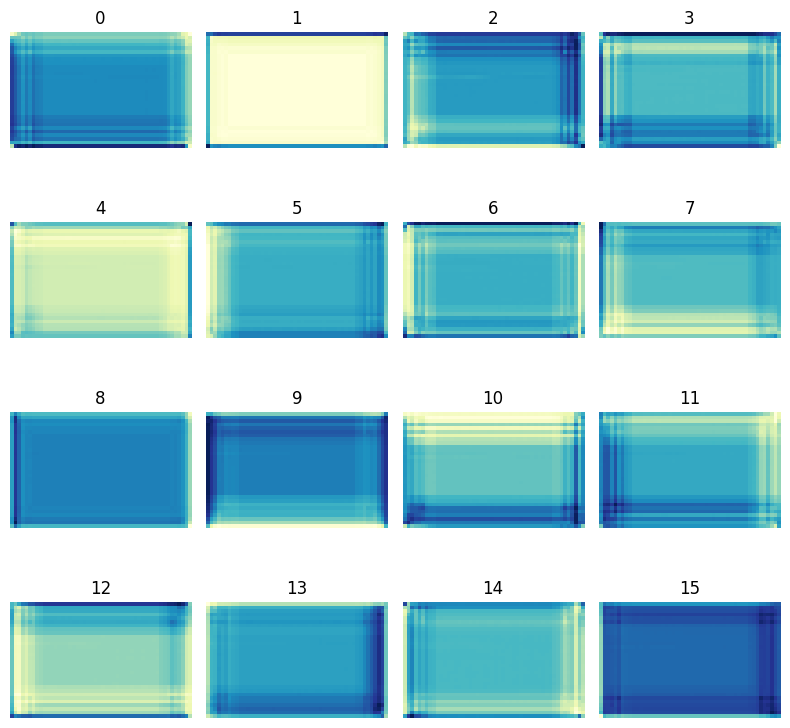

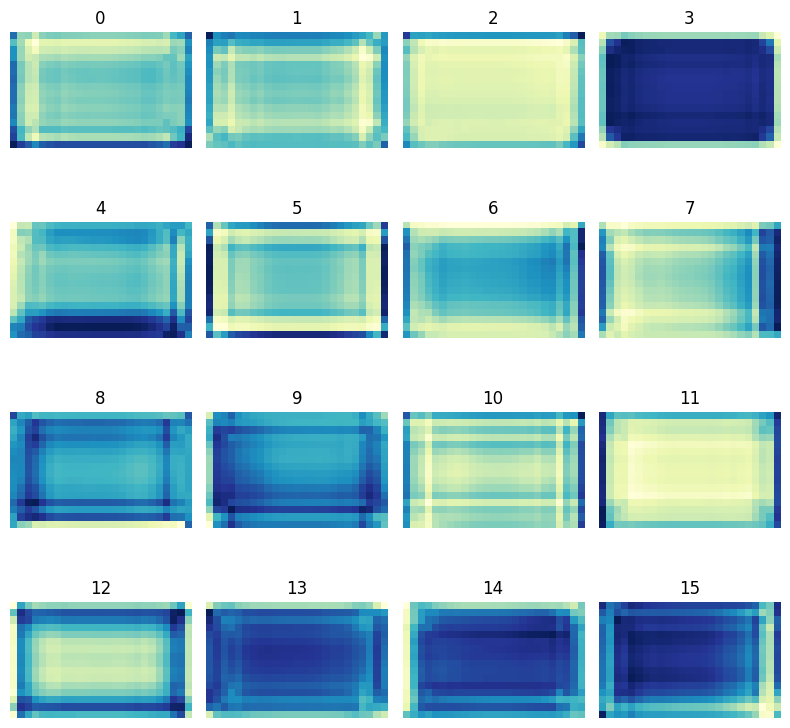

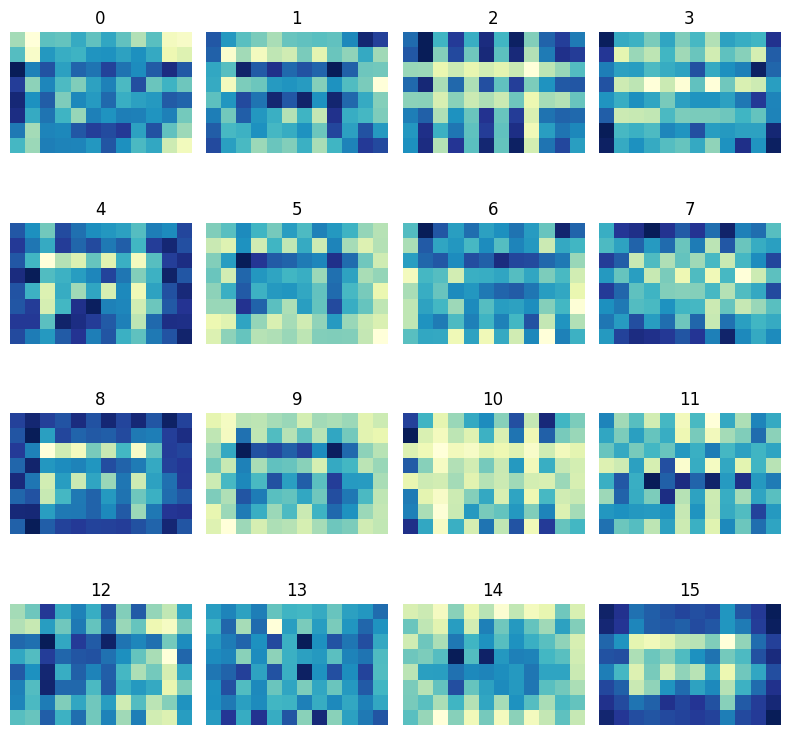

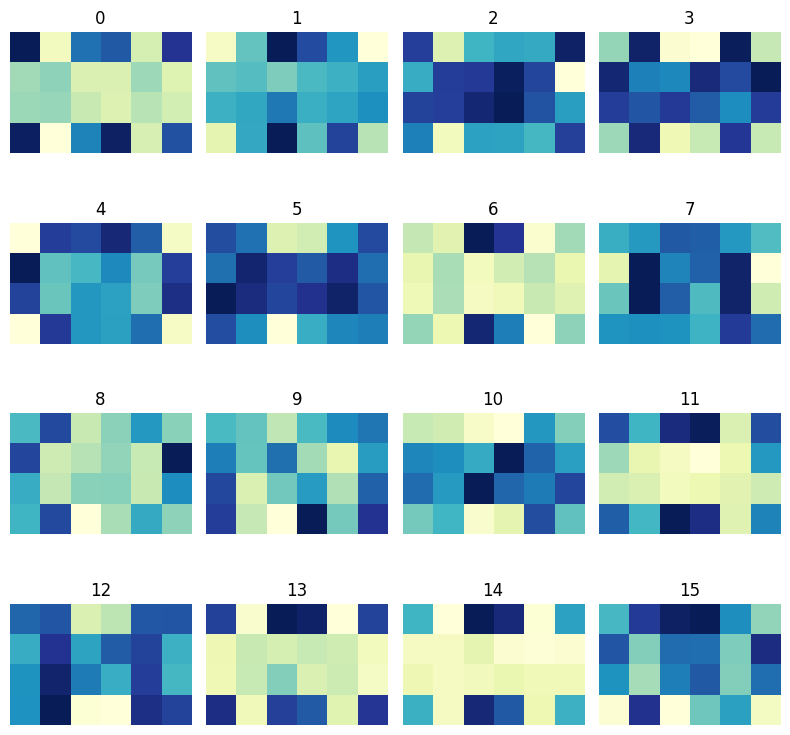

In [35]:
import matplotlib.pyplot as plt
for dim_ in range(n_layers):
    images = feats[dim_].squeeze().detach().cpu()[:16]
    rows = cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap="YlGnBu")
        ax.axis("off")
        ax.set_title(str(i))

    plt.tight_layout()
    plt.show()

In [ ]:
with torch.inference_mode():
    image = image_left
    image_resized = resize_transform(image)
    image_resized = TF.normalize(image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)
    image_resized = image_resized.unsqueeze(0).cuda()

    feats = model.get_intermediate_layers(image_resized, n=range(n_layers), reshape=True, norm=True)


for dim_ in range(7):
    dim_ *= 4
    # print(dim_)
    # continue
    if dim_ == len(feats):
        dim_ -= 1
    # print(dim_)
    images = feats[dim_].squeeze().detach().cpu()[:16]
    rows = cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap="YlGnBu")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
x = torch.randn(1, 3, 129, 200).cuda()

In [43]:
class Dinov2_eeg_rt(nn.Module):
    def __init__(self, c_dim=129, t_dim=200 , freeze_encoder = True ,model = None  , n_layers = 24) :
        super().__init__()
        self.dino_model = model
        if freeze_encoder:
            for param in self.dino_model.parameters():
                param.requires_grad = False
            self.dino_model.eval()
        else: 
            for param in self.dino_model.parameters():
                param.requires_grad = True

        self.fc  = nn.Linear(1024*12*8, 1, bias=False)
        nn.init.kaiming_normal(self.fc.weight, mode="fan_in")
        
    def forward(self ,x):
            with torch.inference_mode():

                x=x.unsqueeze(1).repeat(1,3,1,1)

                feats = self.dino_model.get_intermediate_layers(x, n=range(4), reshape=True, norm=True)[3]
                premuted_x = feats.permute(0 , 2 , 1 ,3).reshape(feats.shape[0] , -1)
            
            return self.fc(premuted_x)

In [44]:
n_layers = 24
model.compile()
model_ = Dinov2_eeg_rt(freeze_encoder=True , model=model , n_layers=n_layers).to(device)
optimizer = torch.optim.AdamW(
    [
        #{"params": model_.dino_model_.parameters(), "lr": 1e-5 , "weight_decay":0},
        {"params": model_.fc.parameters(), "lr": 1e-4 , "weight_decay":1e-3},
    ])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.5, min_lr=1e-5)

C:\Users\mahdi\AppData\Local\Temp\ipykernel_10432\415625701.py:14: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  nn.init.kaiming_normal(self.fc.weight, mode="fan_in")


In [45]:
loss_f = nn.MSELoss()

epochs = 8 
step_count = len(train_ccd_dataloader) * epochs
warmup = step_count/20

print("before training")


test_nrmse = nrmse_over_data(model_ , test_ccd_dataloader ,device)
print(f"test nrmse : {test_nrmse}")


best_rnmse = 100000
best_model__path = r"best_model_.pt"
best_rnmse_path = r"best_rnmse.pt"
if os.path.exists(best_rnmse_path):
    best_rnmse = torch.load(best_rnmse_path)
    print(f"best nrmse :{best_rnmse}")

total_steps = 480
for epoch in range(4):
    step = 0
    cumulative_loss = 0
    pb = tqdm(train_ccd_dataloader)
    with torch.autocast(device_type="cuda", enabled=False):
        for batch in pb:
            step += 1
            if step > total_steps // 4:
                break
            x , y = batch
            
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model_(x).view_as(y)
            loss= torch.sqrt(loss_f(y_hat, y))

            # ⭐️ ⭐️ Scale Gradients
            loss.backward()
            # ⭐️ ⭐️ Update Optimizer
            optimizer.step()

            cumulative_loss += loss.item()
            pb.set_postfix(loss=loss.item())
        

    print(f"epoch {epoch} loss : {cumulative_loss/(total_steps//4.0):.8f}")
    cumulative_loss=0
    nrmse_over_test = nrmse_over_data(model_ , test_ccd_dataloader ,device)
    print(f"test nrmse : {nrmse_over_test}")
    if nrmse_over_test < best_rnmse:
        best_rnmse = nrmse_over_test
        print(f"new best nrmse : {best_rnmse}")
        torch.save(model_.state_dict(), best_model__path)
        torch.save(best_rnmse, best_rnmse_path)

before training


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:06<?, ?it/s]


KeyboardInterrupt: 

#### KL loss


In [46]:
import torch
import torch.nn as nn
import os
from tqdm import tqdm

epochs = 8
step_count = len(train_ccd_dataloader) * epochs
warmup = step_count / 20

print("before training")

test_nrmse = nrmse_over_data(model_, test_ccd_dataloader, device)
print(f"test nrmse : {test_nrmse}")

best_rnmse = 100000
best_model__path = r"best_model_.pt"
best_rnmse_path = r"best_rnmse.pt"

if os.path.exists(best_rnmse_path):
    best_rnmse = torch.load(best_rnmse_path)
    print(f"best nrmse : {best_rnmse}")

total_steps = 480

for epoch in range(4):
    step = 0
    cumulative_loss = 0.0
    pb = tqdm(train_ccd_dataloader)

    for batch in pb:
        step += 1
        if step > total_steps // 4:
            break

        x, y = batch
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_hat = model_(x).view_as(y)

        # --- Compute KL divergence between Gaussian(y) and Gaussian(y_hat) ---
        mean_y = y.mean()
        std_y = y.std() + 1e-8
        mean_y_hat = y_hat.mean()
        std_y_hat = y_hat.std() + 1e-8

        kl_loss = (
            torch.log(std_y_hat / std_y)
            + (std_y**2 + (mean_y - mean_y_hat)**2) / (2 * std_y_hat**2)
            - 0.5
        )

        loss = kl_loss  # pure KL divergence optimization
        loss.backward()
        optimizer.step()

        cumulative_loss += loss.item()
        pb.set_postfix(loss=loss.item())

    print(f"epoch {epoch} mean KL loss : {cumulative_loss/(total_steps//4.0):.8f}")

    nrmse_over_test = nrmse_over_data(model_, test_ccd_dataloader, device)
    print(f"test nrmse : {nrmse_over_test}")

    if nrmse_over_test < best_rnmse:
        best_rnmse = nrmse_over_test
        print(f"new best nrmse : {best_rnmse}")
        torch.save(model_.state_dict(), best_model__path)
        torch.save(best_rnmse, best_rnmse_path)


before training


  0%|          | 0/17 [00:00<?, ?it/s]

100%|██████████| 17/17 [01:33<00:00,  5.52s/it]


test nrmse : 3.3372093055994547
best nrmse : 0.9269812395697398


 91%|█████████ | 120/132 [11:21<01:08,  5.68s/it, loss=0.374] 


epoch 0 mean KL loss : 34.27652197


100%|██████████| 17/17 [01:38<00:00,  5.78s/it]


test nrmse : 1.841243541231882


 91%|█████████ | 120/132 [11:25<01:08,  5.71s/it, loss=0.288] 


epoch 1 mean KL loss : 0.48066439


100%|██████████| 17/17 [01:36<00:00,  5.68s/it]


test nrmse : 1.7883517445967099


  2%|▏         | 2/132 [00:17<18:26,  8.51s/it, loss=0.0823]


KeyboardInterrupt: 

In [47]:
y_hat.min(), y_hat.max(), y_hat.mean(), y_hat.std(), y.min(), y.max(), y.mean(), y.std()

(tensor(-3.3916, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(1.7225, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(1.5916, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.2380, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(0.1400, device='cuda:0'),
 tensor(2.4000, device='cuda:0'),
 tensor(1.6772, device='cuda:0'),
 tensor(0.3638, device='cuda:0'))

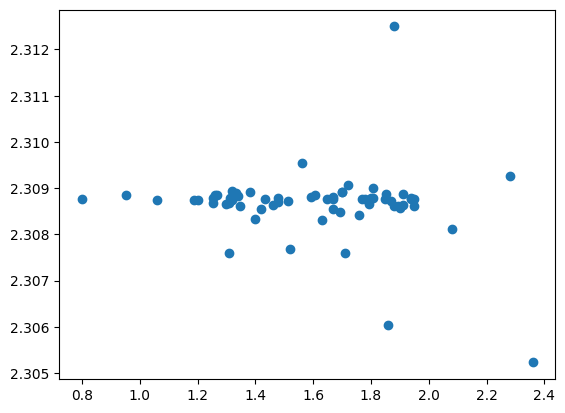

In [36]:
import matplotlib.pyplot as plt
plt.scatter(y.detach().cpu().numpy(), y_hat.detach().cpu().numpy())

In [ ]:
next(iter(model.dino_model.parameters())).weight.grad

In [ ]:
train_nrmse = nrmse_over_data(model_ , train_ccd_dataloader ,device)
print(f"nrmse over train {train_nrmse}")

  0%|          | 0/1051 [00:00<?, ?it/s]

IndexError: tuple index out of range

In [82]:
print(loss.item())

NameError: name 'loss' is not defined

In [ ]:
if os.path.exists(best_model_path):
    model = Vit_EEG_Encoder().to(device)
    rt_regressor_model = Vit_EEG_RT_Decoder(model , fine_tune_encoder=False).to(device)
    rt_regressor_model.load_state_dict(torch.load(best_model_path))
    rt_regressor_model.eval()
    print("best model loaded")
else:
    print("best model not found")
    raise Exception("best model not found")
final_r5_test =pairs_to_fast_loading_shards([] ,"final_r5_test" , shard_size)
r5_test_ccd_data = EEGDataset(final_r5_test ,  shard_size)

r5_test_ccd_dataloader = DataLoader(r5_test_ccd_data , batch_size=batch_size , shuffle=False )
print(f"r5 test nRMSE : {nrmse_over_data(rt_regressor_model , r5_test_ccd_dataloader,device)}")

# Challange 2


## Data preproccessing and sharding


In [ ]:
def get_participants_p_factor_files(data_dir)->dict[str , str]: 
    result = {}
    for release in os.listdir(data_dir):
        release_dir = os.path.join(data_dir, release)
        participants_description_path = os.path.join(release_dir, "participants.tsv")
        result[release_dir] = participants_description_path
    return result

def valid_participant(participant_dir_path)->bool:
    participant_dir_path = os.path.join(participant_dir_path , "eeg")
    required_rec_lenght = 15*60
    cumulative_sec = 0
    for file in os.listdir(participant_dir_path):
        if file.endswith(".bdf"):
            eeg = mne.io.read_raw_bdf(os.path.join(participant_dir_path , file) , preload=False, verbose=False)
            if int(eeg.info["nchan"])!=129:
                continue
            n_samples = eeg.n_times
            sfreq = eeg.info["sfreq"]   # sampling frequency in Hz
            length_seconds = n_samples / sfreq
            cumulative_sec += length_seconds
            if cumulative_sec >= required_rec_lenght:
                return True
    return False

def extract_valid_subjects_scores(data_dic : dict[str , str],history_path  = r"history\challange2_files.json" )->dict[str , float]:
    result = {}
    total_participants = 0
    valid_participants = 0
    if os.path.exists(history_path):
        print("loading_history")
        with open(history_path , "r") as f:
            result = json.load(f)
    else:
        print("no history")
        os.makedirs(os.path.dirname(history_path) , exist_ok=True)
        with open(history_path , "w") as f:
            json.dump(result , f , indent=2)

    for release , participants_description_path in (data_dic.items()):

        df = pd.read_csv(participants_description_path , sep = "\t")
        
        total_participants += len(df)
        print(f"release : {release} , total participants : {len(df)}")

        for index , row in tqdm(df.iterrows()):
            p = pd.to_numeric(row["p_factor"], errors="coerce")
            if pd.isna(p):
                continue

            participant_dir_path = os.path.join(release , row["participant_id"])
            if participant_dir_path in result:
                continue
            if valid_participant(participant_dir_path):
                result[participant_dir_path] = row["p_factor"]
                valid_participants += 1
                with open(history_path , "w") as f:
                    json.dump(result , f , indent=2)



    print(f"total participants : {total_participants} , valid participants : {valid_participants}")
    return result

def p_factor_train_test_split(data_dict : dict[str , float] , test_size : float = 0.2)->tuple[dict[str , float] , dict[str , float]]:
    train_dict = {}
    test_dict = {}
    participants = list(data_dict.keys())
    train_set , test_set = train_test_split(participants , test_size=0.15) 
    for participant in train_set:
        train_dict[participant] = data_dict[participant]
    for participant in test_set:
        test_dict[participant] = data_dict[participant]
    return train_dict , test_dict

def challange2_sharding(data : dict[str , float] , shard_size : int = 1000 , output_dir = r"challange2_shards" ,split = "train" ,  window_per_subject = 100):

    os.makedirs(output_dir , exist_ok=True)
    split_path = os.path.join(output_dir , split)
    #if os.path.exists(split_path):
    #    return

    os.makedirs(split_path , exist_ok=True)
    curr_size = 0
    curr_windows = []
    curr_pfactor = []
    window_len_sec = 2  
    stride_sec = 2 
    num_shard = 0     

    print(f"sharding from {len(data)} participants")
    for participant, p_factor in tqdm(data.items()):
        participant_files_path = os.path.join(participant, "eeg")
        files = [os.path.join(participant_files_path, f) 
                for f in os.listdir(participant_files_path) if f.endswith(".bdf")]
        

        cutting = []
        for file in files:
            raw = mne.io.read_raw_bdf(file, preload=False, verbose=False)
            rec_length_sec = int(raw.n_times // raw.info["sfreq"]) 
            if rec_length_sec< 3:
                continue
            segments = [
                (file, start, start + window_len_sec)
                for start in range(0, rec_length_sec - window_len_sec , stride_sec)
            ]
            cutting.extend(segments)

        if len(cutting) >= window_per_subject:
            chosen = random.sample(cutting, window_per_subject)
        else:
            chosen = cutting 

        chosen = sorted(chosen, key=lambda x: (x[0], x[1]))
        chosen_dict = {}
        for file, start, end in chosen:
            chosen_dict.setdefault(file, []).append((start, end))
        for file , segments in chosen_dict.items():
            eeg_data = mne.io.read_raw_bdf(file, verbose=False)
        
            for start, end in segments:
                copied_eeg_data = eeg_data.copy()
                croped_eeg = copied_eeg_data.crop(tmin=start, tmax=end)
                eeg_data_array = np.array(croped_eeg.get_data()[: , :200])
                eeg_data_array = eeg_data_array.astype(np.float32)
                eeg_data_array = np.expand_dims(eeg_data_array, axis=0)
                curr_windows.append(eeg_data_array)
                curr_size += 1
            pfactor_array =np.array([p_factor] * len(segments)).astype(np.float32)
            curr_pfactor.append(pfactor_array)
        if curr_size >= shard_size:
            shard_path = os.path.join(split_path , f"window_{num_shard}.npy")
            pfactor_path  = os.path.join(split_path , f"pfactor_{num_shard}.npy")
            concatenated_windows = np.concatenate(curr_windows, axis=0)
            concatenated_pfactor = np.concatenate(curr_pfactor , axis=0)
            windows_to_be_added = concatenated_windows[: shard_size]
            pfactor_to_be_added = concatenated_pfactor[: shard_size]
            if concatenated_windows.shape(0) == shard_size:
                    curr_windows = []
                    curr_pfactor = []

            else :
                    curr_windows = [concatenated_windows[shard_size:]]
                    curr_pfactor = [concatenated_pfactor[shard_size:]]
            
            X = np.lib.format.open_memmap(shard_path , mode="w+" , dtype=np.float32 , shape=(windows_to_be_added.shape[0] , windows_to_be_added.shape[1] , windows_to_be_added.shape[2]))
            X[:] = windows_to_be_added
            X.flush()
            del X
            X = np.lib.format.open_memmap(pfactor_path , mode="w+" , dtype=np.float32 , shape=(pfactor_to_be_added.shape[0] , 1))
            X[:] = pfactor_to_be_added
            X.flush()
            del X
            curr_size = 0
            num_shard += 1
    
    if curr_size > 0:
        shard_path = os.path.join(split_path , f"window_{num_shard}.npy")
        pfactor_path  = os.path.join(split_path , f"pfactor_{num_shard}.npy")
        concatenated_windows = np.concatenate(curr_windows, axis=0)
        concatenated_pfactor = np.concatenate(curr_pfactor , axis=0)
        X = np.lib.format.open_memmap(shard_path , mode="w+" , dtype=np.float32 , shape=(concatenated_windows.shape[0] , concatenated_windows.shape[1] , concatenated_windows.shape[2]))
        X[:] = concatenated_windows
        X.flush()
        del X
        X = np.lib.format.open_memmap(pfactor_path , mode="w+" , dtype=np.float32 , shape=(concatenated_pfactor.shape[0] , 1))
        X[:] = concatenated_pfactor
        X.flush()
        del X

        





In [ ]:
import os, json, random
from typing import Dict
import numpy as np
import mne
from tqdm import tqdm

def challenge2_sharding(
    data: Dict[str, float],              # {participant_dir: p_factor}
    shard_size: int = 1000,
    output_dir: str = "challenge2_shards",
    split: str = "train",
    window_per_subject: int = 100,
    window_len_sec: int = 2,
    stride_sec: int = 2,
    seed: int = 42,
):
    random.seed(seed)
    os.makedirs(output_dir, exist_ok=True)
    split_path = os.path.join(output_dir, split)
    if os.path.exists(split_path):
        print(f"split {split} already exists")
        return
    os.makedirs(split_path, exist_ok=True)
    
    num_shard = 0
    curr_windows, curr_targets, curr_subjects = [], [], []
    curr_size = 0

    print(f"sharding from {len(data)} participants")

    for participant_dir, p_factor in tqdm(data.items()):
        eeg_dir = os.path.join(participant_dir, "eeg")
        files = [
            os.path.join(eeg_dir, f)
            for f in os.listdir(eeg_dir) if f.endswith(".bdf")
        ]

        # Build candidate windows (file, start_sec, end_sec) ONLY from 129-ch recordings
        candidates = []
        for file in files:
            raw_hdr = mne.io.read_raw_bdf(file, preload=False, verbose=False)

            # HARD GUARD: only accept recordings with exactly 129 channels
            if len(raw_hdr.ch_names) != 129:
                continue

            dur_sec = int(raw_hdr.last_samp // raw_hdr.info["sfreq"])
            if dur_sec < window_len_sec + 1:
                continue

            for start in range(0, dur_sec - window_len_sec + 1, stride_sec):
                candidates.append((file, start, start + window_len_sec))

        if not candidates:
            continue

        # Sample windows for this participant
        k = min(window_per_subject, len(candidates))
        chosen = random.sample(candidates, k)

        # Group by file to open each once
        per_file = {}
        for file, s, e in chosen:
            per_file.setdefault(file, []).append((s, e))
        for file in per_file:
            per_file[file].sort(key=lambda t: t[0])

        # Extract windows
        for file, segs in per_file.items():
            raw = mne.io.read_raw_bdf(file, preload=False, verbose=False)



            sfreq = raw.info["sfreq"]
            win_samp = int(round(window_len_sec * sfreq))

            for start_sec, _end_sec in segs:
                start_samp = int(round(start_sec * sfreq))
                stop_samp  = start_samp + win_samp
                X = raw.get_data(start=start_samp, stop=stop_samp)  # (C, T), non-mutating
                if X.shape[0] != 129 or X.shape[1] != win_samp:
                    continue
                curr_windows.append(X.astype(np.float32))
                curr_targets.append(np.float32(p_factor))
                curr_subjects.append(participant_dir)
                curr_size += 1

                if curr_size >= shard_size:
                    _flush_shard(split_path, num_shard, curr_windows, curr_targets, curr_subjects)
                    num_shard += 1
                    curr_windows, curr_targets, curr_subjects = [], [], []
                    curr_size = 0

    if curr_size > 0:
        _flush_shard(split_path, num_shard, curr_windows, curr_targets, curr_subjects)


def _flush_shard(split_path, shard_idx, windows_list, targets_list, subjects_list):
    X = np.stack(windows_list, axis=0)             # (N, 129, T)
    y = np.asarray(targets_list, dtype=np.float32) # (N,)
    subj = subjects_list

    win_path  = os.path.join(split_path, f"windows_{shard_idx}.npy")
    y_path    = os.path.join(split_path, f"pfactor_{shard_idx}.npy")

    Xm = np.lib.format.open_memmap(win_path, mode="w+", dtype=np.float32, shape=X.shape)
    Xm[:] = X; Xm.flush(); del Xm

    Ym = np.lib.format.open_memmap(y_path, mode="w+", dtype=np.float32, shape=(y.shape[0], 1))
    Ym[:, 0] = y; Ym.flush(); del Ym



In [ ]:
data_dir = r"D:\projects\pytorch_training\data_1"
data_dict = get_participants_p_factor_files(data_dir)
valid_participants_pf = extract_valid_subjects_scores(data_dict)

loading_history


In [ ]:


train_dict , test_dict = p_factor_train_test_split(valid_participants_pf)




In [ ]:
challange2_shard_output="challange2_shards"
challenge2_sharding(train_dict , split="train" , output_dir=challange2_shard_output)

sharding from 1876 participants


100%|██████████| 1876/1876 [2:42:49<00:00,  5.21s/it]  


In [ ]:
challenge2_sharding(test_dict ,split="test" , output_dir=challange2_shard_output)

In [ ]:
class Challange2_Dataset(Dataset):
    def __init__(self , shards_dir  ,split = "train", shard_size  =1000 ):
        self.shards_path = os.path.join(shards_dir , split)
        self.numbers_of_shards = int( len(os.listdir(self.shards_path)) / 2)
        self.shard_size = shard_size
        length =0
        for shard_path in os.listdir(self.shards_path):
            if "window" in shard_path:
                window_shard_path = os.path.join(self.shards_path , shard_path)
                shard = np.lib.format.open_memmap(window_shard_path , mode="r")
                size = shard.shape[0]
                length += size
        self.length = length
    def __len__(self):
        return self.length
    
    def __getitem__(self , index):
        shard_pos = index // self.shard_size 
        window_shard_path = os.path.join(self.shards_path , f"windows_{shard_pos}.npy")
        X = np.lib.format.open_memmap(window_shard_path , mode="r")
        rt_shard_path = os.path.join(self.shards_path , f"pfactor_{shard_pos}.npy")
        Y = np.lib.format.open_memmap(rt_shard_path , mode="r")
        raw = X[index % self.shard_size]
        rt = Y[index % self.shard_size]
        return raw , rt
    


        
    

In [ ]:

challange2_shard_output="challange2_shards"
c2_train_dataset = Challange2_Dataset(shards_dir=challange2_shard_output , split="train" , shard_size=1000)
c2_test_dataset = Challange2_Dataset(shards_dir=challange2_shard_output , split="test" , shard_size=1000)


In [ ]:

batch_size = 100

c2_train_loader = DataLoader(c2_train_dataset , batch_size=batch_size , shuffle=False)
c2_test_loader = DataLoader(c2_test_dataset , batch_size=batch_size , shuffle=False)

In [ ]:

for x ,y in tqdm(c2_train_loader):

    if len(np.unique(y)) != 1:
        print(len(np.unique(y)))


  0%|          | 0/1876 [00:00<?, ?it/s]

100%|██████████| 1876/1876 [02:28<00:00, 12.64it/s]


# Challange 2 Model building and training


## version 1


In [ ]:
import torch
import torch.nn as nn

class GatedFusion(nn.Module):
    def __init__(self, dim=512, hidden=256, bias_to_x=0.5):
        super().__init__()
        self.ln_x = nn.LayerNorm(dim)
        self.ln_y = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(2*dim, hidden),
            nn.GELU(),
            nn.Linear(hidden, dim)
        )
        # Optional: bias gate toward x at init (sigmoid(bias_to_x))
        nn.init.constant_(self.mlp[-1].bias, bias_to_x)

    def forward(self, x, y):           # x,y: (B, dim)
        x_n = self.ln_x(x)
        y_n = self.ln_y(y)
        h = torch.cat([x_n, y_n], dim=-1)
        g = torch.sigmoid(self.mlp(h)) # (B, dim)
        fused = g * x + (1.0 - g) * y  # convex blend per feature
        return fused, g                # returning g helps you log/inspect


class AttentionPool(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.query = nn.Parameter(torch.randn(1, 1, dim)) 
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x):
        # x: (B, N, dim)
        B = x.size(0)
        q = self.query.expand(B, -1, -1)  # (B, 1, dim)
        out, _ = self.attn(q, x, x)       # attend over all tokens (b 1 n )* (b n d) = (b 1 d)
        return out.squeeze(1)             # (B, dim)
    
class TemporalConv(nn.Module):

    def __init__(self, in_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding),
            nn.BatchNorm1d(in_channels),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding),
            nn.BatchNorm1d(in_channels),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

    def forward(self, x):
        x= x.transpose(1, 2)

        x = self.conv(x).squeeze(-1)
        return x

class Challange2_Vit_EEG_RT_Decoder(nn.Module):
    def __init__(self, encoder, c_dim=129, t_dim=200 , fine_tune_encoder = False):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.encoder = encoder
        if fine_tune_encoder :
            for param in self.encoder.parameters():
                param.requires_grad = True
        else:
            for param in self.encoder.parameters():
                param.requires_grad = False

        self.pool = AttentionPool(512, num_heads=4)
        self.temporal_conv = TemporalConv(512, kernel_size=3, stride=1, padding=1)
        self.fusion = GatedFusion(dim=512, hidden=256)

        self.regressor = nn.Sequential(
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        
        x = self.encoder.extract_features(x)  # (B, N, 512)
        a = self.pool(x)                      # (B, 512)

        b = self.temporal_conv(x)             # (B, 512)
        x , _= self.fusion(a, b)                  # (B, 512)
        x = self.regressor(x)                 # (B, 1)
        return x


In [ ]:

model = Vit_EEG_Encoder().to(device)

save_path = "6layer_encoder.pt"
if os.path.isfile(save_path):
    ckpt = torch.load(save_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    start_epoch = ckpt.get("epoch", 0)
    start_it = ckpt.get("it_in_epoch", 0)
    global_steps = ckpt.get("steps", 0)
    train_losses = ckpt.get("train_losses", [])
    val_losses = ckpt.get("val_losses", [])

pfactor_regressor = Challange2_Vit_EEG_RT_Decoder(model , fine_tune_encoder=True).to(device)


optimizer = torch.optim.AdamW([
    {"params": pfactor_regressor.encoder.parameters(), "lr": 1e-4},    
    {"params": pfactor_regressor.pool.parameters(), "lr": 5e-4},
    {"params": pfactor_regressor.temporal_conv.parameters(), "lr": 5e-4},
    {"params": pfactor_regressor.fusion.parameters(), "lr": 5e-4},
    {"params": pfactor_regressor.regressor.parameters(), "lr": 5e-4},
], weight_decay=0.02)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
loss_f = nn.SmoothL1Loss(beta=0.2)  


print("before training")
print(f"train nRMSE : {nrmse_over_data(pfactor_regressor , c2_train_loader  ,device)}")
print(f"test nRMSE : {nrmse_over_data(pfactor_regressor , c2_test_loader ,device)}")

best_model_path = "challange2_best_model.pt"
best_rnmse_path = "challange2_best_rnmse.pt"
best_rnmse = 1000
if os.path.exists(best_rnmse_path):
    best_rnmse = float(torch.load(best_rnmse_path))
    print(f"best model loaded with rnmse : {best_rnmse}")


epochs = 10
for epoch in range(epochs):
    pfactor_regressor.train()
    cumulative_loss = 0
    for  batch in tqdm(c2_train_loader):
        x , y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = pfactor_regressor(x)
        loss = loss_f(y_pred , y)
        cumulative_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    nrmse_train = nrmse_over_data(pfactor_regressor , c2_train_loader ,device)


    cumulative_loss = 0

    print(f"train epoch : {epoch +1} , loss : {cumulative_loss/len(c2_train_loader)} , nRMSE : {nrmse_train}")
    with torch.inference_mode() :
        pfactor_regressor.eval()
        for batch in tqdm(c2_test_loader):
            x , y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred = pfactor_regressor(x)
            loss = loss_f(y_pred , y)
            cumulative_loss += loss.item()
        nrmse_test = nrmse_over_data(pfactor_regressor , c2_test_loader ,device)
    print(f"test epoch : {epoch +1} , loss : {cumulative_loss/len(c2_test_loader)} , nRMSE : {nrmse_test}")
    if nrmse_test < best_rnmse:
        print(f"new best model found with rnmse : {nrmse_test}")
        best_rnmse = nrmse_test
        torch.save(pfactor_regressor.state_dict() , best_model_path)
        torch.save(best_rnmse , best_rnmse_path)





before training


  9%|▊         | 501/5863 [00:24<04:17, 20.80it/s]


train nRMSE : 1.0044566321501807


 55%|█████▌    | 501/907 [00:18<00:14, 27.45it/s]


test nRMSE : 1.0014614872935472


  9%|▊         | 501/5863 [00:20<03:38, 24.49it/s]


train epoch : 1 , loss : 0.0 , nRMSE : 0.9945003492095315


 55%|█████▌    | 501/907 [00:15<00:12, 32.09it/s]


test epoch : 1 , loss : 0.6311436260112406 , nRMSE : 1.016806804298285


  9%|▊         | 501/5863 [00:22<03:56, 22.69it/s]


train epoch : 2 , loss : 0.0 , nRMSE : 0.9955796006177127


 55%|█████▌    | 501/907 [00:15<00:12, 32.25it/s]


test epoch : 2 , loss : 0.6276227744016899 , nRMSE : 1.0084521462331582


 79%|███████▉  | 4644/5863 [04:37<01:12, 16.74it/s]


KeyboardInterrupt: 

### final test


In [ ]:
data_dir = r"D:\projects\pytorch_training\test_data"
data_dict = get_participants_p_factor_files(data_dir)
valid_participants_pf = extract_valid_subjects_scores(data_dict)
len(valid_participants_pf)


no history
release : D:\projects\pytorch_training\test_data\R5_L100_bdf , total participants : 330


330it [08:26,  1.54s/it]

total participants : 330 , valid participants : 312


312

In [ ]:
challange2_shard_output="challange2_shards"
challenge2_sharding(valid_participants_pf , split="final_r5_test" , output_dir=challange2_shard_output)

sharding from 312 participants


100%|██████████| 312/312 [28:04<00:00,  5.40s/it]


In [ ]:
if os.path.exists(best_model_path):
    pfactor_regressor = Challange2_Vit_EEG_RT_Decoder(model , fine_tune_encoder=False).to(device)
    pfactor_regressor.load_state_dict(torch.load(best_model_path))
    pfactor_regressor.eval()
    print("best model loaded")
else:
    print("best model not found")
    raise Exception("best model not found")


challange2_shard_output="challange2_shards"
c2_final_test_dataset = Challange2_Dataset(shards_dir=challange2_shard_output , split="final_r5_test" , shard_size=1000)
c2_final_test_loader = DataLoader(c2_final_test_dataset , batch_size=batch_size , shuffle=True)

nrmse_final_test = nrmse_over_data(dataloader=c2_final_test_loader , model=pfactor_regressor , device=device)
print(f"final test nRMSE : {nrmse_final_test}")


best model loaded


 51%|█████▏    | 501/975 [00:26<00:24, 19.02it/s]

final test nRMSE : 1.0038246483784488


## version 2


In [ ]:
class Vit_EEG_Embedding(nn.Module):
    def __init__(self,nb_tokens , c_dim = 129   ,  t_dim = 200 , slice_size = 10 ,target_c_dim = 64 , target_t_dim = 6  , emb_dim = 512     ):
        super().__init__()
        self.time_projection = nn.Linear(slice_size  ,target_t_dim)
        self.channel_projection = nn.Linear(c_dim , target_c_dim)
        self.time_positional_emb = nn.Parameter(torch.zeros(1 , 1 , 1 , target_t_dim))
        self.channel_positional_emb = nn.Parameter(torch.zeros(1 , 1 , target_c_dim , 1))
        self.token_projection = nn.Linear(target_c_dim*target_t_dim , emb_dim)
        self.token_positional_emb = nn.Parameter(torch.zeros(  nb_tokens , emb_dim))
        self.mask_paramater = nn.Parameter(torch.zeros( c_dim , slice_size))
        nn.init.xavier_uniform_(self.time_positional_emb)
        nn.init.xavier_uniform_(self.channel_positional_emb)
        nn.init.xavier_uniform_(self.token_positional_emb)

        nn.init.xavier_uniform_(self.mask_paramater)

        self.slice_size = slice_size

    def zscore_bct(self ,x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
        """
        Per-window, per-channel z-score along time: (B, C, T) -> (B, C, T).
        """
        if not x.is_floating_point():
            x = x.float()
        mu = x.mean(dim=2, keepdim=True)
        sigma = x.std(dim=2, keepdim=True, unbiased=False).clamp_min(eps)
        return (x - mu) / sigma

    def patching (self,x : Tensor):
        # x starting shape (B , C , T)
        x = x.reshape(x.shape[0] , x.shape[1] ,   x.shape[2] // self.slice_size , self.slice_size)
        x = x.permute(0 , 2 , 1 , 3)
        return x
    def forward(self,x ,mask_index =  None):
        
        # x starting shape (B , C , T)
        # normilizing
        x = self.zscore_bct(x)
        x = self.patching(x)
        # x (B , N , C , slice)  N = T // slice
        if mask_index is not None:
            origin = x.clone()
            r = mask_index.shape[1]
            batch_index = torch.arange(x.shape[0],device=x.device).unsqueeze(1).expand(x.shape[0] , r)
            x[batch_index , mask_index ] = self.mask_paramater


        # x (B ,N , C , slice)  N = T // slice
        x = self.time_projection(x)
        # x (B , N , C , Target_t_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_t_dim , C)
        x = self.channel_projection(x)
        # x (B , N , Target_t_dim , Target_c_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_c_dim , Target_t_dim)
        x = x + self.time_positional_emb
        x = x + self.channel_positional_emb
        # Flatten 
        x= x.reshape(x.shape[0] , x.shape[1] , x.shape[2] * x.shape[3])
        # x (B , N , Target_c_dim * Target_t_dim)
        x = self.token_projection(x)
        # x (B , N , emb_dim)
        x = x + self.token_positional_emb
        if mask_index is not None:
            return x , origin
        return x , None
class Vit_EEG_Encoder(nn.Module):
    def __init__(self,c_dim = 129  ,  t_dim = 200   , slice_size = 10 , emb_dim = 512 , nhead = 8 ,  nb_layers = 12 ):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.emb_dim = emb_dim
        self.slice_size = slice_size
        assert self.t_dim % self.slice_size == 0
        self.nb_tokens = self.t_dim // self.slice_size

        self.nhead = nhead
        self.nb_layers = nb_layers
        self.embedding = Vit_EEG_Embedding(nb_tokens=self.nb_tokens , c_dim = self.c_dim , t_dim = self.t_dim , slice_size = self.slice_size , target_c_dim = self.c_dim , target_t_dim = self.slice_size , emb_dim = self.emb_dim )
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=self.emb_dim , nhead=self.nhead , dim_feedforward=emb_dim*4 , batch_first=True , norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer , num_layers=self.nb_layers ,enable_nested_tensor=False)
        self.decoder = nn.Sequential(
        nn.LayerNorm(emb_dim),
        nn.Linear(emb_dim, emb_dim * 4),
        nn.GELU(),
        nn.Linear(emb_dim * 4, self.c_dim * self.slice_size))
    def _make_mask(self, x , mask_ratio=0.2):
        # x: (B, C, T)
        masked_index = torch.randint(low=0 , high=self.nb_tokens , size=(x.shape[0],int(self.nb_tokens * mask_ratio),))
        return   masked_index

    def extract_features(self,x):   
        x ,_= self.embedding(x)
        x = self.transformer_encoder(x)
        return x
    def forward(self,x  , mask_index =None):
        emb_x , targets=  self.embedding(x ,   mask_index)
        transformed = self.transformer_encoder(emb_x)
        result = self.decoder(transformed)
        if targets is not None:
            return result , targets
        return result
        

In [ ]:
import torch
import torch.nn as nn



class AttentionPool(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.query = nn.Parameter(torch.zeros(1, 1, dim))
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x):
        # x: (B, N, dim)
        B = x.size(0)
        q = self.query.expand(B, -1, -1)  # (B, 1, dim)
        out, _ = self.attn(q, x, x)       # attend over all tokens (b 1 n )* (b n d) = (b 1 d)
        return out.squeeze(1)             # (B, dim)
    


class Challange2_Vit_EEG_RT_Decoder(nn.Module):
    def __init__(self, encoder, c_dim=129, t_dim=200 , fine_tune_encoder = False):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.encoder = encoder
        if fine_tune_encoder :
            for param in self.encoder.parameters():
                param.requires_grad = True
        else:
            for param in self.encoder.parameters():
                param.requires_grad = False
        self.normilize = nn.LayerNorm(512)
        self.pool = AttentionPool(512, num_heads=4)

        self.regressor = nn.Sequential(
            nn.Linear(512, 256),

            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        x = self.encoder.extract_features(x)  # (B, N, 512)
        x = self.normilize(x)
        x = self.pool(x)                      # (B, 512)
        x = self.regressor(x)                 # (B, 1)
        return x


In [ ]:
for i in range(10):
        
    model = Vit_EEG_Encoder().to(device)

    save_path = "last_checkpoint.pt"
    if os.path.isfile(save_path):
        ckpt = torch.load(save_path, map_location=device)
        model.load_state_dict(ckpt["model"])
        start_epoch = ckpt.get("epoch", 0)
        start_it = ckpt.get("it_in_epoch", 0)
        global_steps = ckpt.get("steps", 0)
        train_losses = ckpt.get("train_losses", [])
        val_losses = ckpt.get("val_losses", [])
        

    pfactor_regressor = Challange2_Vit_EEG_RT_Decoder(model , fine_tune_encoder=True).to(device)


    pfactor_regressor.eval()



    best_model_path = "challange2_best_model.pt"
    best_rnmse_path = "challange2_best_rnmse.pt"
    best_rnmse = 1000
    if os.path.exists(best_rnmse_path):
        best_rnmse = float(torch.load(best_rnmse_path))
        print(f"best model loaded with rnmse : {best_rnmse}")

    print("before training")
    ##print(f"train nRMSE : {nrmse_over_data(pfactor_regressor , c2_train_loader  ,device)}")
    test_nrmse = nrmse_over_data(pfactor_regressor , c2_test_loader ,device)
    print(f"test nRMSE : {test_nrmse}")
    if test_nrmse < best_rnmse:
        print(f"new best model found with rnmse : {test_nrmse}")
        best_rnmse = test_nrmse
        torch.save(pfactor_regressor.state_dict() , best_model_path)
        torch.save(best_rnmse , best_rnmse_path)


best model loaded with rnmse : 0.9999174924321194
before training


100%|██████████| 454/454 [00:54<00:00,  8.36it/s]


test nRMSE : 1.003198086239821
best model loaded with rnmse : 0.9999174924321194
before training


100%|██████████| 454/454 [00:27<00:00, 16.48it/s]


test nRMSE : 1.0026235428985073
best model loaded with rnmse : 0.9999174924321194
before training


100%|██████████| 454/454 [00:31<00:00, 14.50it/s]


test nRMSE : 1.0015730216609884
best model loaded with rnmse : 0.9999174924321194
before training


100%|██████████| 454/454 [00:46<00:00,  9.80it/s]


test nRMSE : 1.0116842326565905
best model loaded with rnmse : 0.9999174924321194
before training


100%|██████████| 454/454 [00:47<00:00,  9.60it/s]


test nRMSE : 1.0053054048802552
best model loaded with rnmse : 0.9999174924321194
before training


100%|██████████| 454/454 [00:44<00:00, 10.14it/s]


test nRMSE : 0.9998998786514097
new best model found with rnmse : 0.9998998786514097
best model loaded with rnmse : 0.9998998786514097
before training


100%|██████████| 454/454 [00:46<00:00,  9.85it/s]


test nRMSE : 1.006349593747937
best model loaded with rnmse : 0.9998998786514097
before training


100%|██████████| 454/454 [00:46<00:00,  9.78it/s]


test nRMSE : 1.00084751477638
best model loaded with rnmse : 0.9998998786514097
before training


100%|██████████| 454/454 [00:46<00:00,  9.68it/s]


test nRMSE : 1.0065342413859786
best model loaded with rnmse : 0.9998998786514097
before training


100%|██████████| 454/454 [00:47<00:00,  9.55it/s]

test nRMSE : 1.0006873196021535


In [ ]:

model = Vit_EEG_Encoder().to(device)

save_path = "last_checkpoint.pt"
if os.path.isfile(save_path):
    ckpt = torch.load(save_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    start_epoch = ckpt.get("epoch", 0)
    start_it = ckpt.get("it_in_epoch", 0)
    global_steps = ckpt.get("steps", 0)
    train_losses = ckpt.get("train_losses", [])
    val_losses = ckpt.get("val_losses", [])
    

pfactor_regressor = Challange2_Vit_EEG_RT_Decoder(model , fine_tune_encoder=True).to(device)


optimizer = torch.optim.AdamW([
    {"params": pfactor_regressor.encoder.parameters(), "lr": 5e-5 ,  "weight_decay": 0.01},    
    {"params": pfactor_regressor.normilize.parameters(), "lr": 1e-4, "weight_decay": 0.0},   # LayerNorm → no decay
    {"params": pfactor_regressor.pool.parameters(),      "lr": 1e-4, "weight_decay": 0.02},
    {"params": pfactor_regressor.regressor.parameters(), "lr": 1e-4, "weight_decay": 0.02},
], weight_decay=0.02)


scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
loss_f = nn.MSELoss()

pfactor_regressor.eval()



best_model_path = "challange2_best_model.pt"
best_rnmse_path = "challange2_best_rnmse.pt"
best_rnmse = 1000
if os.path.exists(best_rnmse_path):
    best_rnmse = float(torch.load(best_rnmse_path))
    print(f"best model loaded with rnmse : {best_rnmse}")

print("before training")
##print(f"train nRMSE : {nrmse_over_data(pfactor_regressor , c2_train_loader  ,device)}")
test_nrmse = nrmse_over_data(pfactor_regressor , c2_test_loader ,device)
print(f"test nRMSE : {test_nrmse}")
if test_nrmse < best_rnmse:
    print(f"new best model found with rnmse : {test_nrmse}")
    best_rnmse = test_nrmse
    torch.save(pfactor_regressor.state_dict() , best_model_path)
    torch.save(best_rnmse , best_rnmse_path)

epochs = 10
for epoch in range(epochs):
    pfactor_regressor.train()
    cumulative_loss = 0
    for  batch in tqdm(c2_train_loader):
        x , y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = pfactor_regressor(x)

        loss = loss_f(y_pred , y)
        cumulative_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    pfactor_regressor.eval()

    nrmse_train = nrmse_over_data(pfactor_regressor , c2_train_loader ,device)



    print(f"train epoch : {epoch +1} , loss : {cumulative_loss/len(c2_train_loader)} , nRMSE : {nrmse_train}")
    cumulative_loss = 0
    with torch.inference_mode() :
        nrmse_test = nrmse_over_data(pfactor_regressor , c2_test_loader ,device)
    print(f"test epoch : {epoch +1} , loss : {cumulative_loss/len(c2_test_loader)} , nRMSE : {nrmse_test}")
    if nrmse_test < best_rnmse:
        print(f"new best model found with rnmse : {nrmse_test}")
        best_rnmse = nrmse_test
        torch.save(pfactor_regressor.state_dict() , best_model_path)
        torch.save(best_rnmse , best_rnmse_path)





best model loaded with rnmse : 0.9999735322769453
before training


100%|██████████| 454/454 [00:29<00:00, 15.45it/s]


test nRMSE : 1.0035679923311043


 17%|█▋        | 501/2932 [00:42<03:26, 11.79it/s]


train epoch : 1 , loss : 0.6228586677233161 , nRMSE : 0.9823486164805656


100%|██████████| 454/454 [00:39<00:00, 11.51it/s]


test epoch : 1 , loss : 0.0 , nRMSE : 1.0057243055191498


 20%|██        | 592/2932 [01:14<04:55,  7.93it/s]


KeyboardInterrupt: 

In [ ]:
if os.path.exists(best_model_path):
    pfactor_regressor = Challange2_Vit_EEG_RT_Decoder(model , fine_tune_encoder=False).to(device)
    pfactor_regressor.load_state_dict(torch.load(best_model_path))
    pfactor_regressor.eval()
    print("best model loaded")
else:
    print("best model not found")
    raise Exception("best model not found")


challange2_shard_output="challange2_shards"
c2_final_test_dataset = Challange2_Dataset(shards_dir=challange2_shard_output , split="final_r5_test" , shard_size=1000)
c2_final_test_loader = DataLoader(c2_final_test_dataset , batch_size=batch_size , shuffle=True)

nrmse_final_test = nrmse_over_data(dataloader=c2_final_test_loader , model=pfactor_regressor , device=device)
print(f"final test nRMSE : {nrmse_final_test}")


best model loaded


100%|██████████| 488/488 [00:52<00:00,  9.23it/s]

final test nRMSE : 0.9999527320695456


## version 3


In [ ]:
class Vit_EEG_Embedding(nn.Module):
    def __init__(self,nb_tokens , c_dim = 129   ,  t_dim = 200 , slice_size = 10 ,target_c_dim = 64 , target_t_dim = 6  , emb_dim = 512     ):
        super().__init__()
        self.time_projection = nn.Linear(slice_size  ,target_t_dim)
        self.channel_projection = nn.Linear(c_dim , target_c_dim)
        self.time_positional_emb = nn.Parameter(torch.zeros(1 , 1 , 1 , target_t_dim))
        self.channel_positional_emb = nn.Parameter(torch.zeros(1 , 1 , target_c_dim , 1))
        self.token_projection = nn.Linear(target_c_dim*target_t_dim , emb_dim)
        self.token_positional_emb = nn.Parameter(torch.zeros(  nb_tokens , emb_dim))
        self.mask_paramater = nn.Parameter(torch.zeros( c_dim , slice_size))
        nn.init.xavier_uniform_(self.time_positional_emb)
        nn.init.xavier_uniform_(self.channel_positional_emb)
        nn.init.xavier_uniform_(self.token_positional_emb)

        nn.init.xavier_uniform_(self.mask_paramater)

        self.slice_size = slice_size

    def zscore_bct(self ,x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
        """
        Per-window, per-channel z-score along time: (B, C, T) -> (B, C, T).
        """
        if not x.is_floating_point():
            x = x.float()
        mu = x.mean(dim=2, keepdim=True)
        sigma = x.std(dim=2, keepdim=True, unbiased=False).clamp_min(eps)
        return (x - mu) / sigma

    def patching (self,x : Tensor):
        # x starting shape (B , C , T)
        x = x.reshape(x.shape[0] , x.shape[1] ,   x.shape[2] // self.slice_size , self.slice_size)
        x = x.permute(0 , 2 , 1 , 3)
        return x
    def forward(self,x ,mask_index =  None):
        
        # x starting shape (B , C , T)
        # normilizing
        x = self.zscore_bct(x)
        x = self.patching(x)
        # x (B , N , C , slice)  N = T // slice
        if mask_index is not None:
            origin = x.clone()
            r = mask_index.shape[1]
            batch_index = torch.arange(x.shape[0],device=x.device).unsqueeze(1).expand(x.shape[0] , r)
            x[batch_index , mask_index ] = self.mask_paramater


        # x (B ,N , C , slice)  N = T // slice
        x = self.time_projection(x)
        # x (B , N , C , Target_t_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_t_dim , C)
        x = self.channel_projection(x)
        # x (B , N , Target_t_dim , Target_c_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_c_dim , Target_t_dim)
        x = x + self.time_positional_emb
        x = x + self.channel_positional_emb
        # Flatten 
        x= x.reshape(x.shape[0] , x.shape[1] , x.shape[2] * x.shape[3])
        # x (B , N , Target_c_dim * Target_t_dim)
        x = self.token_projection(x)
        # x (B , N , emb_dim)
        x = x + self.token_positional_emb
        if mask_index is not None:
            return x , origin
        return x , None
class Vit_EEG_Encoder(nn.Module):
    def __init__(self,c_dim = 129  ,  t_dim = 200   , slice_size = 10 , emb_dim = 512 , nhead = 8 ,  nb_layers = 12 ):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.emb_dim = emb_dim
        self.slice_size = slice_size
        assert self.t_dim % self.slice_size == 0
        self.nb_tokens = self.t_dim // self.slice_size

        self.nhead = nhead
        self.nb_layers = nb_layers
        self.embedding = Vit_EEG_Embedding(nb_tokens=self.nb_tokens , c_dim = self.c_dim , t_dim = self.t_dim , slice_size = self.slice_size , target_c_dim = self.c_dim , target_t_dim = self.slice_size , emb_dim = self.emb_dim )
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=self.emb_dim , nhead=self.nhead , dim_feedforward=emb_dim*4 , batch_first=True , norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer , num_layers=self.nb_layers ,enable_nested_tensor=False)
        self.decoder = nn.Sequential(
        nn.LayerNorm(emb_dim),
        nn.Linear(emb_dim, emb_dim * 4),
        nn.GELU(),
        nn.Linear(emb_dim * 4, self.c_dim * self.slice_size))
    def _make_mask(self, x , mask_ratio=0.2):
        # x: (B, C, T)
        masked_index = torch.randint(low=0 , high=self.nb_tokens , size=(x.shape[0],int(self.nb_tokens * mask_ratio),))
        return   masked_index

    def extract_features(self,x):   
        x ,_= self.embedding(x)
        x = self.transformer_encoder(x)
        return x
    def forward(self,x  , mask_index =None):
        emb_x , targets=  self.embedding(x ,   mask_index)
        transformed = self.transformer_encoder(emb_x)
        result = self.decoder(transformed)
        if targets is not None:
            return result , targets
        return result
        

In [ ]:
class Challange2_Vit_EEG_RT_Decoder(nn.Module):
    def __init__(self, encoder, c_dim=129, t_dim=200 , fine_tune_encoder = False):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.encoder = encoder
        if fine_tune_encoder :
            for param in self.encoder.parameters():
                param.requires_grad = True
        else:
            for param in self.encoder.parameters():
                param.requires_grad = False
        self.normilize = nn.LayerNorm(512)
        self.pool = AttentionPool(512, num_heads=4)

        self.regressor = nn.Sequential(
            nn.Linear(512, 1024),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
        )

        for m in self.regressor.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    def forward(self, x):
        x = self.encoder.extract_features(x)  # (B, N, 512)
        x = self.normilize(x)
        x = self.pool(x)                      # (B, 512)
        x = self.regressor(x)*4                 # (B, 1)
        return x

In [ ]:

best_model_path = "challange2_best_model.pt"
best_rnmse_path = "challange2_best_rnmse.pt"
best_rnmse = 1000

if os.path.exists(best_rnmse_path):
    best_rnmse = float(torch.load(best_rnmse_path))
    print(f"best model loaded with rnmse : {best_rnmse}")
model = Vit_EEG_Encoder().to(device)

save_path = "last_checkpoint.pt"
if os.path.isfile(save_path):
    ckpt = torch.load(save_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    start_epoch = ckpt.get("epoch", 0)
    start_it = ckpt.get("it_in_epoch", 0)
    global_steps = ckpt.get("steps", 0)
    train_losses = ckpt.get("train_losses", [])
    val_losses = ckpt.get("val_losses", [])
for i in range(10000):
        

    pfactor_regressor = Challange2_Vit_EEG_RT_Decoder(model , fine_tune_encoder=True).to(device)


    pfactor_regressor.eval()



    ##print(f"train nRMSE : {nrmse_over_data(pfactor_regressor , c2_train_loader  ,device)}")
    test_nrmse = nrmse_over_data(pfactor_regressor , c2_test_loader ,device)
    print(f"test nRMSE : {test_nrmse}")
    if test_nrmse < best_rnmse:
        print(f"new best model found")
        print(f"old rnmse : { best_rnmse}")
        print(f"new rnmse : {test_nrmse}")
        best_rnmse = test_nrmse
        torch.save(pfactor_regressor.state_dict() , best_model_path)
        torch.save(best_rnmse , best_rnmse_path)


In [ ]:

model = Vit_EEG_Encoder().to(device)

save_path = "last_checkpoint.pt"
if os.path.isfile(save_path):
    ckpt = torch.load(save_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    start_epoch = ckpt.get("epoch", 0)
    start_it = ckpt.get("it_in_epoch", 0)
    global_steps = ckpt.get("steps", 0)
    train_losses = ckpt.get("train_losses", [])
    val_losses = ckpt.get("val_losses", [])
    

pfactor_regressor = Challange2_Vit_EEG_RT_Decoder(model , fine_tune_encoder=False).to(device)


optimizer = torch.optim.AdamW([
    {"params": pfactor_regressor.encoder.parameters(), "lr": 5e-5 ,  "weight_decay": 0.01},    
    {"params": pfactor_regressor.normilize.parameters(), "lr": 1e-4, "weight_decay": 0.0},   # LayerNorm → no decay
    {"params": pfactor_regressor.pool.parameters(),      "lr": 1e-4, "weight_decay": 0.02},
    {"params": pfactor_regressor.regressor.parameters(), "lr": 1e-4, "weight_decay": 0.02},
], weight_decay=0.02)


scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
loss_f = nn.MSELoss()

pfactor_regressor.eval()



best_model_path = "challange2_best_model.pt"
best_rnmse_path = "challange2_best_rnmse.pt"
best_rnmse = 1000
if os.path.exists(best_rnmse_path):
    best_rnmse = float(torch.load(best_rnmse_path))
    print(f"best model loaded with rnmse : {best_rnmse}")

print("before training")
##print(f"train nRMSE : {nrmse_over_data(pfactor_regressor , c2_train_loader  ,device)}")
test_nrmse = nrmse_over_data(pfactor_regressor , c2_test_loader ,device)
print(f"test nRMSE : {test_nrmse}")
if test_nrmse < best_rnmse:
    print(f"new best model found with rnmse : {test_nrmse}")
    best_rnmse = test_nrmse
    torch.save(pfactor_regressor.state_dict() , best_model_path)
    torch.save(best_rnmse , best_rnmse_path)

epochs = 10
for epoch in range(epochs):
    pfactor_regressor.train()
    cumulative_loss = 0
    for  batch in tqdm(c2_train_loader):
        x , y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = pfactor_regressor(x)

        loss = loss_f(y_pred , y)
        cumulative_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    pfactor_regressor.eval()

    nrmse_train = nrmse_over_data(pfactor_regressor , c2_train_loader ,device)



    print(f"train epoch : {epoch +1} , loss : {cumulative_loss/len(c2_train_loader)} , nRMSE : {nrmse_train}")
    cumulative_loss = 0
    with torch.inference_mode() :
        nrmse_test = nrmse_over_data(pfactor_regressor , c2_test_loader ,device)
    print(f"test epoch : {epoch +1} , loss : {cumulative_loss/len(c2_test_loader)} , nRMSE : {nrmse_test}")
    if nrmse_test < best_rnmse:
        print(f"new best model found with rnmse : {nrmse_test}")
        best_rnmse = nrmse_test
        torch.save(pfactor_regressor.state_dict() , best_model_path)
        torch.save(best_rnmse , best_rnmse_path)





best model loaded with rnmse : 0.9982996004650344
before training


 38%|███▊      | 11/29 [00:20<00:32,  1.83s/it]


KeyboardInterrupt: 

In [ ]:
best_model_path = "challange2_best_model.pt"
best_rnmse_path = "challange2_best_rnmse.pt"


model = Vit_EEG_Encoder().to(device)

save_path = "last_checkpoint.pt"
if os.path.isfile(save_path):
    ckpt = torch.load(save_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    start_epoch = ckpt.get("epoch", 0)
    start_it = ckpt.get("it_in_epoch", 0)
    global_steps = ckpt.get("steps", 0)
    train_losses = ckpt.get("train_losses", [])
    val_losses = ckpt.get("val_losses", [])
    
if os.path.exists(best_model_path):
    pfactor_regressor = Challange2_Vit_EEG_RT_Decoder(model , fine_tune_encoder=False).to(device)
    pfactor_regressor.load_state_dict(torch.load(best_model_path))
    pfactor_regressor.eval()
    print("best model loaded")
else:
    print("best model not found")
    raise Exception("best model not found")


challange2_shard_output="challange2_shards"
c2_final_test_dataset = Challange2_Dataset(shards_dir=challange2_shard_output , split="test" , shard_size=1000)
c2_final_test_loader = DataLoader(c2_final_test_dataset , batch_size=batch_size , shuffle=False)

nrmse_final_test = nrmse_over_data(dataloader=c2_final_test_loader , model=pfactor_regressor , device=device)
print(f"final test nRMSE : {nrmse_final_test}")


best model loaded


100%|██████████| 290/290 [00:37<00:00,  7.78it/s]

final test nRMSE : 1.0008846904566875


## full testing


In [ ]:
class Vit_EEG_Embedding(nn.Module):
    def __init__(self,nb_tokens , c_dim = 129   ,  t_dim = 200 , slice_size = 10 ,target_c_dim = 64 , target_t_dim = 6  , emb_dim = 512     ):
        super().__init__()
        self.time_projection = nn.Linear(slice_size  ,target_t_dim)
        self.channel_projection = nn.Linear(c_dim , target_c_dim)
        self.time_positional_emb = nn.Parameter(torch.zeros(1 , 1 , 1 , target_t_dim))
        self.channel_positional_emb = nn.Parameter(torch.zeros(1 , 1 , target_c_dim , 1))
        self.token_projection = nn.Linear(target_c_dim*target_t_dim , emb_dim)
        self.token_positional_emb = nn.Parameter(torch.zeros(  nb_tokens , emb_dim))
        self.mask_paramater = nn.Parameter(torch.zeros( c_dim , slice_size))
        nn.init.xavier_uniform_(self.time_positional_emb)
        nn.init.xavier_uniform_(self.channel_positional_emb)
        nn.init.xavier_uniform_(self.token_positional_emb)

        nn.init.xavier_uniform_(self.mask_paramater)

        self.slice_size = slice_size

    def zscore_bct(self ,x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
        """
        Per-window, per-channel z-score along time: (B, C, T) -> (B, C, T).
        """
        if not x.is_floating_point():
            x = x.float()
        mu = x.mean(dim=2, keepdim=True)
        sigma = x.std(dim=2, keepdim=True, unbiased=False).clamp_min(eps)
        return (x - mu) / sigma

    def patching (self,x : Tensor):
        # x starting shape (B , C , T)
        x = x.reshape(x.shape[0] , x.shape[1] ,   x.shape[2] // self.slice_size , self.slice_size)
        x = x.permute(0 , 2 , 1 , 3)
        return x
    def forward(self,x ,mask_index =  None):
        
        # x starting shape (B , C , T)
        # normilizing
        x = self.zscore_bct(x)
        x = self.patching(x)
        # x (B , N , C , slice)  N = T // slice
        if mask_index is not None:
            origin = x.clone()
            r = mask_index.shape[1]
            batch_index = torch.arange(x.shape[0],device=x.device).unsqueeze(1).expand(x.shape[0] , r)
            x[batch_index , mask_index ] = self.mask_paramater


        # x (B ,N , C , slice)  N = T // slice
        x = self.time_projection(x)
        # x (B , N , C , Target_t_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_t_dim , C)
        x = self.channel_projection(x)
        # x (B , N , Target_t_dim , Target_c_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_c_dim , Target_t_dim)
        x = x + self.time_positional_emb
        x = x + self.channel_positional_emb
        # Flatten 
        x= x.reshape(x.shape[0] , x.shape[1] , x.shape[2] * x.shape[3])
        # x (B , N , Target_c_dim * Target_t_dim)
        x = self.token_projection(x)
        # x (B , N , emb_dim)
        x = x + self.token_positional_emb
        if mask_index is not None:
            return x , origin
        return x , None
class Vit_EEG_Encoder(nn.Module):
    def __init__(self,c_dim = 129  ,  t_dim = 200   , slice_size = 10 , emb_dim = 512 , nhead = 8 ,  nb_layers = 12 ):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.emb_dim = emb_dim
        self.slice_size = slice_size
        assert self.t_dim % self.slice_size == 0
        self.nb_tokens = self.t_dim // self.slice_size

        self.nhead = nhead
        self.nb_layers = nb_layers
        self.embedding = Vit_EEG_Embedding(nb_tokens=self.nb_tokens , c_dim = self.c_dim , t_dim = self.t_dim , slice_size = self.slice_size , target_c_dim = self.c_dim , target_t_dim = self.slice_size , emb_dim = self.emb_dim )
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=self.emb_dim , nhead=self.nhead , dim_feedforward=emb_dim*4 , batch_first=True , norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer , num_layers=self.nb_layers ,enable_nested_tensor=False)
        self.decoder = nn.Sequential(
        nn.LayerNorm(emb_dim),
        nn.Linear(emb_dim, emb_dim * 4),
        nn.GELU(),
        nn.Linear(emb_dim * 4, self.c_dim * self.slice_size))
    def _make_mask(self, x , mask_ratio=0.2):
        # x: (B, C, T)
        masked_index = torch.randint(low=0 , high=self.nb_tokens , size=(x.shape[0],int(self.nb_tokens * mask_ratio),))
        return   masked_index

    def extract_features(self,x):   
        x ,_= self.embedding(x)
        x = self.transformer_encoder(x)
        return x
    def forward(self,x  , mask_index =None):
        emb_x , targets=  self.embedding(x ,   mask_index)
        transformed = self.transformer_encoder(emb_x)
        result = self.decoder(transformed)
        if targets is not None:
            return result , targets
        return result
        




class Challange2_Dataset(Dataset):
    def __init__(self , shards_dir  ,split = "train", shard_size  =1000 ):
        self.shards_path = os.path.join(shards_dir , split)
        self.numbers_of_shards = int( len(os.listdir(self.shards_path)) / 2)
        self.shard_size = shard_size
        length =0
        for shard_path in os.listdir(self.shards_path):
            if "window" in shard_path:
                window_shard_path = os.path.join(self.shards_path , shard_path)
                shard = np.lib.format.open_memmap(window_shard_path , mode="r")
                size = shard.shape[0]
                length += size
        self.length = length
    def __len__(self):
        return self.length
    
    def __getitem__(self , index):
        shard_pos = index // self.shard_size 
        window_shard_path = os.path.join(self.shards_path , f"windows_{shard_pos}.npy")
        X = np.lib.format.open_memmap(window_shard_path , mode="r")
        rt_shard_path = os.path.join(self.shards_path , f"pfactor_{shard_pos}.npy")
        Y = np.lib.format.open_memmap(rt_shard_path , mode="r")
        raw = X[index % self.shard_size]
        rt = Y[index % self.shard_size]
        return raw , rt
    


        
    

class AttentionPool(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.query = nn.Parameter(torch.empty(1, 1, dim))
        nn.init.kaiming_normal_(self.query, nonlinearity="relu")

        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x):
        # x: (B, N, dim)
        B = x.size(0)
        q = self.query.expand(B, -1, -1)  # (B, 1, dim)
        out, _ = self.attn(q, x, x)       # attend over all tokens (b 1 n )* (b n d) = (b 1 d)
        return out.squeeze(1)             # (B, dim)
    


class Challange2_Vit_EEG_RT_Decoder(nn.Module):
    def __init__(self, encoder, c_dim=129, t_dim=200 , fine_tune_encoder = False):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.encoder = encoder
        if fine_tune_encoder :
            for param in self.encoder.parameters():
                param.requires_grad = True
        else:
            for param in self.encoder.parameters():
                param.requires_grad = False
        self.normilize = nn.LayerNorm(512)
        self.pool = AttentionPool(512, num_heads=4)

        self.regressor = nn.Sequential(
            nn.Linear(512, 1024),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
        )

        for m in self.regressor.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    def forward(self, x):
        x = self.encoder.extract_features(x)  # (B, N, 512)
        x = self.normilize(x)
        x = self.pool(x)                      # (B, 512)
        x = self.regressor(x)                 # (B, 1)
        return x

In [ ]:
batch_size = 100
challange2_shard_output="challange2_shards"
c2_test_dataset = Challange2_Dataset(shards_dir=challange2_shard_output , split="test" , shard_size=1000)
c2_test_loader = DataLoader(c2_test_dataset , batch_size=batch_size , shuffle=False )

c2_final_test_dataset = Challange2_Dataset(shards_dir=challange2_shard_output , split="final_r5_test" , shard_size=1000)
c2_final_test_loader = DataLoader(c2_final_test_dataset , batch_size=batch_size , shuffle=False)
model = Vit_EEG_Encoder().to(device)

save_path = "last_checkpoint.pt"
if os.path.isfile(save_path):
    ckpt = torch.load(save_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    start_epoch = ckpt.get("epoch", 0)
    start_it = ckpt.get("it_in_epoch", 0)
    global_steps = ckpt.get("steps", 0)
    train_losses = ckpt.get("train_losses", [])
    val_losses = ckpt.get("val_losses", [])
    

pfactor_regressor = Challange2_Vit_EEG_RT_Decoder(model , fine_tune_encoder=False).to(device)

best_model_path = "challange2_best_model.pt"
best_rnmse_path = "challange2_best_rnmse.pt"
if os.path.exists(best_model_path):
    pfactor_regressor = Challange2_Vit_EEG_RT_Decoder(model , fine_tune_encoder=False).to(device)
    pfactor_regressor.load_state_dict(torch.load(best_model_path))
    pfactor_regressor.eval()
    print("best model loaded")
else:
    print("best model not found")
    raise Exception("best model not found")



nrmse_test = nrmse_over_data(dataloader=c2_test_loader , model=pfactor_regressor , device=device)
print(f"test nRMSE : {nrmse_test}")
nrmse_final_test = nrmse_over_data(dataloader=c2_final_test_loader , model=pfactor_regressor , device=device)
print(f"final test nRMSE : {nrmse_final_test}")




best model loaded


100%|██████████| 290/290 [00:23<00:00, 12.32it/s]


test nRMSE : 1.0002384573891525


100%|██████████| 312/312 [00:34<00:00,  9.16it/s]

final test nRMSE : 1.0003417589108892


## version 4


In [ ]:
class Vit_EEG_Embedding(nn.Module):
    def __init__(self,nb_tokens , c_dim = 129   ,  t_dim = 200 , slice_size = 10 ,target_c_dim = 64 , target_t_dim = 6  , emb_dim = 512     ):
        super().__init__()
        self.time_projection = nn.Linear(slice_size  ,target_t_dim)
        self.channel_projection = nn.Linear(c_dim , target_c_dim)
        self.time_positional_emb = nn.Parameter(torch.zeros(1 , 1 , 1 , target_t_dim))
        self.channel_positional_emb = nn.Parameter(torch.zeros(1 , 1 , target_c_dim , 1))
        self.token_projection = nn.Linear(target_c_dim*target_t_dim , emb_dim)
        self.token_positional_emb = nn.Parameter(torch.zeros(  nb_tokens , emb_dim))
        self.mask_paramater = nn.Parameter(torch.zeros( c_dim , slice_size))
        nn.init.xavier_uniform_(self.time_positional_emb)
        nn.init.xavier_uniform_(self.channel_positional_emb)
        nn.init.xavier_uniform_(self.token_positional_emb)

        nn.init.xavier_uniform_(self.mask_paramater)

        self.slice_size = slice_size

    def zscore_bct(self ,x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
        """
        Per-window, per-channel z-score along time: (B, C, T) -> (B, C, T).
        """
        if not x.is_floating_point():
            x = x.float()
        mu = x.mean(dim=2, keepdim=True)
        sigma = x.std(dim=2, keepdim=True, unbiased=False).clamp_min(eps)
        return (x - mu) / sigma

    def patching (self,x : Tensor):
        # x starting shape (B , C , T)
        x = x.reshape(x.shape[0] , x.shape[1] ,   x.shape[2] // self.slice_size , self.slice_size)
        x = x.permute(0 , 2 , 1 , 3)
        return x
    def forward(self,x ,mask_index =  None):
        
        # x starting shape (B , C , T)
        # normilizing
        x = self.zscore_bct(x)
        x = self.patching(x)
        # x (B , N , C , slice)  N = T // slice
        if mask_index is not None:
            origin = x.clone()
            r = mask_index.shape[1]
            batch_index = torch.arange(x.shape[0],device=x.device).unsqueeze(1).expand(x.shape[0] , r)
            x[batch_index , mask_index ] = self.mask_paramater


        # x (B ,N , C , slice)  N = T // slice
        x = self.time_projection(x)
        # x (B , N , C , Target_t_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_t_dim , C)
        x = self.channel_projection(x)
        # x (B , N , Target_t_dim , Target_c_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_c_dim , Target_t_dim)
        x = x + self.time_positional_emb
        x = x + self.channel_positional_emb
        # Flatten 
        x= x.reshape(x.shape[0] , x.shape[1] , x.shape[2] * x.shape[3])
        # x (B , N , Target_c_dim * Target_t_dim)
        x = self.token_projection(x)
        # x (B , N , emb_dim)
        x = x + self.token_positional_emb
        if mask_index is not None:
            return x , origin
        return x , None
class Vit_EEG_Encoder(nn.Module):
    def __init__(self,c_dim = 129  ,  t_dim = 200   , slice_size = 10 , emb_dim = 512 , nhead = 8 ,  nb_layers = 6 ):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.emb_dim = emb_dim
        self.slice_size = slice_size
        assert self.t_dim % self.slice_size == 0
        self.nb_tokens = self.t_dim // self.slice_size

        self.nhead = nhead
        self.nb_layers = nb_layers
        self.embedding = Vit_EEG_Embedding(nb_tokens=self.nb_tokens , c_dim = self.c_dim , t_dim = self.t_dim , slice_size = self.slice_size , target_c_dim = self.c_dim , target_t_dim = self.slice_size , emb_dim = self.emb_dim )
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=self.emb_dim , nhead=self.nhead , dim_feedforward=emb_dim*4 , batch_first=True , norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer , num_layers=self.nb_layers ,enable_nested_tensor=False)
        self.decoder = nn.Sequential(
        nn.LayerNorm(emb_dim),
        nn.Linear(emb_dim, emb_dim * 4),
        nn.GELU(),
        nn.Linear(emb_dim * 4, self.c_dim * self.slice_size))
    def _make_mask(self, x , mask_ratio=0.2):
        # x: (B, C, T)
        masked_index = torch.randint(low=0 , high=self.nb_tokens , size=(x.shape[0],int(self.nb_tokens * mask_ratio),))
        return   masked_index

    def extract_features(self,x):   
        x ,_= self.embedding(x)
        x = self.transformer_encoder(x)
        return x
    def forward(self,x  , mask_index =None):
        emb_x , targets=  self.embedding(x ,   mask_index)
        transformed = self.transformer_encoder(emb_x)
        result = self.decoder(transformed)
        if targets is not None:
            return result , targets
        return result
        

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEGConvRegressor(nn.Module):
    def __init__(self, c_dim=129, t_dim=200, emb_dim=128):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, emb_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(emb_dim),
            nn.ReLU()
        )

        # regression head
        self.regressor = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x: (B, 129, 200)
        x = x.unsqueeze(1)  # (B, 1, 129, 200)
        x = self.conv_layer(x)  # (B, emb_dim, H, W)
        x = F.adaptive_avg_pool2d(x, (1, 1))  # (B, emb_dim, 1, 1)
        x = x.view(x.size(0), -1)  # (B, emb_dim)
        x = self.regressor(x)  # (B, 1)
        return x


In [ ]:

"""model = Vit_EEG_Encoder().to(device)

save_path = "last_checkpoint.pt"
if os.path.isfile(save_path):
    ckpt = torch.load(save_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    start_epoch = ckpt.get("epoch", 0)
    start_it = ckpt.get("it_in_epoch", 0)
    global_steps = ckpt.get("steps", 0)
    train_losses = ckpt.get("train_losses", [])
    val_losses = ckpt.get("val_losses", [])"""
    

pfactor_regressor = EEGConvRegressor().to(device)


optimizer = torch.optim.AdamW( pfactor_regressor.parameters(), weight_decay=0.02)


scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
loss_f = nn.MSELoss()

pfactor_regressor.eval()



best_model_path = "challange2_best_model.pt"
best_rnmse_path = "challange2_best_rnmse.pt"
best_rnmse = 1000
if os.path.exists(best_rnmse_path):
    best_rnmse = float(torch.load(best_rnmse_path))
    print(f"best model loaded with rnmse : {best_rnmse}")

print("before training")
##print(f"train nRMSE : {nrmse_over_data(pfactor_regressor , c2_train_loader  ,device)}")
test_nrmse = nrmse_over_data(pfactor_regressor , c2_test_loader ,device)
print(f"test nRMSE : {test_nrmse}")
if test_nrmse < best_rnmse:
    print(f"new best model found with rnmse : {test_nrmse}")
    best_rnmse = test_nrmse
    torch.save(pfactor_regressor.state_dict() , best_model_path)
    torch.save(best_rnmse , best_rnmse_path)

epochs = 10
for epoch in range(epochs):
    pfactor_regressor.train()
    cumulative_loss = 0
    for  batch in tqdm(c2_train_loader):
        x , y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = pfactor_regressor(x)

        loss = loss_f(y_pred , y)
        cumulative_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    pfactor_regressor.eval()

    nrmse_train = nrmse_over_data(pfactor_regressor , c2_train_loader ,device)



    print(f"train epoch : {epoch +1} , loss : {cumulative_loss/len(c2_train_loader)} , nRMSE : {nrmse_train}")
    cumulative_loss = 0
    with torch.inference_mode() :
        nrmse_test = nrmse_over_data(pfactor_regressor , c2_test_loader ,device)
    print(f"test epoch : {epoch +1} , loss : {cumulative_loss/len(c2_test_loader)} , nRMSE : {nrmse_test}")
    if nrmse_test < best_rnmse:
        print(f"new best model found with rnmse : {nrmse_test}")
        best_rnmse = nrmse_test
        torch.save(pfactor_regressor.state_dict() , best_model_path)
        torch.save(best_rnmse , best_rnmse_path)





best model loaded with rnmse : 0.9998998786514097
before training


100%|██████████| 454/454 [00:37<00:00, 12.02it/s]


test nRMSE : 1.0110001349853748


 17%|█▋        | 501/2932 [00:46<03:43, 10.88it/s]


train epoch : 1 , loss : 0.8070236326768323 , nRMSE : 1.0011212676437142


100%|██████████| 454/454 [00:37<00:00, 11.95it/s]


test epoch : 1 , loss : 0.0 , nRMSE : 1.0029461556580133


 17%|█▋        | 501/2932 [00:50<04:04,  9.96it/s]


train epoch : 2 , loss : 0.806183681888112 , nRMSE : 1.0001858077409806


100%|██████████| 454/454 [00:38<00:00, 11.89it/s]


test epoch : 2 , loss : 0.0 , nRMSE : 1.0013392686968718


 17%|█▋        | 501/2932 [00:45<03:38, 11.13it/s]


train epoch : 3 , loss : 0.8055304524375667 , nRMSE : 1.0009761674353357


100%|██████████| 454/454 [00:36<00:00, 12.40it/s]


test epoch : 3 , loss : 0.0 , nRMSE : 1.0039193488879208


  1%|          | 31/2932 [00:02<04:02, 11.96it/s]


KeyboardInterrupt: 

In [ ]:
if os.path.exists(best_model_path):
    pfactor_regressor = Challange2_Vit_EEG_RT_Decoder(model , fine_tune_encoder=False).to(device)
    pfactor_regressor.load_state_dict(torch.load(best_model_path))
    pfactor_regressor.eval()
    print("best model loaded")
else:
    print("best model not found")
    raise Exception("best model not found")


challange2_shard_output="challange2_shards"
c2_final_test_dataset = Challange2_Dataset(shards_dir=challange2_shard_output , split="final_r5_test" , shard_size=1000)
c2_final_test_loader = DataLoader(c2_final_test_dataset , batch_size=batch_size , shuffle=True)

nrmse_final_test = nrmse_over_data(dataloader=c2_final_test_loader , model=pfactor_regressor , device=device)
print(f"final test nRMSE : {nrmse_final_test}")


best model loaded


100%|██████████| 488/488 [00:43<00:00, 11.27it/s]

final test nRMSE : 1.000165676315455


## version 5


In [35]:
class Challange2_Dataset(Dataset):
    def __init__(self , shards_dir  ,split = "train", shard_size  =1000 ):
        self.shards_path = os.path.join(shards_dir , split)
        self.numbers_of_shards = int( len(os.listdir(self.shards_path)) / 2)
        self.shard_size = shard_size
        length =0
        for shard_path in os.listdir(self.shards_path):
            if "window" in shard_path:
                window_shard_path = os.path.join(self.shards_path , shard_path)
                shard = np.lib.format.open_memmap(window_shard_path , mode="r")
                size = shard.shape[0]
                length += size
        self.length = length
    def __len__(self):
        return self.length
    
    def __getitem__(self , index):
        shard_pos = index // self.shard_size 
        window_shard_path = os.path.join(self.shards_path , f"windows_{shard_pos}.npy")
        X = np.lib.format.open_memmap(window_shard_path , mode="r")
        rt_shard_path = os.path.join(self.shards_path , f"pfactor_{shard_pos}.npy")
        Y = np.lib.format.open_memmap(rt_shard_path , mode="r")
        raw = X[index % self.shard_size]
        rt = Y[index % self.shard_size]
        return raw , rt
    


        
    
challange2_shard_output="challange2_shards"
c2_train_dataset = Challange2_Dataset(shards_dir=challange2_shard_output , split="train" , shard_size=1000)
c2_test_dataset = Challange2_Dataset(shards_dir=challange2_shard_output , split="test" , shard_size=1000)

batch_size = 100

c2_train_loader = DataLoader(c2_train_dataset , batch_size=batch_size , shuffle=False)
c2_test_loader = DataLoader(c2_test_dataset , batch_size=batch_size , shuffle=False)

In [31]:
from torch.utils.data import Subset
import numpy as np

indices = np.random.choice(len(c2_train_dataset), len(c2_train_dataset)//20, replace=False)
c2_train_dataset = Subset(c2_train_dataset, indices)

indices = np.random.choice(len(c2_test_dataset), len(c2_test_dataset)//10, replace=False)
c2_test_dataset = Subset(c2_test_dataset, indices)
batch_size = 128

c2_train_loader = DataLoader(c2_train_dataset , batch_size=batch_size , shuffle=False)
c2_test_loader = DataLoader(c2_test_dataset , batch_size=batch_size , shuffle=False)

In [29]:
import torch
import torch.nn as nn

class Vit_EEG_Embedding(nn.Module):
    def __init__(self, nb_tokens, c_dim=129, t_dim=200, slice_size=10,
                target_c_dim=64, target_t_dim=6, emb_dim=512):
        super().__init__()

        self.nb_tokens = nb_tokens
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.slice_size = slice_size
        self.target_c_dim = target_c_dim
        self.target_t_dim = target_t_dim
        self.emb_dim = emb_dim

        self.time_projection = nn.Linear(self.slice_size, self.target_t_dim)
        self.channel_projection = nn.Linear(self.c_dim, self.target_c_dim)

        self.time_positional_emb = nn.Parameter(
            torch.zeros(1, 1, 1, self.target_t_dim)
        )
        self.channel_positional_emb = nn.Parameter(
            torch.zeros(1, 1, self.target_c_dim, 1)
        )

        self.token_projection = nn.Linear(
            self.target_c_dim * self.target_t_dim, self.emb_dim
        )
        self.token_positional_emb = nn.Parameter(
            torch.zeros(self.nb_tokens, self.emb_dim)
        )

        self.mask_token = nn.Parameter(
            torch.zeros(1, 1, self.emb_dim)
        )

        self.pre_norm = nn.LayerNorm(self.emb_dim)
        nn.init.xavier_uniform_(self.token_positional_emb)



    def zscore_bct(self ,x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
        """
        Per-window, per-channel z-score along time: (B, C, T) -> (B, C, T).
        """
        if not x.is_floating_point():
            x = x.float()
        mu = x.mean(dim=2, keepdim=True)
        sigma = x.std(dim=2, keepdim=True, unbiased=False).clamp_min(eps)
        return (x - mu) / sigma

    def patching (self,x : Tensor):
        # x starting shape (B , C , T)
        x = x.reshape(x.shape[0] , x.shape[1] ,   x.shape[2] // self.slice_size , self.slice_size)
        x = x.permute(0 , 2 , 1 , 3)
        return x
    def forward(self,x ,mask_index =  None):
        
        # x starting shape (B , C , T)
        # normilizing
        x = self.zscore_bct(x)
        x = self.patching(x)
        if mask_index is not None:
            origin = x.clone()
        # x (B ,N , C , slice)  N = T // slice
        x = self.time_projection(x)
        # x (B , N , C , Target_t_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_t_dim , C)
        x = self.channel_projection(x)
        # x (B , N , Target_t_dim , Target_c_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_c_dim , Target_t_dim)
        x = x + self.time_positional_emb
        x = x + self.channel_positional_emb
        # Flatten 
        x= x.reshape(x.shape[0] , x.shape[1] , x.shape[2] * x.shape[3])
        # x (B , N , Target_c_dim * Target_t_dim)
        x = self.token_projection(x)
        if mask_index is not None:
            r = mask_index.shape[1]
            batch_index = torch.arange(x.shape[0],device=x.device).unsqueeze(1).expand(x.shape[0] , r)
            x[batch_index , mask_index ] = self.mask_token.expand(x.shape[0] , r , x.shape[2])
        # x (B , N , emb_dim)
        x = x + self.token_positional_emb
        x = self.pre_norm(x)
        if mask_index is not None:
            return x , origin
        return x , None
class Vit_EEG_Encoder(nn.Module):
    def __init__(self,c_dim = 129  ,  t_dim = 200   , slice_size = 10 , emb_dim = 512 , nhead = 8 ,  nb_layers = 12  , target_c_dim = 64 , target_t_dim = 6 ):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.emb_dim = emb_dim
        self.slice_size = slice_size
        assert self.t_dim % self.slice_size == 0
        self.nb_tokens = self.t_dim // self.slice_size
        self.target_c_dim = target_c_dim
        self.target_t_dim = target_t_dim
        self.nhead = nhead
        self.nb_layers = nb_layers
        self.embedding = Vit_EEG_Embedding(nb_tokens=self.nb_tokens , c_dim = self.c_dim , t_dim = self.t_dim , slice_size = self.slice_size,target_c_dim=self.target_c_dim ,target_t_dim=self.target_t_dim  , emb_dim = self.emb_dim )
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=self.emb_dim , nhead=self.nhead , dim_feedforward=emb_dim*4 , batch_first=True , norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer , num_layers=self.nb_layers ,enable_nested_tensor=False)
        self.decoder = nn.Sequential(
        nn.LayerNorm(emb_dim),
        nn.Linear(emb_dim, emb_dim * 4),
        nn.GELU(),
        nn.Linear(emb_dim * 4, self.c_dim * self.slice_size))
    def add_gaussian_noise(self,x, sigma=0.1):
        """
        Additive Gaussian noise.
        """
        return x + sigma * torch.randn_like(x)

    def _make_mask(self, x , mask_ratio=0.2):
        # x: (B, C, T)
        k = max(1, int(self.nb_tokens * mask_ratio))

        scores = torch.rand(x.shape[0] , self.nb_tokens , device=x.device)
        _ , masked_indexs = torch.topk(scores , k=k , dim=1)

        return   masked_indexs

    def extract_features(self,x):   
        x ,_= self.embedding(x)
        x = self.transformer_encoder(x)
        return x
    def forward(self,x  , mask_index =None):
        emb_x , targets=  self.embedding(x ,   mask_index)
        transformed = self.transformer_encoder(emb_x)
        result = self.decoder(transformed)
        if targets is not None:
            return result , targets
        return result    

class Vit_EEG_PF_Decoder(nn.Module):
    def __init__(self, encoder, c_dim=129, t_dim=200 , fine_tune_encoder = False  , dim_emb = 512) :
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.dim_emb = dim_emb
        self.encoder = encoder
        if fine_tune_encoder :
            for param in self.encoder.parameters():
                param.requires_grad = True
        else:
            for param in self.encoder.parameters():
                param.requires_grad = False
        self.regressor = nn.Sequential(
            nn.LayerNorm(self.dim_emb),
            nn.Flatten(),
            nn.Linear(self.dim_emb*20, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
        )

    def merge(self, x, y):
        return self.alpha * x + self.beta * y
    def forward(self, x):
        
        x = self.encoder.extract_features(x)  # (B, N, 512)

        x = self.regressor(x)                 # (B,1)
        return x


In [36]:


model = Vit_EEG_Encoder().to(device)

save_path = "last_checkpoint.pt"
if os.path.isfile(save_path):
    ckpt = torch.load(save_path, map_location=device)
    model.load_state_dict(ckpt["model"])


pfactor_regressor_model = Vit_EEG_PF_Decoder(model , fine_tune_encoder=False).to(device)

optimizer = torch.optim.AdamW([
    #{"params": pfactor_regressor_model.encoder.embedding.parameters(), "lr": 8e-5},
    #{"params": pfactor_regressor_model.encoder.transformer_encoder.parameters(), "lr": 3e-4},
    {"params": pfactor_regressor_model.regressor.parameters(), "lr": 2e-4},
], weight_decay=1e-4)

epochs = 10



loss_f = nn.MSELoss()  






#print(f"train nRMSE : {nrmse_over_data(pfactor_regressor_model  , c2_train_loader ,device)}")
#print(f"test nRMSE : {nrmse_over_data(pfactor_regressor_model , c2_test_loader ,device)}")

best_model_path = "challange2_best_model.pt"
best_rnmse_path = "challange2_best_rnmse.pt"
best_rnmse = 1000
if os.path.exists(best_rnmse_path):
    best_rnmse = float(torch.load(best_rnmse_path))
    print(f"best model loaded with rnmse : {best_rnmse}")

"""print("before training")
nrmse_over_test = nrmse_over_data(pfactor_regressor_model , c2_test_loader ,device)
print(f"test nRMSE : {nrmse_over_test}")
if nrmse_over_test < best_rnmse:
    print(f"new best achieved nrmse {nrmse_over_test}")
    best_rnmse = nrmse_over_test
    torch.save(pfactor_regressor_model.state_dict(), best_model_path)
    torch.save(best_rnmse, best_rnmse_path)
"""
for epoch in range(epochs):
    pfactor_regressor_model.train()
    cumulative_loss = 0
    index = 0
    for  batch in tqdm(c2_train_loader) :
        x , y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = pfactor_regressor_model(x)
        loss = loss_f(y_pred , y)
        cumulative_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        index+=1

        #if index%100 == 0:
    print(f"train epoch : {epoch +1} , loss : {cumulative_loss/index}")
    cumulative_loss = 0
    index=0
        
    
    #nrmse_train = nrmse_over_data(rt_regressor_model , train_ccd_dataloader ,device)



    #print(f"train epoch : {epoch +1}  , nRMSE : {nrmse_train}")
    """    rt_regressor_model.eval()
    with torch.inference_mode():
        cumulative_loss = 0
        for batch in tqdm(c2_test_loader):
            x , y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred = rt_regressor_model(x)
            loss = loss_f(y_pred.squeeze(-1) , y)
            cumulative_loss += loss.item()"""
    pfactor_regressor_model.eval()
    nrmse_over_test = nrmse_over_data(pfactor_regressor_model , c2_test_loader ,device)
    print(f"test epoch : {epoch +1} , nRMSE : {nrmse_over_test}")
    if nrmse_over_test < best_rnmse:
        print(f"new best achieved nrmse {nrmse_over_test}")
        best_rnmse = nrmse_over_test
        torch.save(pfactor_regressor_model.state_dict(), best_model_path)
        torch.save(best_rnmse, best_rnmse_path)






best model loaded with rnmse : 0.9931397606567


100%|██████████| 1876/1876 [03:37<00:00,  8.64it/s]


train epoch : 1 , loss : 0.8187817580009593


100%|██████████| 290/290 [00:35<00:00,  8.08it/s]


test epoch : 1 , nRMSE : 1.006282768920647


100%|██████████| 1876/1876 [03:52<00:00,  8.08it/s]


train epoch : 2 , loss : 0.8105901838924906


100%|██████████| 290/290 [00:35<00:00,  8.11it/s]


test epoch : 2 , nRMSE : 1.001669849690916


100%|██████████| 1876/1876 [03:51<00:00,  8.10it/s]


train epoch : 3 , loss : 0.8101093808781152


100%|██████████| 290/290 [00:35<00:00,  8.15it/s]


test epoch : 3 , nRMSE : 1.0005146902750246


 65%|██████▍   | 1215/1876 [03:02<01:39,  6.66it/s]


KeyboardInterrupt: 

In [21]:
encoder = Vit_EEG_Encoder().to(device)
pfactor_regressor_model = Vit_EEG_PF_Decoder(encoder , fine_tune_encoder=False).to(device)
if os.path.exists(best_model_path):
    pfactor_regressor_model.load_state_dict(torch.load(best_model_path))

test_nrmse = nrmse_over_data(pfactor_regressor_model  , c2_test_loader ,device)
print(f"test nRMSE : {test_nrmse}")


100%|██████████| 227/227 [00:37<00:00,  6.10it/s]

test nRMSE : 0.9958256953662974


In [22]:
test_nrmse

0.9958256953662974

### overfitting check


In [11]:

model = Vit_EEG_Encoder().to(device)

save_path = "last_checkpoint.pt"
if os.path.isfile(save_path):
    ckpt = torch.load(save_path, map_location=device)
    model.load_state_dict(ckpt["model"])


pfactor_regressor_model = Vit_EEG_PF_Decoder(model , fine_tune_encoder=True).to(device)


optimizer = torch.optim.AdamW([
    {"params": pfactor_regressor_model.encoder.embedding.parameters(), "lr": 5e-5},
    {"params": pfactor_regressor_model.encoder.transformer_encoder.parameters(), "lr": 1e-4},
    {"params": pfactor_regressor_model.regressor.parameters(), "lr": 5e-4},
], weight_decay=1e-4)

epochs = 6
total_steps= len(c2_train_loader) * epochs
warmup_steps = 100
def lr_lambda(step):
    if step < warmup_steps:
        return step / max(1, warmup_steps) 
    progress = (step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1.0 + math.cos(math.pi * progress))  

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

loss_f = nn.MSELoss()  
def nrmse_loss(pred, target, eps=1e-8):
    pred = pred.view(-1)
    target = target.view(-1)
    n = target.numel()

    se_sum = torch.sum((pred - target) ** 2)
    sum_y  = torch.sum(target)
    sum_y2 = torch.sum(target ** 2)

    rmse = torch.sqrt(se_sum / n)

    var  = (sum_y2 / n) - (sum_y / n) ** 2
    std  = torch.sqrt(torch.clamp(var, min=eps))

    return rmse / std





"""print(f"train nRMSE : {nrmse_over_data(rt_regressor_model , train_ccd_dataloader ,device)}")
print(f"test nRMSE : {nrmse_over_data(rt_regressor_model , test_ccd_dataloader ,device)}")
print(f"val nRMSE : {nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)}")"""

best_model_path = "challange2_best_model.pt"
best_rnmse_path = "challange2_best_rnmse.pt"
best_rnmse = 1000
if os.path.exists(best_rnmse_path):
    best_rnmse = float(torch.load(best_rnmse_path))
    print(f"best model loaded with rnmse : {best_rnmse}")

"""print("before training")
nrmse_over_test = nrmse_over_data(pfactor_regressor_model , c2_test_loader ,device)
print(f"test nRMSE : {nrmse_over_test}")
if nrmse_over_test < best_rnmse:
    print(f"new best achieved nrmse {nrmse_over_test}")
    best_rnmse = nrmse_over_test
    torch.save(pfactor_regressor_model.state_dict(), best_model_path)
    torch.save(best_rnmse, best_rnmse_path)
"""
first_batch = next(iter(c2_train_loader))
pfactor_regressor_model.train()
cumulative_loss = 0
index = 0
x , y = first_batch
x = x.to(device)
y = y.to(device)
for  i in tqdm(range(100000)):

    y_pred = pfactor_regressor_model(x)
    loss = nrmse_loss(y_pred , y)
    cumulative_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    index+=1
    if index%50 == 0:
        print(f"actual : {y[0].item()} , pred : {y_pred[0].item()}")
    if index%100 == 0:
        print(f"train epoch :  , loss : {cumulative_loss/100}")
        cumulative_loss = 0
    






best model loaded with rnmse : 1.0000151774052566


  0%|          | 52/100000 [00:06<3:23:58,  8.17it/s]

actual : 1.7020000219345093 , pred : 1.6654376983642578


  0%|          | 102/100000 [00:12<3:20:26,  8.31it/s]

actual : 1.7020000219345093 , pred : 1.7554861307144165
train epoch :  , loss : 1.188334839642048


  0%|          | 150/100000 [00:18<3:52:56,  7.14it/s]

actual : 1.7020000219345093 , pred : 1.9157272577285767


  0%|          | 202/100000 [00:25<3:19:53,  8.32it/s]

actual : 1.7020000219345093 , pred : 1.6883599758148193
train epoch :  , loss : 0.4955803567171097


  0%|          | 250/100000 [00:31<3:54:45,  7.08it/s]

actual : 1.7020000219345093 , pred : 1.5177764892578125


  0%|          | 302/100000 [00:37<3:19:24,  8.33it/s]

actual : 1.7020000219345093 , pred : 1.6647286415100098
train epoch :  , loss : 0.4167928493022919


  0%|          | 352/100000 [00:43<3:20:33,  8.28it/s]

actual : 1.7020000219345093 , pred : 1.8179818391799927


  0%|          | 400/100000 [00:49<3:58:10,  6.97it/s]

actual : 1.7020000219345093 , pred : 1.5922091007232666
train epoch :  , loss : 0.404636595249176


  0%|          | 450/100000 [00:56<4:03:01,  6.83it/s]

actual : 1.7020000219345093 , pred : 1.7616353034973145


  0%|          | 500/100000 [01:02<4:07:47,  6.69it/s]

actual : 1.7020000219345093 , pred : 1.7367831468582153
train epoch :  , loss : 0.39563126146793365


  1%|          | 550/100000 [01:09<4:05:20,  6.76it/s]

actual : 1.7020000219345093 , pred : 1.5933514833450317


  1%|          | 600/100000 [01:15<3:55:11,  7.04it/s]

actual : 1.7020000219345093 , pred : 1.8882521390914917
train epoch :  , loss : 0.38173151820898055


  1%|          | 652/100000 [01:22<3:17:59,  8.36it/s]

actual : 1.7020000219345093 , pred : 1.7258011102676392


  1%|          | 700/100000 [01:28<3:53:48,  7.08it/s]

actual : 1.7020000219345093 , pred : 1.7813329696655273
train epoch :  , loss : 0.3965982636809349


  1%|          | 752/100000 [01:34<3:19:19,  8.30it/s]

actual : 1.7020000219345093 , pred : 1.946253776550293


  1%|          | 800/100000 [01:40<3:52:37,  7.11it/s]

actual : 1.7020000219345093 , pred : 1.3995035886764526
train epoch :  , loss : 0.39077990740537644


  1%|          | 850/100000 [01:46<3:53:01,  7.09it/s]

actual : 1.7020000219345093 , pred : 1.6915987730026245


  1%|          | 900/100000 [01:52<3:52:38,  7.10it/s]

actual : 1.7020000219345093 , pred : 1.7369526624679565
train epoch :  , loss : 0.36744388729333877


  1%|          | 950/100000 [01:59<3:52:59,  7.09it/s]

actual : 1.7020000219345093 , pred : 1.669135332107544


  1%|          | 1000/100000 [02:05<3:53:02,  7.08it/s]

actual : 1.7020000219345093 , pred : 1.5485835075378418
train epoch :  , loss : 0.3713801616430283


  1%|          | 1050/100000 [02:11<3:53:29,  7.06it/s]

actual : 1.7020000219345093 , pred : 1.8623570203781128


  1%|          | 1100/100000 [02:17<3:53:30,  7.06it/s]

actual : 1.7020000219345093 , pred : 1.6752097606658936
train epoch :  , loss : 0.35598811864852903


  1%|          | 1150/100000 [02:23<3:53:13,  7.06it/s]

actual : 1.7020000219345093 , pred : 1.5619451999664307


  1%|          | 1200/100000 [02:29<3:53:03,  7.07it/s]

actual : 1.7020000219345093 , pred : 1.7277448177337646
train epoch :  , loss : 0.3372748690843582


  1%|▏         | 1250/100000 [02:36<3:53:00,  7.06it/s]

actual : 1.7020000219345093 , pred : 1.7444112300872803


  1%|▏         | 1300/100000 [02:42<3:52:09,  7.09it/s]

actual : 1.7020000219345093 , pred : 1.6556552648544312
train epoch :  , loss : 0.34455414831638337


  1%|▏         | 1350/100000 [02:48<3:50:11,  7.14it/s]

actual : 1.7020000219345093 , pred : 1.5556594133377075


  1%|▏         | 1400/100000 [02:54<3:53:40,  7.03it/s]

actual : 1.7020000219345093 , pred : 1.6959800720214844
train epoch :  , loss : 0.34096224218606946


  1%|▏         | 1450/100000 [03:00<3:53:00,  7.05it/s]

actual : 1.7020000219345093 , pred : 1.8155763149261475


  2%|▏         | 1500/100000 [03:07<3:51:56,  7.08it/s]

actual : 1.7020000219345093 , pred : 1.6545417308807373
train epoch :  , loss : 0.3363021492958069


  2%|▏         | 1550/100000 [03:13<3:51:02,  7.10it/s]

actual : 1.7020000219345093 , pred : 1.7735693454742432


  2%|▏         | 1602/100000 [03:19<3:17:28,  8.30it/s]

actual : 1.7020000219345093 , pred : 1.685703992843628
train epoch :  , loss : 0.3317495137453079


  2%|▏         | 1652/100000 [03:25<3:16:42,  8.33it/s]

actual : 1.7020000219345093 , pred : 1.6822046041488647


  2%|▏         | 1700/100000 [03:31<3:51:57,  7.06it/s]

actual : 1.7020000219345093 , pred : 1.557279109954834
train epoch :  , loss : 0.32252987325191496


  2%|▏         | 1750/100000 [03:38<3:51:14,  7.08it/s]

actual : 1.7020000219345093 , pred : 1.7146492004394531


  2%|▏         | 1800/100000 [03:44<3:50:34,  7.10it/s]

actual : 1.7020000219345093 , pred : 1.8631792068481445
train epoch :  , loss : 0.3244608411192894


  2%|▏         | 1850/100000 [03:50<3:50:32,  7.10it/s]

actual : 1.7020000219345093 , pred : 1.7094513177871704


  2%|▏         | 1900/100000 [03:56<3:51:24,  7.07it/s]

actual : 1.7020000219345093 , pred : 1.6958616971969604
train epoch :  , loss : 0.3182846572995186


  2%|▏         | 1950/100000 [04:02<3:50:06,  7.10it/s]

actual : 1.7020000219345093 , pred : 1.7665950059890747


  2%|▏         | 2000/100000 [04:09<3:50:49,  7.08it/s]

actual : 1.7020000219345093 , pred : 1.5983905792236328
train epoch :  , loss : 0.31506547272205354


  2%|▏         | 2050/100000 [04:15<3:51:05,  7.06it/s]

actual : 1.7020000219345093 , pred : 1.7140189409255981


  2%|▏         | 2100/100000 [04:21<3:48:27,  7.14it/s]

actual : 1.7020000219345093 , pred : 1.6434144973754883
train epoch :  , loss : 0.3086600399017334


  2%|▏         | 2150/100000 [04:27<3:57:16,  6.87it/s]

actual : 1.7020000219345093 , pred : 1.7019011974334717


  2%|▏         | 2200/100000 [04:34<3:51:07,  7.05it/s]

actual : 1.7020000219345093 , pred : 1.667975664138794
train epoch :  , loss : 0.30908914655447006


  2%|▏         | 2252/100000 [04:40<3:24:24,  7.97it/s]

actual : 1.7020000219345093 , pred : 1.648815631866455


  2%|▏         | 2300/100000 [04:46<3:55:23,  6.92it/s]

actual : 1.7020000219345093 , pred : 1.586353063583374
train epoch :  , loss : 0.296323239505291


  2%|▏         | 2352/100000 [04:53<3:19:14,  8.17it/s]

actual : 1.7020000219345093 , pred : 1.767605185508728


  2%|▏         | 2400/100000 [04:59<3:53:46,  6.96it/s]

actual : 1.7020000219345093 , pred : 1.634353756904602
train epoch :  , loss : 0.30459113091230394


  2%|▏         | 2450/100000 [05:05<3:54:15,  6.94it/s]

actual : 1.7020000219345093 , pred : 1.631405234336853


  3%|▎         | 2502/100000 [05:12<3:20:09,  8.12it/s]

actual : 1.7020000219345093 , pred : 1.5733141899108887
train epoch :  , loss : 0.2943501777946949


  3%|▎         | 2550/100000 [05:18<3:52:32,  6.98it/s]

actual : 1.7020000219345093 , pred : 1.765359878540039


  3%|▎         | 2602/100000 [05:25<3:19:53,  8.12it/s]

actual : 1.7020000219345093 , pred : 1.53056001663208
train epoch :  , loss : 0.3014505051076412


  3%|▎         | 2652/100000 [05:31<3:18:34,  8.17it/s]

actual : 1.7020000219345093 , pred : 1.7286155223846436


  3%|▎         | 2700/100000 [05:37<3:56:44,  6.85it/s]

actual : 1.7020000219345093 , pred : 1.660512089729309
train epoch :  , loss : 0.2877578201889992


  3%|▎         | 2750/100000 [05:43<3:55:54,  6.87it/s]

actual : 1.7020000219345093 , pred : 1.5808327198028564


  3%|▎         | 2800/100000 [05:50<3:56:44,  6.84it/s]

actual : 1.7020000219345093 , pred : 1.602076530456543
train epoch :  , loss : 0.2872641675174236


  3%|▎         | 2850/100000 [05:56<3:52:21,  6.97it/s]

actual : 1.7020000219345093 , pred : 1.7140713930130005


  3%|▎         | 2900/100000 [06:03<3:50:38,  7.02it/s]

actual : 1.7020000219345093 , pred : 1.716802954673767
train epoch :  , loss : 0.28649466365575793


  3%|▎         | 2950/100000 [06:09<3:56:24,  6.84it/s]

actual : 1.7020000219345093 , pred : 1.8593124151229858


  3%|▎         | 3000/100000 [06:16<3:58:53,  6.77it/s]

actual : 1.7020000219345093 , pred : 1.839946985244751
train epoch :  , loss : 0.28153896138072015


  3%|▎         | 3050/100000 [06:22<3:59:40,  6.74it/s]

actual : 1.7020000219345093 , pred : 1.664186954498291


  3%|▎         | 3102/100000 [06:29<3:23:08,  7.95it/s]

actual : 1.7020000219345093 , pred : 1.7147259712219238
train epoch :  , loss : 0.27070811882615087


  3%|▎         | 3152/100000 [06:35<3:17:17,  8.18it/s]

actual : 1.7020000219345093 , pred : 1.7966872453689575


  3%|▎         | 3202/100000 [06:42<3:17:35,  8.16it/s]

actual : 1.7020000219345093 , pred : 1.6379101276397705
train epoch :  , loss : 0.27692636623978617


  3%|▎         | 3250/100000 [06:48<3:50:07,  7.01it/s]

actual : 1.7020000219345093 , pred : 1.644790768623352


  3%|▎         | 3300/100000 [06:54<3:49:11,  7.03it/s]

actual : 1.7020000219345093 , pred : 1.7150427103042603
train epoch :  , loss : 0.2705675412714481


  3%|▎         | 3352/100000 [07:00<3:16:20,  8.20it/s]

actual : 1.7020000219345093 , pred : 1.7911336421966553


  3%|▎         | 3400/100000 [07:06<3:49:07,  7.03it/s]

actual : 1.7020000219345093 , pred : 1.617485523223877
train epoch :  , loss : 0.26961606830358503


  3%|▎         | 3450/100000 [07:13<3:47:33,  7.07it/s]

actual : 1.7020000219345093 , pred : 1.7907500267028809


  4%|▎         | 3502/100000 [07:19<3:20:20,  8.03it/s]

actual : 1.7020000219345093 , pred : 1.6624116897583008
train epoch :  , loss : 0.2655559065937996


  4%|▎         | 3552/100000 [07:26<3:19:36,  8.05it/s]

actual : 1.7020000219345093 , pred : 1.786391019821167


  4%|▎         | 3600/100000 [07:32<3:54:40,  6.85it/s]

actual : 1.7020000219345093 , pred : 1.569275140762329
train epoch :  , loss : 0.2675901375710964


  4%|▎         | 3650/100000 [07:38<3:56:00,  6.80it/s]

actual : 1.7020000219345093 , pred : 1.6153361797332764


  4%|▎         | 3702/100000 [07:45<3:16:41,  8.16it/s]

actual : 1.7020000219345093 , pred : 1.6664198637008667
train epoch :  , loss : 0.2616743257641792


  4%|▍         | 3750/100000 [07:51<3:52:36,  6.90it/s]

actual : 1.7020000219345093 , pred : 1.8457833528518677


  4%|▍         | 3802/100000 [07:57<3:14:08,  8.26it/s]

actual : 1.7020000219345093 , pred : 1.8245126008987427
train epoch :  , loss : 0.2664396171271801


  4%|▍         | 3850/100000 [08:03<3:56:40,  6.77it/s]

actual : 1.7020000219345093 , pred : 1.7283196449279785


  4%|▍         | 3900/100000 [08:10<3:53:37,  6.86it/s]

actual : 1.7020000219345093 , pred : 1.882623553276062
train epoch :  , loss : 0.25401645749807356


  4%|▍         | 3950/100000 [08:16<3:53:59,  6.84it/s]

actual : 1.7020000219345093 , pred : 1.7277135848999023


  4%|▍         | 4000/100000 [08:22<3:54:24,  6.83it/s]

actual : 1.7020000219345093 , pred : 1.5593514442443848
train epoch :  , loss : 0.25546120539307593


  4%|▍         | 4050/100000 [08:29<3:56:20,  6.77it/s]

actual : 1.7020000219345093 , pred : 1.7284610271453857


  4%|▍         | 4102/100000 [08:35<3:19:38,  8.01it/s]

actual : 1.7020000219345093 , pred : 1.7040189504623413
train epoch :  , loss : 0.2526117366552353


  4%|▍         | 4150/100000 [08:42<3:52:19,  6.88it/s]

actual : 1.7020000219345093 , pred : 1.4989113807678223


  4%|▍         | 4200/100000 [08:48<3:54:06,  6.82it/s]

actual : 1.7020000219345093 , pred : 1.7148412466049194
train epoch :  , loss : 0.2500940996408463


  4%|▍         | 4250/100000 [08:55<3:54:01,  6.82it/s]

actual : 1.7020000219345093 , pred : 1.7500278949737549


  4%|▍         | 4300/100000 [09:01<3:54:07,  6.81it/s]

actual : 1.7020000219345093 , pred : 1.5819860696792603
train epoch :  , loss : 0.24830472707748413


  4%|▍         | 4352/100000 [09:08<3:18:28,  8.03it/s]

actual : 1.7020000219345093 , pred : 1.7126168012619019


  4%|▍         | 4400/100000 [09:14<3:54:40,  6.79it/s]

actual : 1.7020000219345093 , pred : 1.7431550025939941
train epoch :  , loss : 0.245592972189188


  4%|▍         | 4450/100000 [09:20<3:52:33,  6.85it/s]

actual : 1.7020000219345093 , pred : 1.6735808849334717


  5%|▍         | 4502/100000 [09:27<3:21:34,  7.90it/s]

actual : 1.7020000219345093 , pred : 1.608973741531372
train epoch :  , loss : 0.24973857909440994


  5%|▍         | 4550/100000 [09:33<3:52:41,  6.84it/s]

actual : 1.7020000219345093 , pred : 1.6742289066314697


  5%|▍         | 4600/100000 [09:40<3:53:25,  6.81it/s]

actual : 1.7020000219345093 , pred : 1.7578144073486328
train epoch :  , loss : 0.24515712529420852


  5%|▍         | 4652/100000 [09:46<3:12:38,  8.25it/s]

actual : 1.7020000219345093 , pred : 1.541129231452942


  5%|▍         | 4702/100000 [09:53<3:14:18,  8.17it/s]

actual : 1.7020000219345093 , pred : 1.7371094226837158
train epoch :  , loss : 0.24431461364030838


  5%|▍         | 4750/100000 [09:59<3:46:54,  7.00it/s]

actual : 1.7020000219345093 , pred : 1.718785047531128


  5%|▍         | 4800/100000 [10:05<3:43:33,  7.10it/s]

actual : 1.7020000219345093 , pred : 1.849604845046997
train epoch :  , loss : 0.24248696967959404


  5%|▍         | 4850/100000 [10:11<3:43:29,  7.10it/s]

actual : 1.7020000219345093 , pred : 1.7721720933914185


  5%|▍         | 4902/100000 [10:17<3:11:08,  8.29it/s]

actual : 1.7020000219345093 , pred : 1.6068720817565918
train epoch :  , loss : 0.24276169374585152


  5%|▍         | 4950/100000 [10:24<3:45:30,  7.03it/s]

actual : 1.7020000219345093 , pred : 1.5961589813232422


  5%|▌         | 5000/100000 [10:30<3:43:41,  7.08it/s]

actual : 1.7020000219345093 , pred : 1.7431325912475586
train epoch :  , loss : 0.24085130989551545


  5%|▌         | 5050/100000 [10:36<3:43:14,  7.09it/s]

actual : 1.7020000219345093 , pred : 1.6645491123199463


  5%|▌         | 5102/100000 [10:42<3:13:31,  8.17it/s]

actual : 1.7020000219345093 , pred : 1.639453649520874
train epoch :  , loss : 0.23769626006484032


  5%|▌         | 5152/100000 [10:49<3:17:31,  8.00it/s]

actual : 1.7020000219345093 , pred : 1.7601526975631714


  5%|▌         | 5202/100000 [10:55<3:18:21,  7.97it/s]

actual : 1.7020000219345093 , pred : 1.7324045896530151
train epoch :  , loss : 0.234760100543499


  5%|▌         | 5252/100000 [11:02<3:17:03,  8.01it/s]

actual : 1.7020000219345093 , pred : 1.6520726680755615


  5%|▌         | 5300/100000 [11:08<3:51:05,  6.83it/s]

actual : 1.7020000219345093 , pred : 1.7969774007797241
train epoch :  , loss : 0.2361370025575161


  5%|▌         | 5352/100000 [11:15<3:16:52,  8.01it/s]

actual : 1.7020000219345093 , pred : 1.5898358821868896


  5%|▌         | 5402/100000 [11:21<3:15:50,  8.05it/s]

actual : 1.7020000219345093 , pred : 1.6592048406600952
train epoch :  , loss : 0.23410477951169015


  5%|▌         | 5450/100000 [11:27<3:47:22,  6.93it/s]

actual : 1.7020000219345093 , pred : 1.6336917877197266


  6%|▌         | 5500/100000 [11:34<3:45:04,  7.00it/s]

actual : 1.7020000219345093 , pred : 1.7404145002365112
train epoch :  , loss : 0.22961560547351836


  6%|▌         | 5550/100000 [11:40<3:45:23,  6.98it/s]

actual : 1.7020000219345093 , pred : 1.6710330247879028


  6%|▌         | 5600/100000 [11:46<3:49:57,  6.84it/s]

actual : 1.7020000219345093 , pred : 1.6890456676483154
train epoch :  , loss : 0.2301808676123619


  6%|▌         | 5650/100000 [11:53<3:50:04,  6.83it/s]

actual : 1.7020000219345093 , pred : 1.6923019886016846


  6%|▌         | 5700/100000 [11:59<3:50:13,  6.83it/s]

actual : 1.7020000219345093 , pred : 1.7510689496994019
train epoch :  , loss : 0.2318277595937252


  6%|▌         | 5752/100000 [12:05<3:14:46,  8.06it/s]

actual : 1.7020000219345093 , pred : 1.6416987180709839


  6%|▌         | 5772/100000 [12:08<3:20:27,  7.83it/s]

: 

: 

In [ ]:
if os.path.exists(best_model_path):
    model = Vit_EEG_Encoder().to(device)
    rt_regressor_model = Vit_EEG_RT_Decoder(model , fine_tune_encoder=False).to(device)
    rt_regressor_model.load_state_dict(torch.load(best_model_path))
    rt_regressor_model.eval()
    print("best model loaded")
else:
    print("best model not found")
    raise Exception("best model not found")
final_r5_test =pairs_to_fast_loading_shards([] ,"final_r5_test" , shard_size)
r5_test_ccd_data = EEGDataset(final_r5_test ,  shard_size)

r5_test_ccd_dataloader = DataLoader(r5_test_ccd_data , batch_size=batch_size , shuffle=False )
print(f"r5 test nRMSE : {nrmse_over_data(rt_regressor_model , r5_test_ccd_dataloader,device)}")

# updated


In [2]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
FINAL_DATA_DIR = Path(r"C:\disque d\ai_stuff\projects\pytorchtraining\eeg_competition\final_kaggle_data")

def make_subject_splits(data_dir: Path, seed: int = 42,
                        test_size: float = 0.10, val_size: float = 0.10):
    """
    Split subjects listed in full_meta_data.csv (column 'participant_id')
    into train/val/test groups.
    """
    meta_path = data_dir / "full_meta_data.csv"
    if not meta_path.exists():
        raise FileNotFoundError(f"Missing {meta_path}")

    df = pd.read_csv(meta_path)
    if "participant_id" not in df.columns:
        raise ValueError("full_meta_data.csv must contain 'participant_id' column")

    subjects = sorted(df["participant_id"].unique())

    # first split off temp (val + test)
    train_subj, temp_subj = train_test_split(
        subjects,
        test_size=(test_size + val_size),
        random_state=seed,
        shuffle=True
    )

    # now split temp into val and test
    val_ratio = val_size / (test_size + val_size)
    val_subj, test_subj = train_test_split(
        temp_subj,
        test_size=(1 - val_ratio),
        random_state=seed,
        shuffle=True
    )

    splits = {
        "train": train_subj,
        "val": val_subj,
        "test": test_subj
    }



    return splits
splits = make_subject_splits(FINAL_DATA_DIR, seed=1337)


In [1]:
import os
import bisect
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import Dataset , DataLoader

class EEGShardDataset_FULL(Dataset):
    def __init__(self, data_dir: Path, subject_list: list[str]):
        """
        EEG dataset loader for preprocessed shards with fast metadata lookup.
        Builds an index for fast window access and loads full_meta_data.csv in memory.
        """
        super().__init__()
        self.data_dir = Path(data_dir)
        self.shards_dir = self.data_dir / "processed_shards"
        self.subject_list = set(subject_list)

        # ---------------- Load metadata ----------------
        meta_path = self.data_dir / "full_meta_data.csv"
        if not meta_path.exists():
            raise FileNotFoundError(f"Missing {meta_path}")
        meta_df = pd.read_csv(meta_path)
        if "participant_id" not in meta_df.columns:
            raise ValueError("full_meta_data.csv must contain 'participant_id' column")

        # convert to dict for O(1) access
        self.meta_dict = meta_df.set_index("participant_id").to_dict(orient="index")
        print(f"✅ Loaded metadata for {len(self.meta_dict)} participants")

        # ---------------- Scan shards ----------------
        self.files = []
        self.starts = []
        self.n_windows = []
        total_windows = 0

        all_files = sorted(
            f for f in os.listdir(self.shards_dir) if f.endswith(".npy")
        )

        for fname in tqdm(all_files, desc="Indexing shards"):
            # only include shards belonging to our selected subjects
            if not any(subj in fname for subj in self.subject_list):
                continue

            fpath = self.shards_dir / fname
            try:
                arr = np.load(fpath, mmap_mode="r")
                n_w = arr.shape[0]
                self.files.append(fpath)
                self.starts.append(total_windows)
                self.n_windows.append(n_w)
                total_windows += n_w
                del arr
            except Exception as e:
                print(f"⚠️ Skipping {fname}: {e}")

        self.total_windows = total_windows
        print(f"✅ Indexed {len(self.files)} shards ({self.total_windows} windows total)")

    def __len__(self):
        return self.total_windows

    def __getitem__(self, index):
        """
        Locate which shard and local window correspond to the given global index.
        Returns (window_data, info_dict).
        """
        # locate shard and local index
        shard_idx = bisect.bisect_right(self.starts, index) - 1
        local_idx = index - self.starts[shard_idx]
        shard_path = self.files[shard_idx]

        # load window
        data = np.load(shard_path, mmap_mode="r")[local_idx]  # (channels, time)

        # parse filename: release_task_subject_run-{run}_shard-{id}.npy
        fname = shard_path.stem
        parts = fname.split("_")
        subject = parts[2]

        info = {
            "release": parts[0],
            "task": parts[1],
            "subject": subject,
            "run": parts[3]
        }

        # attach subject metadata (age, sex, etc.)
        if subject in self.meta_dict:
            info.update(self.meta_dict[subject])

        return data, info


In [3]:




train_ds = EEGShardDataset_FULL(FINAL_DATA_DIR, splits["train"])

print(len(train_ds))  
x, info = train_ds[1234]
print(x.shape)        
print(info)           


✅ Loaded metadata for 1259 participants


Indexing shards: 100%|██████████| 11033/11033 [00:50<00:00, 220.34it/s]

✅ Indexed 8917 shards (1327695 windows total)
1327695
(129, 200)
{'release': 'R1', 'task': 'DespicableMe', 'subject': 'sub-NDARCW071AU5', 'run': 'run-1', 'Unnamed: 0': 19, 'release_number': 'R1', 'sex': 'M', 'age': 9.7374, 'ehq_total': 45.62, 'commercial_use': 'Yes', 'full_pheno': 'Yes', 'p_factor': 0.313, 'attention': 0.483, 'internalizing': 0.436, 'externalizing': 1.185, 'RestingState': 'available', 'DespicableMe': 'available', 'FunwithFractals': 'available', 'ThePresent': 'available', 'DiaryOfAWimpyKid': 'available', 'contrastChangeDetection_1': 'available', 'contrastChangeDetection_2': 'available', 'contrastChangeDetection_3': 'available', 'surroundSupp_1': 'available', 'surroundSupp_2': 'available', 'seqLearning6target': 'available', 'seqLearning8target': 'unavailable', 'symbolSearch': 'caution'}


In [30]:


def make_subject_splits(data_dir: Path, seed: int = 42,
                        test_size: float = 0.10, val_size: float = 0.10):
    """
    Split subjects listed in full_meta_data.csv (column 'participant_id')
    into train/val/test groups.
    """
    meta_path = data_dir / "full_meta_data.csv"
    if not meta_path.exists():
        raise FileNotFoundError(f"Missing {meta_path}")

    df = pd.read_csv(meta_path)
    if "participant_id" not in df.columns:
        raise ValueError("full_meta_data.csv must contain 'participant_id' column")

    subjects = sorted(df["participant_id"].unique())

    # first split off temp (val + test)
    train_subj, temp_subj = train_test_split(
        subjects,
        test_size=(test_size + val_size),
        random_state=seed,
        shuffle=True
    )

    # now split temp into val and test
    val_ratio = val_size / (test_size + val_size)
    val_subj, test_subj = train_test_split(
        temp_subj,
        test_size=(1 - val_ratio),
        random_state=seed,
        shuffle=True
    )

    splits = {
        "train": train_subj,
        "val": val_subj,
        "test": test_subj
    }



    return splits




import os, bisect
from pathlib import Path
from typing import List, Dict, Tuple
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from tqdm import tqdm

class EEGShardDataset_FULL(Dataset):
    """
    Shards: each file is [n_base, C=129, W=200].
    We create *virtual* windows of length `window_size` with step `stride`
    inside each shard (NO cross-shard windows). Return is SAME as original:
      -> (np.ndarray [C, window_size], info: dict)
    """
    def __init__(
        self,
        data_dir: Path,
        subject_list: List[str],
        window_size: int = 200,
        stride: int = 100,
    ):
        super().__init__()
        self.data_dir = Path(data_dir)
        self.shards_dir = self.data_dir / "processed_shards"
        self.subject_list = set(subject_list)
        self.window_size = int(window_size)
        self.stride = int(stride)

        # ---- metadata ----
        meta_path = self.data_dir / "full_meta_data.csv"
        if not meta_path.exists():
            raise FileNotFoundError(f"Missing {meta_path}")
        meta_df = pd.read_csv(meta_path)
        if "participant_id" not in meta_df.columns:
            raise ValueError("full_meta_data.csv must contain 'participant_id' column")
        self.meta_dict: Dict[str, Dict] = meta_df.set_index("participant_id").to_dict(orient="index")
        print(f"✅ Loaded metadata for {len(self.meta_dict)} participants")

        # ---- discover shards filtered by subject ----
        all_files = sorted(f for f in os.listdir(self.shards_dir) if f.endswith(".npy"))
        self.shard_paths: List[Path] = []
        for fname in all_files:
            if any(subj in fname for subj in self.subject_list):
                self.shard_paths.append(self.shards_dir / fname)
        if not self.shard_paths:
            raise RuntimeError("No shard files after subject filtering.")

        # ---- index virtual windows per shard ----
        self.shard_meta = []          # dicts: path, n_base, C, W, n_virtual, fname
        self.prefix_virtual = [0]     # prefix sum of n_virtual
        total_virtual = 0

        for path in tqdm(self.shard_paths, desc="Indexing shards (strided)"):
            arr = np.load(path, mmap_mode="r")           # [n_base, C, W]
            if arr.ndim != 3:
                raise ValueError(f"{path.name}: expected 3D [n, C, W], got {arr.shape}")
            n_base, C, W = arr.shape
            if C != 129:
                raise ValueError(f"{path.name}: C={C}, expected 129")
            total_samples = n_base * W
            if total_samples >= self.window_size:
                n_virtual = ((total_samples - self.window_size) // self.stride) + 1
            else:
                n_virtual = 0
            self.shard_meta.append({
                "path": path,
                "n_base": int(n_base),
                "C": int(C),
                "W": int(W),
                "n_virtual": int(n_virtual),
                "fname": path.stem,
            })
            total_virtual += n_virtual
            self.prefix_virtual.append(total_virtual)

        self.total_virtual = total_virtual
        if self.total_virtual == 0:
            raise RuntimeError("No virtual windows possible with given window_size/stride.")
        print(f"✅ Indexed {len(self.shard_meta)} shards -> {self.total_virtual} virtual windows (stride={self.stride})")

        # tiny cache
        self._cache_key = None
        self._cache_arr = None

    def __len__(self) -> int:
        return self.total_virtual

    def _locate(self, global_index: int) -> Tuple[int, int]:
        s = bisect.bisect_right(self.prefix_virtual, global_index) - 1
        local_idx = global_index - self.prefix_virtual[s]
        return s, local_idx

    def _load_shard(self, shard_idx: int):
        path = self.shard_meta[shard_idx]["path"]
        key = str(path)
        if self._cache_key != key:
            self._cache_arr = np.load(path, mmap_mode="r")  # [n_base, C, W]
            self._cache_key = key
        return self._cache_arr

    def __getitem__(self, index: int):
        if index < 0 or index >= self.total_virtual:
            raise IndexError

        shard_idx, local_idx = self._locate(index)
        meta = self.shard_meta[shard_idx]
        shard = self._load_shard(shard_idx)

        n_base, C, W = meta["n_base"], meta["C"], meta["W"]

        # start/end in shard's concatenated timeline
        start = local_idx * self.stride
        end   = start + self.window_size

        # stitch within shard (may span adjacent base windows IN THE SAME SHARD)
        base_idx = start // W
        offset   = start % W
        remaining = self.window_size
        pieces = []
        cur_b = base_idx
        cur_off = offset

        while remaining > 0:
            take = min(remaining, W - cur_off)
            if cur_b >= n_base:
                piece = np.zeros((C, take), dtype=np.float32)
            else:
                piece = shard[cur_b, :, cur_off:cur_off + take]  # [C, take]
            pieces.append(piece)
            remaining -= take
            cur_b += 1
            cur_off = 0

        x = np.concatenate(pieces, axis=1)                 # [C, window_size]
        if x.dtype != np.float32:
            x = x.astype(np.float32, copy=False)

        fname = meta["fname"]
        parts = fname.split("_")
        subject = parts[2] if len(parts) > 2 else "unknown"
        info = {
            "release": parts[0] if len(parts) > 0 else "",
            "task":    parts[1] if len(parts) > 1 else "",
            "subject": subject,
            "run":     parts[3] if len(parts) > 3 else "",
        }
        if subject in self.meta_dict:
            info.update(self.meta_dict[subject])

        return x, info



In [40]:
FINAL_DATA_DIR = Path(r"C:\disque d\ai_stuff\projects\pytorchtraining\eeg_competition\final_kaggle_data")

# subject splits
splits = make_subject_splits(FINAL_DATA_DIR, seed=1337)

# datasets
train_ds = EEGShardDataset_FULL(FINAL_DATA_DIR, splits["train"])
val_ds   = EEGShardDataset_FULL(FINAL_DATA_DIR, splits["val"])

# loaders
batch_size = 4
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=0, pin_memory=False, persistent_workers=False,
        drop_last=True
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=True,
    num_workers=0, pin_memory=False, persistent_workers=False,
    drop_last=True
)



✅ Loaded metadata for 1259 participants


Indexing shards (strided): 100%|██████████| 8917/8917 [00:04<00:00, 1912.23it/s]


✅ Indexed 8917 shards -> 2646473 virtual windows (stride=100)
✅ Loaded metadata for 1259 participants


Indexing shards (strided): 100%|██████████| 1036/1036 [00:00<00:00, 1908.23it/s]

✅ Indexed 1036 shards -> 310908 virtual windows (stride=100)


In [42]:
keys =['release', 'task', 'subject', 'run', 'Unnamed: 0', 'release_number', 'sex', 'age', 'ehq_total', 'commercial_use', 'full_pheno', 'p_factor', 'attention', 'internalizing', 'externalizing', 'RestingState', 'DespicableMe', 'FunwithFractals', 'ThePresent', 'DiaryOfAWimpyKid', 'contrastChangeDetection_1', 'contrastChangeDetection_2', 'contrastChangeDetection_3', 'surroundSupp_1', 'surroundSupp_2', 'seqLearning6target', 'seqLearning8target', 'symbolSearch']
for x , info in tqdm(train_loader):
    if list(info.keys()) != keys :
        print(info)
        break


 71%|███████▏  | 471867/661618 [48:12<17:44, 178.22it/s]  

In [4]:
train_dataloader = DataLoader(train_ds, batch_size=384, shuffle=False)


In [5]:
for batch in tqdm(train_dataloader):
    x , info = batch
    print(len(info["subject"]))
    print(len(set( info["subject"])))

    break

  0%|          | 0/3458 [00:00<?, ?it/s]c:\disque d\ai_stuff\projects\pytorchtraining\deeplearning_venv\Lib\site-packages\torch\utils\data\_utils\collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
  0%|          | 0/3458 [00:00<?, ?it/s]

384
5


In [71]:
import random
import torch



def triplet_loss (x, subjects,    margin = 0.2):

    subject_dict  = {}
    subject_repeating = set()
    losses = []

    for index , subject in enumerate(subjects):
        if subject in subject_dict:
            subject_dict[subject].append(x[index])
            subject_repeating.add(subject)
        else:
            subject_dict[subject] = [x[index]]
        

    accumulated_loss = 0
    for subject in subject_repeating:
        original = subject_dict[subject][0]
        positive  = subject_dict[subject][1]
        random_negative_subject = random.choice(subjects)
        if random_negative_subject == subject:
            random_negative_subject = random.choice(subjects)

        negative = subject_dict[random_negative_subject ][0]
        value = (torch.cosine_similarity(original,positive,dim=0) - torch.cosine_similarity(original  , negative,dim=0)+ margin)

        loss = torch.clamp(value ,0)
        accumulated_loss+=loss
        losses.append(loss)


    return torch.stack(losses).mean() if losses else torch.tensor(0.0, device=device)

        


In [82]:
import torch
import torch.nn.functional as F

def triplet_loss_fast(x: torch.Tensor, subjects, margin: float = 0.2) -> torch.Tensor:
    """
    x: (B, D) embeddings (on GPU/CPU)
    subjects: list[str] length B (class IDs)
    """
    device = x.device
    B = x.size(0)
    if B <= 1:
        return x.new_tensor(0.0)

    # 1) map subject strings -> integer labels (vectorizable & cheap)
    # dict.fromkeys preserves order and is faster than set+list
    label_map = {s: i for i, s in enumerate(dict.fromkeys(subjects))}
    labels = torch.tensor([label_map[s] for s in subjects], device=device)

    # 2) L2-normalize once; cosine similarity == dot product
    x = F.normalize(x, dim=1)

    # 3) pairwise cosine similarities in one matmul
    # sim[i, j] = cos(x_i, x_j)
    sim = x @ x.T  # (B, B)

    # 4) masks
    same = labels.unsqueeze(0) == labels.unsqueeze(1)     # (B, B)
    eye = torch.eye(B, dtype=torch.bool, device=device)
    pos_mask = same & ~eye                                # exclude self
    neg_mask = ~same

    pos_counts = pos_mask.sum(dim=1)          # #positives per anchor
    neg_counts = neg_mask.sum(dim=1)          # #negatives per anchor
    valid = (pos_counts > 0) & (neg_counts > 0)
    if not valid.any():
        return x.new_tensor(0.0)

    # 5) average positive similarity per anchor
    pos_sum = (sim * pos_mask).sum(dim=1)
    sim_ap = pos_sum / pos_counts.clamp(min=1)

    # 6) hardest negative (largest similarity among negatives)
    sim_neg = sim.masked_fill(~neg_mask, -1e9)
    sim_an = sim_neg.max(dim=1).values

    # 7) margin triplet loss
    loss = F.relu(sim_ap - sim_an + margin)

    return loss[valid].mean()


In [83]:
x = torch.randn(384, 512)


In [84]:
triplet_loss(x ,subjects)

tensor(0.1959)

In [85]:
import time 
start = time.time()
for i in range(1000):
    triplet_loss(x, subjects)
end = time.time()
print(end-start)

5.5015623569488525


# 

# testing the old best encoder

In [13]:
from pathlib import Path

import torch
import torch.nn as nn
from torch import Tensor

class Vit_EEG_Embedding(nn.Module):
    def __init__(self, nb_tokens, c_dim=129, t_dim=200, slice_size=10,
                target_c_dim=64, target_t_dim=6, emb_dim=512):
        super().__init__()

        self.nb_tokens = nb_tokens
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.slice_size = slice_size
        self.target_c_dim = target_c_dim
        self.target_t_dim = target_t_dim
        self.emb_dim = emb_dim

        self.time_projection = nn.Linear(self.slice_size, self.target_t_dim)
        self.channel_projection = nn.Linear(self.c_dim, self.target_c_dim)

        self.time_positional_emb = nn.Parameter(
            torch.zeros(1, 1, 1, self.target_t_dim)
        )
        self.channel_positional_emb = nn.Parameter(
            torch.zeros(1, 1, self.target_c_dim, 1)
        )

        self.token_projection = nn.Linear(
            self.target_c_dim * self.target_t_dim, self.emb_dim
        )
        self.token_positional_emb = nn.Parameter(
            torch.zeros(self.nb_tokens, self.emb_dim)
        )

        self.mask_token = nn.Parameter(
            torch.zeros(1, 1, self.emb_dim)
        )

        self.pre_norm = nn.LayerNorm(self.emb_dim)
        nn.init.xavier_uniform_(self.token_positional_emb)



    def zscore_bct(self ,x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
        """
        Per-window, per-channel z-score along time: (B, C, T) -> (B, C, T).
        """
        if not x.is_floating_point():
            x = x.float()
        mu = x.mean(dim=2, keepdim=True)
        sigma = x.std(dim=2, keepdim=True, unbiased=False).clamp_min(eps)
        return (x - mu) / sigma

    def patching (self,x : Tensor):
        # x starting shape (B , C , T)
        x = x.reshape(x.shape[0] , x.shape[1] ,   x.shape[2] // self.slice_size , self.slice_size)
        x = x.permute(0 , 2 , 1 , 3)
        return x
    def forward(self,x ,mask_index =  None):
        
        # x starting shape (B , C , T)
        # normilizing
        x = self.zscore_bct(x)
        x = self.patching(x)
        if mask_index is not None:
            origin = x.clone()
        # x (B ,N , C , slice)  N = T // slice
        x = self.time_projection(x)
        # x (B , N , C , Target_t_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_t_dim , C)
        x = self.channel_projection(x)
        # x (B , N , Target_t_dim , Target_c_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_c_dim , Target_t_dim)
        x = x + self.time_positional_emb
        x = x + self.channel_positional_emb
        # Flatten 
        x= x.reshape(x.shape[0] , x.shape[1] , x.shape[2] * x.shape[3])
        # x (B , N , Target_c_dim * Target_t_dim)
        x = self.token_projection(x)
        if mask_index is not None:
            r = mask_index.shape[1]
            batch_index = torch.arange(x.shape[0],device=x.device).unsqueeze(1).expand(x.shape[0] , r)
            x[batch_index , mask_index ] = self.mask_token.expand(x.shape[0] , r , x.shape[2])
        # x (B , N , emb_dim)
        x = x + self.token_positional_emb
        x = self.pre_norm(x)
        if mask_index is not None:
            return x , origin
        return x , None
class Vit_EEG_Encoder(nn.Module):
    def __init__(self,c_dim = 129  ,  t_dim = 200   , slice_size = 10 , emb_dim = 512 , nhead = 8 ,  nb_layers = 12  , target_c_dim = 64 , target_t_dim = 6 ):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.emb_dim = emb_dim
        self.slice_size = slice_size
        assert self.t_dim % self.slice_size == 0
        self.nb_tokens = self.t_dim // self.slice_size
        self.target_c_dim = target_c_dim
        self.target_t_dim = target_t_dim
        self.nhead = nhead
        self.nb_layers = nb_layers
        self.embedding = Vit_EEG_Embedding(nb_tokens=self.nb_tokens , c_dim = self.c_dim , t_dim = self.t_dim , slice_size = self.slice_size,target_c_dim=self.target_c_dim ,target_t_dim=self.target_t_dim  , emb_dim = self.emb_dim )
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=self.emb_dim , nhead=self.nhead , dim_feedforward=emb_dim*4 , batch_first=True , norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer , num_layers=self.nb_layers ,enable_nested_tensor=False)
        self.decoder = nn.Sequential(
        nn.LayerNorm(emb_dim),
        nn.Linear(emb_dim, emb_dim * 4),
        nn.GELU(),
        nn.Linear(emb_dim * 4, self.c_dim * self.slice_size))
    def add_gaussian_noise(self,x, sigma=0.1):
        """
        Additive Gaussian noise.
        """
        return x + sigma * torch.randn_like(x)

    def _make_mask(self, x , mask_ratio=0.2):
        # x: (B, C, T)
        k = max(1, int(self.nb_tokens * mask_ratio))

        scores = torch.rand(x.shape[0] , self.nb_tokens , device=x.device)
        _ , masked_indexs = torch.topk(scores , k=k , dim=1)

        return   masked_indexs

    def extract_features(self,x):   
        x ,_= self.embedding(x)
        x = self.transformer_encoder(x)
        return x
    def forward(self,x  , mask_index =None):
        emb_x , targets=  self.embedding(x ,   mask_index)
        transformed = self.transformer_encoder(emb_x)
        result = self.decoder(transformed)
        if targets is not None:
            return result , targets
        return result


class AttentionPool(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.query = nn.Parameter(torch.randn(1, 1, dim)) 
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x):
        # x: (B, N, dim)
        B = x.size(0)
        q = self.query.expand(B, -1, -1)  # (B, 1, dim)
        out, _ = self.attn(q, x, x)       # attend over all tokens (b 1 n )* (b n d) = (b 1 d)
        return out.squeeze(1)             # (B, dim)
    
class TemporalConv(nn.Module):

    def __init__(self, in_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding),
            nn.BatchNorm1d(in_channels),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding),
            nn.BatchNorm1d(in_channels),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

    def forward(self, x):
        x= x.transpose(1, 2)

        x = self.conv(x).squeeze(-1)
        return x

class Vit_EEG_RT_Decoder(nn.Module):
    def __init__(self, encoder, c_dim=129, t_dim=200 , fine_tune_encoder = False):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.encoder = encoder
        if fine_tune_encoder :
            for param in self.encoder.parameters():
                param.requires_grad = True
        else:
            for param in self.encoder.parameters():
                param.requires_grad = False

        self.pool = AttentionPool(512, num_heads=4)
        self.temporal_conv = TemporalConv(512, kernel_size=3, stride=1, padding=1)
        self.alpha = nn.Parameter(torch.randn(1 ,512))
        self.beta = nn.Parameter(torch.randn(1 ,512))
        self.regressor = nn.Sequential(
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
        )
    def merge(self, x, y):
        return self.alpha * x + self.beta * y
    def forward(self, x):
        
        x = self.encoder.extract_features(x)  # (B, N, 512)
        a = self.pool(x)                      # (B, 512)

        b = self.temporal_conv(x)             # (B, 512)
        x = self.merge(a, b)                  # (B, 512)
        x = self.regressor(x)                 # (B, 1)
        return x




In [14]:
model = Vit_EEG_Encoder().to(device)
best_model__path = os.path.join(MODELS_AND_CHECKPOINTS_PATH , "old_best_challange1_model.pt")

rt_regressor_model = Vit_EEG_RT_Decoder(model , fine_tune_encoder=False).to(device)
if os.path.exists(best_model__path):
    rt_regressor_model.load_state_dict(torch.load(best_model__path))
    print(f"loaded model")

print(f"test nRMSE : {nrmse_over_data(rt_regressor_model , test_ccd_dataloader,device)}")
print(f"val nrmse : {nrmse_over_data(rt_regressor_model  , val_ccd_dataloader , device)}")
print(f"train nrmse : {nrmse_over_data(rt_regressor_model , train_ccd_dataloader , device)}")

loaded model


100%|██████████| 183/183 [00:13<00:00, 13.57it/s]


test nRMSE : 0.9083325734208045


 72%|███████▏  | 128/179 [00:12<00:04, 10.34it/s]


KeyboardInterrupt: 

## checking which check point is correct

In [30]:
encoder =  Vit_EEG_Encoder().to(device)
last_checkpoint_path = r"C:\disque d\ai_stuff\projects\pytorchtraining\eeg_competition\history\last_checkpoint.pt"
ckpt = torch.load(last_checkpoint_path)

encoder.load_state_dict(ckpt["model"])


<All keys matched successfully>

In [34]:


rt_regressor_model = Vit_EEG_RT_Decoder(encoder , fine_tune_encoder=True).to(device)


optimizer = torch.optim.AdamW([
    {"params": rt_regressor_model.encoder.parameters(), "lr": 7e-5},    
    {"params": rt_regressor_model.pool.parameters(), "lr": 2e-4},
    {"params": rt_regressor_model.regressor.parameters(), "lr": 2e-4},
    {"params": rt_regressor_model.temporal_conv.parameters(), "lr": 2e-4},
    {"params": rt_regressor_model.alpha, "lr": 2e-4},
    {"params": rt_regressor_model.beta, "lr": 2e-4},
], weight_decay=2e-2)

epochs = 4
total_steps= len(train_ccd_dataloader) * epochs
warmup_steps = 300
def lr_lambda(step):
    if step < warmup_steps:
        return step / max(1, warmup_steps) 
    progress = (step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1.0 + math.cos(math.pi * progress))  

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

loss_f = nn.MSELoss()  


print("before training")
"""print(f"train nRMSE : {nrmse_over_data(rt_regressor_model , train_ccd_dataloader ,device)}")
print(f"test nRMSE : {nrmse_over_data(rt_regressor_model , test_ccd_dataloader ,device)}")
print(f"val nRMSE : {nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)}")"""

best_model_path = "best_model.pt"
best_rnmse_path = "best_rnmse.pt"
best_rnmse = 1000
if os.path.exists(best_rnmse_path):
    best_rnmse = float(torch.load(best_rnmse_path))
    print(f"best model loaded with rnmse : {best_rnmse}")



for epoch in range(epochs):
    rt_regressor_model.train()
    cumulative_loss = 0
    for  batch in tqdm(train_ccd_dataloader):
        x , y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = rt_regressor_model(x)
        loss = loss_f(y_pred.squeeze(-1) , y)
        cumulative_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    #nrmse_train = nrmse_over_data(rt_regressor_model , train_ccd_dataloader ,device)
    #nrmse_val = nrmse_over_data(rt_regressor_model , val_ccd_dataloader ,device)
    #scheduler1.step(nrmse_val)


    #print(f"train epoch : {epoch +1} , loss : {cumulative_loss/len(train_ccd_dataloader)} , nRMSE : {nrmse_train}")
    #print(f"val epoch : {epoch +1} , nRMSE : {nrmse_val}")
    rt_regressor_model.eval()
    with torch.inference_mode():
        cumulative_loss = 0
        for batch in tqdm(test_ccd_dataloader):
            x , y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred = rt_regressor_model(x)
            loss = loss_f(y_pred.squeeze(-1) , y)
            cumulative_loss += loss.item()
        nrmse_over_test = nrmse_over_data(rt_regressor_model , test_ccd_dataloader ,device)
        print(f"test epoch : {epoch +1} , loss : {cumulative_loss/len(test_ccd_dataloader)} , nRMSE : {nrmse_over_test}")
        if nrmse_over_test < best_rnmse:
            print(f"new best achieved nrmse {nrmse_over_test}")
            best_rnmse = nrmse_over_test
            torch.save(rt_regressor_model.state_dict(), best_model_path)
            torch.save(best_rnmse, best_rnmse_path)





best_model_path = "best_model.pt"
best_rnmse_path = "best_rnmse.pt"
if os.path.exists(best_model_path):
    model = Vit_EEG_Encoder().to(device)
    rt_regressor_model = Vit_EEG_RT_Decoder(model , fine_tune_encoder=False).to(device)
    rt_regressor_model.load_state_dict(torch.load(best_model_path))
    rt_regressor_model.eval()
    print("best model loaded")
else:
    print("best model not found")
    raise Exception("best model not found")

print(f"r5 test nRMSE : {nrmse_over_data(rt_regressor_model , test_ccd_dataloader,device)}")

before training
best model loaded with rnmse : 0.9482655338027726


  6%|▌         | 83/1453 [00:12<03:24,  6.71it/s]


KeyboardInterrupt: 

# checking correlation between cls of close subjects from encoder

In [46]:

def make_subject_splits(data_dir: Path, seed: int = 42,
                        test_size: float = 0.10, val_size: float = 0.10):
    """
    Split subjects listed in full_meta_data.csv (column 'participant_id')
    into train/val/test groups.
    """
    meta_path = data_dir / "full_meta_data.csv"
    if not meta_path.exists():
        raise FileNotFoundError(f"Missing {meta_path}")

    df = pd.read_csv(meta_path)
    if "participant_id" not in df.columns:
        raise ValueError("full_meta_data.csv must contain 'participant_id' column")

    subjects = sorted(df["participant_id"].unique())

    # first split off temp (val + test)
    train_subj, temp_subj = train_test_split(
        subjects,
        test_size=(test_size + val_size),
        random_state=seed,
        shuffle=True
    )

    # now split temp into val and test
    val_ratio = val_size / (test_size + val_size)
    val_subj, test_subj = train_test_split(
        temp_subj,
        test_size=(1 - val_ratio),
        random_state=seed,
        shuffle=True
    )

    splits = {
        "train": train_subj,
        "val": val_subj,
        "test": test_subj
    }



    return splits




import os, bisect
from pathlib import Path
from typing import List, Dict, Tuple
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from tqdm import tqdm

class EEGShardDataset_FULL(Dataset):
    """
    Shards: each file is [n_base, C=129, W=200].
    We create *virtual* windows of length `window_size` with step `stride`
    inside each shard (NO cross-shard windows). Return is SAME as original:
      -> (np.ndarray [C, window_size], info: dict)
    """
    def __init__(
        self,
        data_dir: Path,
        subject_list: List[str],
        window_size: int = 200,
        stride: int = 100,
    ):
        super().__init__()
        self.data_dir = Path(data_dir)
        self.shards_dir = self.data_dir / "processed_shards"
        self.subject_list = set(subject_list)
        self.window_size = int(window_size)
        self.stride = int(stride)

        # ---------- metadata + subject filtering ----------
        meta_path = self.data_dir / "full_meta_data.csv"
        if not meta_path.exists():
            raise FileNotFoundError(f"Missing {meta_path}")

        REQUIRED = ["age", "ehq_total", "p_factor", "attention",
                    "internalizing", "externalizing", "sex"]

        meta_df = pd.read_csv(meta_path)
        # 1. drop any row missing a required column
        clean_df = meta_df.dropna(subset=REQUIRED)
        # 2. build clean subject set
        clean_subjects = set(clean_df["participant_id"].unique())
        # 3. intersect with caller list
        self.subject_list = set(self.subject_list) & clean_subjects
        if not self.subject_list:
            raise RuntimeError("No subjects left after NaN filter.")
        # 4. fast lookup dict (only clean rows)
        self.meta_dict: Dict[str, Dict] = (
            clean_df
            .loc[clean_df["participant_id"].isin(self.subject_list)]
            .set_index("participant_id")
            .to_dict(orient="index")
        )
        print(f"Kept {len(self.subject_list)} subjects with complete meta.")
        # ---- discover shards filtered by subject ----
        all_files = sorted(f for f in os.listdir(self.shards_dir) if f.endswith(".npy"))
        self.shard_paths: List[Path] = []
        for fname in all_files:
            if any(subj in fname for subj in self.subject_list):
                self.shard_paths.append(self.shards_dir / fname)
        if not self.shard_paths:
            raise RuntimeError("No shard files after subject filtering.")

        # ---- index virtual windows per shard ----
        self.shard_meta = []          # dicts: path, n_base, C, W, n_virtual, fname
        self.prefix_virtual = [0]     # prefix sum of n_virtual
        total_virtual = 0

        for path in tqdm(self.shard_paths, desc="Indexing shards (strided)"):
            arr = np.load(path, mmap_mode="r")           # [n_base, C, W]
            if arr.ndim != 3:
                raise ValueError(f"{path.name}: expected 3D [n, C, W], got {arr.shape}")
            n_base, C, W = arr.shape
            if C != 129:
                raise ValueError(f"{path.name}: C={C}, expected 129")
            total_samples = n_base * W
            if total_samples >= self.window_size:
                n_virtual = ((total_samples - self.window_size) // self.stride) + 1
            else:
                n_virtual = 0
            self.shard_meta.append({
                "path": path,
                "n_base": int(n_base),
                "C": int(C),
                "W": int(W),
                "n_virtual": int(n_virtual),
                "fname": path.stem,
            })
            total_virtual += n_virtual
            self.prefix_virtual.append(total_virtual)

        self.total_virtual = total_virtual
        if self.total_virtual == 0:
            raise RuntimeError("No virtual windows possible with given window_size/stride.")
        print(f"✅ Indexed {len(self.shard_meta)} shards -> {self.total_virtual} virtual windows (stride={self.stride})")

        # tiny cache
        self._cache_key = None
        self._cache_arr = None

    def __len__(self) -> int:
        return self.total_virtual

    def _locate(self, global_index: int) -> Tuple[int, int]:
        s = bisect.bisect_right(self.prefix_virtual, global_index) - 1
        local_idx = global_index - self.prefix_virtual[s]
        return s, local_idx

    def _load_shard(self, shard_idx: int):
        path = self.shard_meta[shard_idx]["path"]
        key = str(path)
        if self._cache_key != key:
            self._cache_arr = np.load(path, mmap_mode="r")  # [n_base, C, W]
            self._cache_key = key
        return self._cache_arr

    def __getitem__(self, index: int):
        if index < 0 or index >= self.total_virtual:
            raise IndexError

        shard_idx, local_idx = self._locate(index)
        meta = self.shard_meta[shard_idx]
        shard = self._load_shard(shard_idx)

        n_base, C, W = meta["n_base"], meta["C"], meta["W"]

        # start/end in shard's concatenated timeline
        start = local_idx * self.stride
        end   = start + self.window_size

        # stitch within shard (may span adjacent base windows IN THE SAME SHARD)
        base_idx = start // W
        offset   = start % W
        remaining = self.window_size
        pieces = []
        cur_b = base_idx
        cur_off = offset

        while remaining > 0:
            take = min(remaining, W - cur_off)
            if cur_b >= n_base:
                piece = np.zeros((C, take), dtype=np.float32)
            else:
                piece = shard[cur_b, :, cur_off:cur_off + take]  # [C, take]
            pieces.append(piece)
            remaining -= take
            cur_b += 1
            cur_off = 0

        x = np.concatenate(pieces, axis=1)                 # [C, window_size]
        if x.dtype != np.float32:
            x = x.astype(np.float32, copy=False)

        fname = meta["fname"]
        parts = fname.split("_")
        subject = parts[2] if len(parts) > 2 else "unknown"
        info = {
            "release": parts[0] if len(parts) > 0 else "",
            "task":    parts[1] if len(parts) > 1 else "",
            "subject": subject,
            "run":     parts[3] if len(parts) > 3 else "",
        }
        if subject in self.meta_dict:
            info.update(self.meta_dict[subject])

        return x, info


In [49]:
# subject splits
FINAL_DATA_DIR = Path(r"C:\disque d\ai_stuff\projects\pytorchtraining\eeg_competition\final_kaggle_data2")

splits = make_subject_splits(FINAL_DATA_DIR, seed=1337)

# datasets
train_ds = EEGShardDataset_FULL(FINAL_DATA_DIR, splits["train"])
val_ds   = EEGShardDataset_FULL(FINAL_DATA_DIR, splits["val"])

Kept 1503 subjects with complete meta.


Indexing shards (strided): 100%|██████████| 9655/9655 [01:46<00:00, 90.44it/s] 


✅ Indexed 9655 shards -> 2708259 virtual windows (stride=100)
Kept 187 subjects with complete meta.


Indexing shards (strided): 100%|██████████| 1187/1187 [00:13<00:00, 89.65it/s]

✅ Indexed 1187 shards -> 331249 virtual windows (stride=100)


In [52]:
tasks =[]
for x, infor in tqdm(val_ds):
    if infor['task'] not in tasks:
        tasks.append(infor['task'])
print(tasks)

100%|██████████| 331249/331249 [00:24<00:00, 13722.55it/s]

['DespicableMe', 'DiaryOfAWimpyKid', 'FunwithFractals', 'RestingState', 'ThePresent', 'contrastChangeDetection', 'surroundSupp', 'symbolSearch', 'seqLearning6target', 'seqLearning8target']


# testing guided ema model

In [8]:



class Vit_EEG_Embedding(nn.Module):
    def __init__(self, nb_tokens, c_dim=129, t_dim=200, slice_size=10,
                target_c_dim=64, target_t_dim=6, emb_dim=512):
        super().__init__()

        self.nb_tokens = nb_tokens
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.slice_size = slice_size
        self.target_c_dim = target_c_dim
        self.target_t_dim = target_t_dim
        self.emb_dim = emb_dim

        self.time_projection = nn.Linear(self.slice_size, self.target_t_dim)
        self.channel_projection = nn.Linear(self.c_dim, self.target_c_dim)

        self.time_positional_emb = nn.Parameter(
            torch.zeros(1, 1, 1, self.target_t_dim)
        )
        self.channel_positional_emb = nn.Parameter(
            torch.zeros(1, 1, self.target_c_dim, 1)
        )

        self.token_projection = nn.Linear(
            self.target_c_dim * self.target_t_dim, self.emb_dim
        )
        self.token_positional_emb = nn.Parameter(
            torch.zeros(self.nb_tokens+1, self.emb_dim)
        )

        self.mask_token = nn.Parameter(
            torch.zeros(1, 1, self.emb_dim)
        )
        self.CLS = nn.Parameter(torch.zeros(1, 1, self.emb_dim))

        self.pre_norm = nn.LayerNorm(self.emb_dim)
        nn.init.xavier_uniform_(self.token_positional_emb)
        nn.init.xavier_uniform_(self.CLS)



    def zscore_bct(self ,x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
        """
        Per-window, per-channel z-score along time: (B, C, T) -> (B, C, T).
        """
        if not x.is_floating_point():
            x = x.float()
        mu = x.mean(dim=2, keepdim=True)
        sigma = x.std(dim=2, keepdim=True, unbiased=False).clamp_min(eps)
        return (x - mu) / sigma

    def patching (self,x : Tensor):
        # x starting shape (B , C , T)
        x = x.reshape(x.shape[0] , x.shape[1] ,   x.shape[2] // self.slice_size , self.slice_size)
        x = x.permute(0 , 2 , 1 , 3)
        return x
    def forward(self,x ,mask_index =  None):
        
        # x starting shape (B , C , T)
        # normilizing
        x = self.zscore_bct(x)
        x = self.patching(x)
        if mask_index is not None:
            origin = x.clone()
        # x (B ,N , C , slice)  N = T // slice
        x = self.time_projection(x)
        # x (B , N , C , Target_t_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_t_dim , C)
        x = self.channel_projection(x)
        # x (B , N , Target_t_dim , Target_c_dim)
        x = x.permute(0 , 1 , 3 , 2)
        # x (B , N , Target_c_dim , Target_t_dim)
        x = x + self.time_positional_emb
        x = x + self.channel_positional_emb
        # Flatten 
        x= x.reshape(x.shape[0] , x.shape[1] , x.shape[2] * x.shape[3])
        # x (B , N , Target_c_dim * Target_t_dim)
        x = self.token_projection(x)
        if mask_index is not None:
            r = mask_index.shape[1]
            batch_index = torch.arange(x.shape[0],device=x.device).unsqueeze(1).expand(x.shape[0] , r)
            x[batch_index , mask_index ] = self.mask_token.expand(x.shape[0] , r , x.shape[2])
        # x (B , N+1 , emb_dim)
        x= torch.concat([self.CLS.expand(x.shape[0] , 1 , x.shape[2]) , x] , dim=1)
        x = x + self.token_positional_emb
        x = self.pre_norm(x)
        if mask_index is not None:
            return x , origin
        return x 
class Vit_EEG_Encoder(nn.Module):
    def __init__(self,c_dim = 129  ,  t_dim = 200   , slice_size = 10 , emb_dim = 512 , nhead = 8 ,  nb_layers = 12  , target_c_dim = 64 , target_t_dim = 6 ):
        super().__init__()
        self.c_dim = c_dim
        self.t_dim = t_dim
        self.emb_dim = emb_dim
        self.slice_size = slice_size
        assert self.t_dim % self.slice_size == 0
        self.nb_tokens = self.t_dim // self.slice_size
        self.target_c_dim = target_c_dim
        self.target_t_dim = target_t_dim
        self.nhead = nhead
        self.nb_layers = nb_layers
        self.embedding = Vit_EEG_Embedding(nb_tokens=self.nb_tokens , c_dim = self.c_dim , t_dim = self.t_dim , slice_size = self.slice_size,target_c_dim=self.target_c_dim ,target_t_dim=self.target_t_dim  , emb_dim = self.emb_dim )
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=self.emb_dim , nhead=self.nhead , dim_feedforward=emb_dim*4 , batch_first=True , norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer , num_layers=self.nb_layers ,enable_nested_tensor=False)
        self.mask_decorder = nn.Sequential(
        nn.LayerNorm(emb_dim),
        nn.Linear(emb_dim, emb_dim * 4),
        nn.GELU(),
        nn.Linear(emb_dim * 4, self.c_dim * self.slice_size))




    def _make_mask(self, x , mask_ratio=0.2):
        # x: (B, C, T)
        k = max(1, int(self.nb_tokens * mask_ratio))

        scores = torch.rand(x.shape[0] , self.nb_tokens , device=x.device)
        _ , masked_indexs = torch.topk(scores , k=k , dim=1)

        return   masked_indexs

    def extract_features(self,x):   
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        return x
    def forward(self,x  ,task = None ,  mask_index =None):

        if task == "demasking":
            emb_x , targets=  self.embedding(x ,   mask_index)

            transformed = self.transformer_encoder(emb_x)
            # (B , N+1 , EMB_DIM)
            features_without_cls = transformed[:, 1:, :]
            # (b , N , EMB_DIM)
            result = self.mask_decorder(features_without_cls)
            # (B , N , C * slice)
            return result , targets


        else :
            return self.extract_features(x)


class RT_head (nn.Module):
    def __init__(self , emb_dim = 512):
        super().__init__()
        self.emb_dim = emb_dim
        self.regressor = nn.Sequential(
            nn.Linear(self.emb_dim , self.emb_dim * 2),
            nn.GELU(),
            nn.Linear(self.emb_dim * 2 , self.emb_dim ) ,
            nn.GELU(),
            nn.Linear(self.emb_dim , 1)

        )
    def forward(self,x):
        return self.regressor(x)

In [9]:

# --- End-of-epoch: NRMSE over data (val set) & best save ---
class _RTWrapper(nn.Module):
    def __init__(self, encoder, head):
        super().__init__()
        self.encoder = encoder
        self.head = head
    def forward(self, x):
        feats = self.encoder(x)         # (B, N+1, E)
        cls = feats[:, 0]
        return self.head(cls).squeeze(-1)


In [16]:
best_encoder_path    = os.path.join(MODELS_AND_CHECKPOINTS_PATH, "best_encoder.pt")
best_rt_head_path    = os.path.join(MODELS_AND_CHECKPOINTS_PATH, "best_rt_head.pt")
encoder = Vit_EEG_Encoder()
head = RT_head()

encoder.load_state_dict(torch.load(best_encoder_path))
head.load_state_dict(torch.load(best_rt_head_path))
model = _RTWrapper(encoder, head).cuda()




In [17]:
model.cuda()

_RTWrapper(
  (encoder): Vit_EEG_Encoder(
    (embedding): Vit_EEG_Embedding(
      (time_projection): Linear(in_features=10, out_features=6, bias=True)
      (channel_projection): Linear(in_features=129, out_features=64, bias=True)
      (token_projection): Linear(in_features=384, out_features=512, bias=True)
      (pre_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (transformer_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=512, bias=True)
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace

In [21]:
test_nrmse = nrmse_over_data(model,test_ccd_dataloader  , device)
val_nrmse = nrmse_over_data(model, val_ccd_dataloader , device)
print(f"Test NRMSE: {test_nrmse:.4f}")
print(f"Val NRMSE: {val_nrmse:.4f}")

 64%|██████▍   | 118/183 [00:13<00:07,  8.92it/s]


KeyboardInterrupt: 

In [20]:
best_encoder_path    = os.path.join(MODELS_AND_CHECKPOINTS_PATH, "best_encoder_943.pt")
best_rt_head_path    = os.path.join(MODELS_AND_CHECKPOINTS_PATH, "best_rt_head943.pt")
best_model_path = os.path.join(MODELS_AND_CHECKPOINTS_PATH, "best_model_943.pt")
torch.save(model.state_dict(), best_model_path)

